=== Complete Enhanced Temporal Spiking ViT with Comprehensive Evaluation ===
Device: cuda
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB
Training batches: 235, Test batches: 20
Total parameters: 14,206,145
Trainable parameters: 14,206,145

Training Configuration:
Epochs: 2, Batch size: 256, Learning rate: 0.0004
Enhanced evaluation: Confusion matrix, detailed metrics, comprehensive analysis

Starting Enhanced Training with Comprehensive Evaluation...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train [ 1/2] | Loss 2.7905 | SpikeReg 3.9418e-07 | Graph 0.1162 | CoarseCE 1.0186 | HierKL 1.0673
Eval   [ 1/2] | Acc: 0.5489 | Balanced: 0.5489 | F1: 0.5247 | EMA: 0.1107
  → Saved new best model (acc: 0.5489)
  → Saved new best EMA model (acc: 0.1107)

Train [ 2/2] | Loss 2.0485 | SpikeReg 3.7362e-07 | Graph 0.2528 | CoarseCE 0.5135 | HierKL 1.0885
Eval   [ 2/2] | Acc: 0.6812 | Balanced: 0.6812 | F1: 0.6583 | EMA: 0.1619
  → Saved new best model (acc: 0.6812)
  → Saved new best EMA model (acc: 0.1619)


FINAL COMPREHENSIVE EVALUATION
Loaded best model from epoch 2
Final Results:
  Test Accuracy (with gating): 0.6812
  Test Accuracy (without gating): 0.6819
  Gating improvement: -0.0007
  Balanced Accuracy: 0.6812

COMPREHENSIVE ANALYSIS

COMPREHENSIVE CLASSIFICATION REPORT
              precision    recall  f1-score   support

 T-shirt/top     0.6310    0.8140    0.7109      1000
     Trouser     0.8690    0.9420    0.9040      1000
    Pullover     0.4667    0.5390    0.5002      10

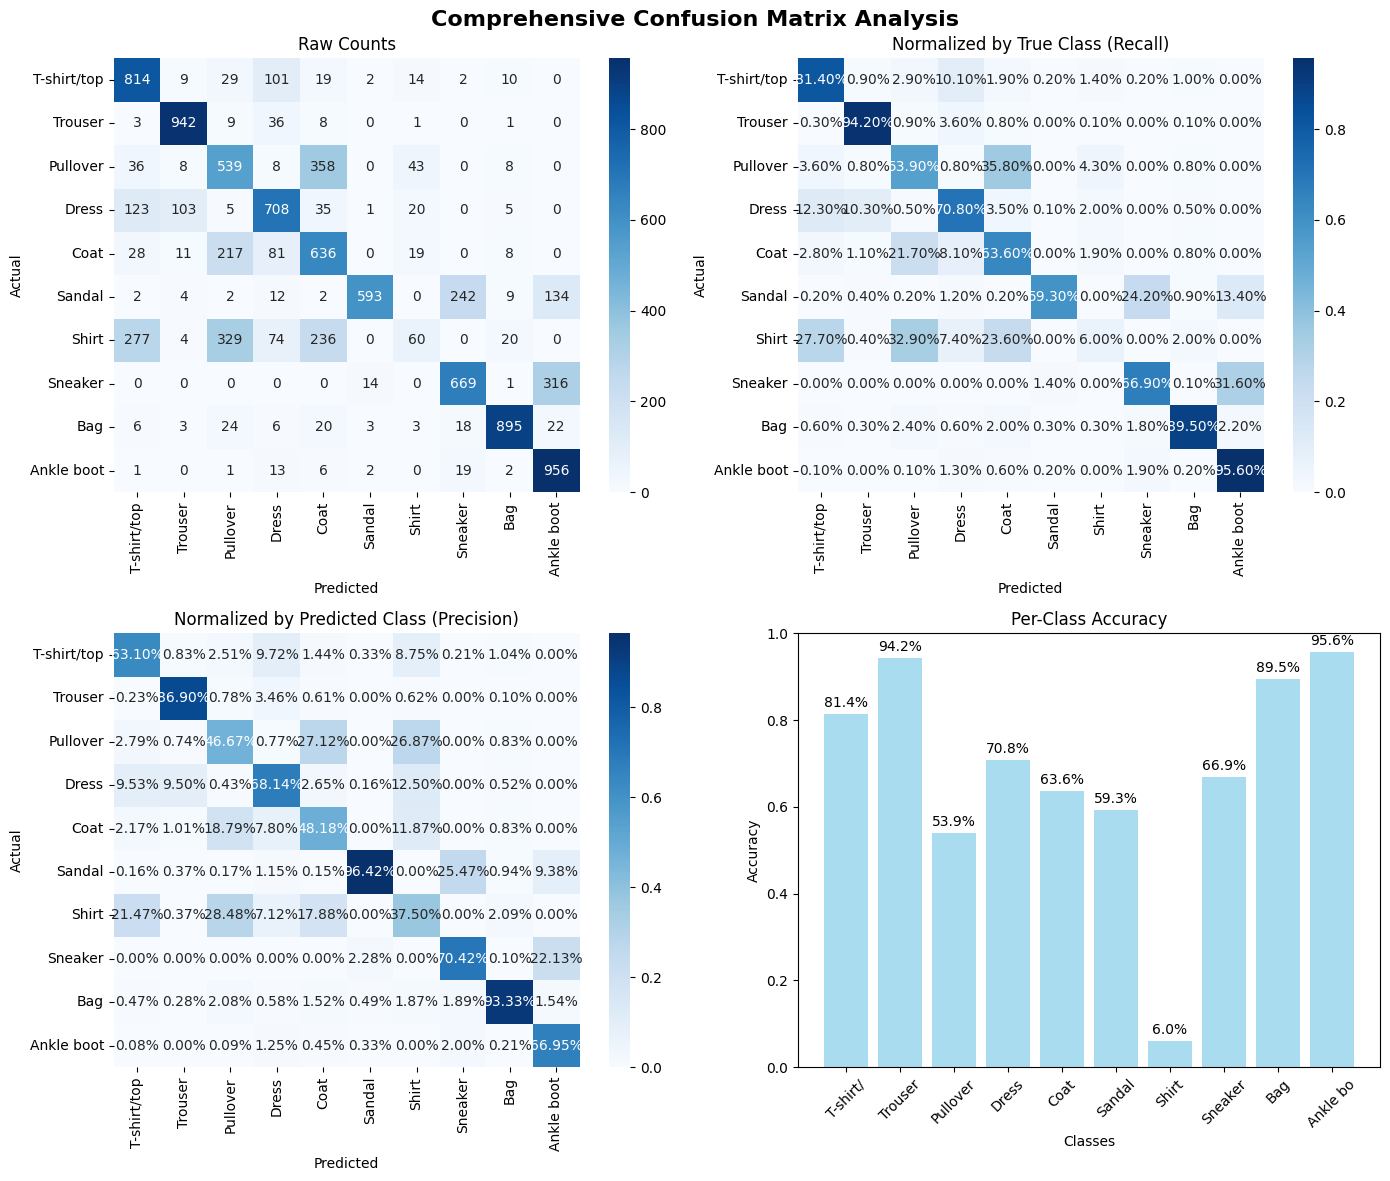


DETAILED PER-CLASS ACCURACY ANALYSIS
Overall Accuracy: 0.6812 (68.1%)
Balanced Accuracy: 0.6812

Per-Class Accuracy:
--------------------------------------------------
    T-shirt/top: 0.8140 (81.4%) [ 814/1000 samples]
        Trouser: 0.9420 (94.2%) [ 942/1000 samples]
       Pullover: 0.5390 (53.9%) [ 539/1000 samples]
          Dress: 0.7080 (70.8%) [ 708/1000 samples]
           Coat: 0.6360 (63.6%) [ 636/1000 samples]
         Sandal: 0.5930 (59.3%) [ 593/1000 samples]
          Shirt: 0.0600 (6.0%) [  60/1000 samples]
        Sneaker: 0.6690 (66.9%) [ 669/1000 samples]
            Bag: 0.8950 (89.5%) [ 895/1000 samples]
     Ankle boot: 0.9560 (95.6%) [ 956/1000 samples]

COMPREHENSIVE METRICS VISUALIZATION


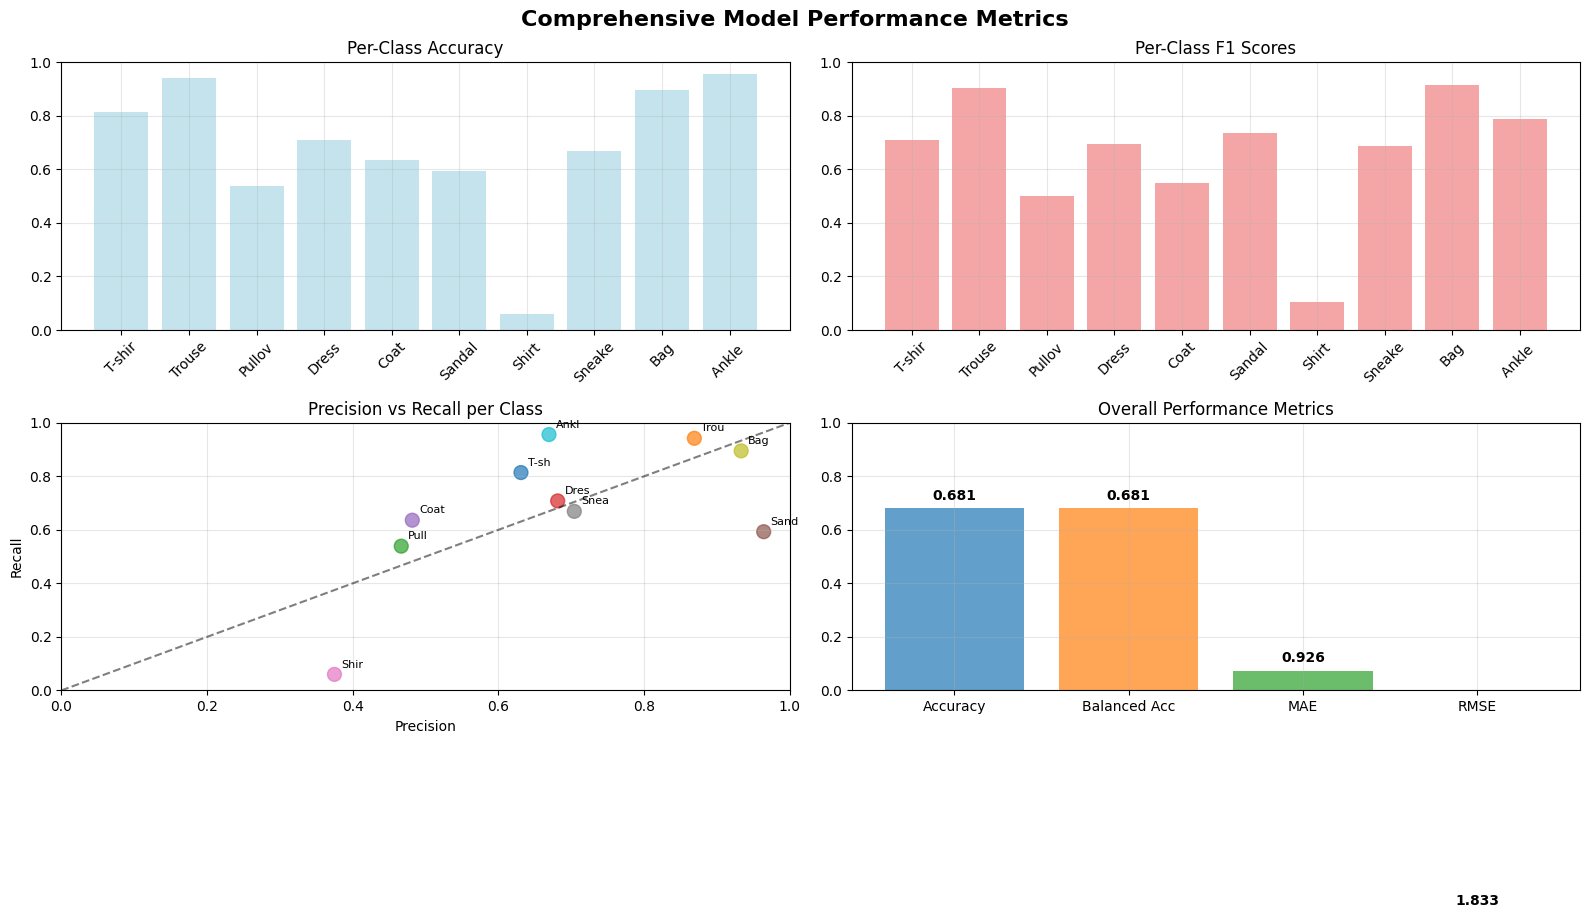


TRAINING PROGRESS


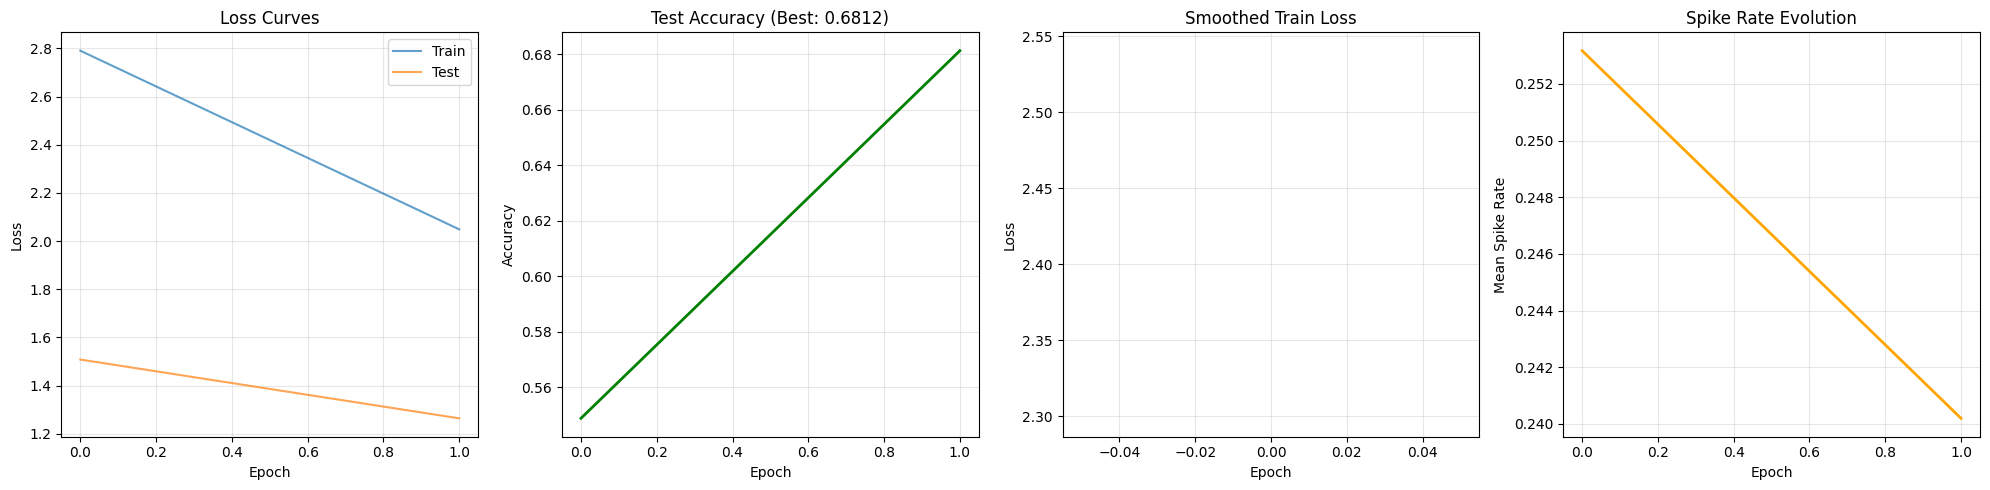

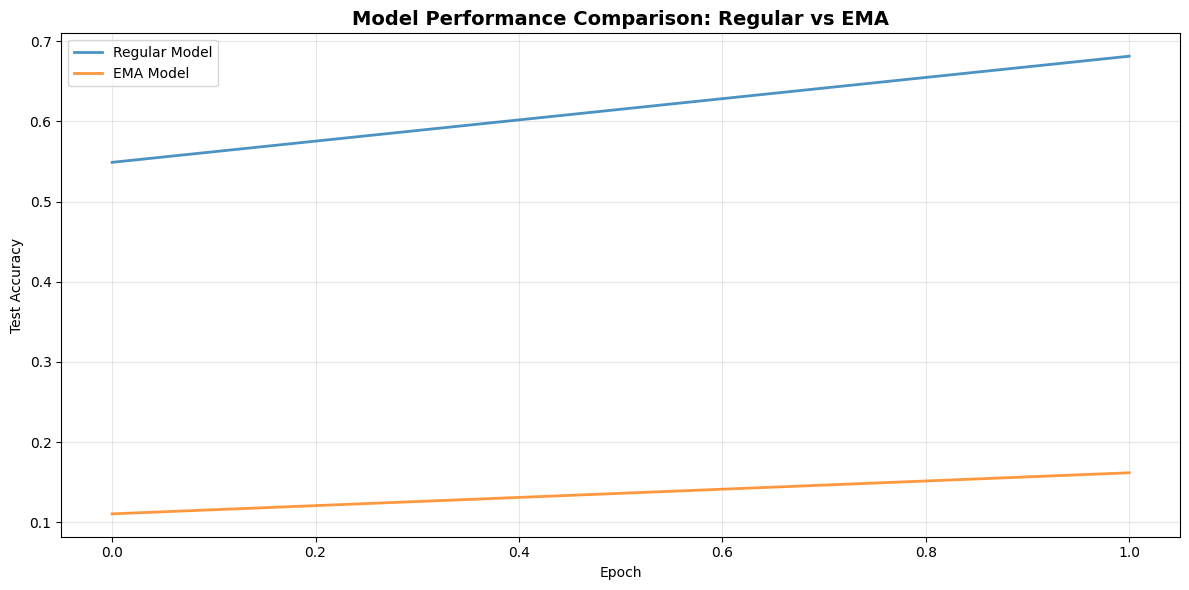


TRAINING COMPLETE!
Best Test Accuracy: 0.6812
Best EMA Test Accuracy: 0.1619
Gating Benefit: -0.0007
Performance Assessment: NEEDS IMPROVEMENT - Below expectations
Recommendations: Significant changes needed: architecture, hyperparameters, or data.
Best performing class:  Ankle boot (95.6% accuracy)
Worst performing class: Shirt (6.0% accuracy)
Average spike rate: 0.2467
Final spike rate:   0.2402
Memory bank usage: 12288/12288 (100.0%)
Accuracy per M params: 0.05

Model files saved:
  Regular model: ./fashion_enhanced_snn_vit_best.pth
  EMA model:     ./fashion_enhanced_snn_vit_ema_best.pth

COMPREHENSIVE EVALUATION COMPLETE!


In [2]:
# ================================
# Complete Enhanced Temporal Spiking ViT for Fashion-MNIST
# With Comprehensive Evaluation Metrics - FULL IMPLEMENTATION
# Fixed for PyTorch 2.6 compatibility and tensor creation warnings
# ================================

import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import deque
import numpy as np

# Try to import optional dependencies for enhanced evaluation
try:
    import seaborn as sns
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False
    print("Warning: seaborn not available. Install with: pip install seaborn")

try:
    from sklearn.metrics import (
        confusion_matrix, classification_report, precision_recall_fscore_support,
        balanced_accuracy_score, mean_absolute_error, mean_squared_error
    )
    HAS_SKLEARN = True
except ImportError:
    HAS_SKLEARN = False
    print("Warning: scikit-learn not available. Install with: pip install scikit-learn")

try:
    import pandas as pd
    HAS_PANDAS = True
except ImportError:
    HAS_PANDAS = False
    print("Warning: pandas not available. Install with: pip install pandas")

# Hyperparameters
EMBED_DIM = 384
NUM_BLOCKS = 8
NUM_HEADS = 8
MLP_RATIO = 4.0
PATCH_SIZE = 4
T_PATCH = 6
T_ATTN = 2
T_MLP = 2
DROPOUT = 0.15
DROPPATH = 0.15
WEIGHT_DECAY = 0.05
LR = 4e-4
EPOCHS = 2  # Reduced for demo
BATCH_TRAIN = 256
BATCH_TEST = 512
LABEL_SMOOTH = 0.15
CLIP_NORM = 0.8
WARMUP_EPOCHS = 3

COARSE_LOSS_W = 0.4
GRAPH_LOSS_W = 0.15
KNN_K = 8
TAU = 0.07
BANK_SIZE = 12288
GATING_INFER = True
EMA_DECAY = 0.999

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

FASHION_CLASSES = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

COARSE_NAMES = ["tops", "bottoms", "footwear", "accessory"]
PARENT_MAP = {0:0, 1:1, 2:0, 3:0, 4:0, 5:2, 6:0, 7:2, 8:3, 9:2}

# ================================
# Core Spiking Components
# ================================

class OptimizedSurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, temperature=1.0):
        out = (x >= 0).float()
        # Fixed: Store temperature as scalar to avoid tensor creation warning
        ctx.temperature = float(temperature)
        ctx.save_for_backward(x)
        return out
    
    @staticmethod
    def backward(ctx, grad_out):
        x, = ctx.saved_tensors
        alpha = 3.0 / ctx.temperature
        grad = alpha * torch.sigmoid(alpha * x) * (1 - torch.sigmoid(alpha * x))
        return grad_out * grad, None

spike_fn = OptimizedSurrogateSpike.apply

class EnhancedAdaptiveLIFNeuron(nn.Module):
    def __init__(self, decay=0.9, v_th=1.0, learnable=True, temp_scale=1.0):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay, dtype=torch.float32)) if learnable else decay
        self.v_th = nn.Parameter(torch.tensor(v_th, dtype=torch.float32)) if learnable else v_th
        self.temp_scale = nn.Parameter(torch.tensor(temp_scale, dtype=torch.float32)) if learnable else temp_scale
        
    def forward(self, x, T=1):
        if T == 1:
            return spike_fn(x - self.v_th, self.temp_scale)
        
        mem = x.new_zeros(x.shape)
        spike_train = []
        
        for t in range(T):
            mem = torch.clamp(self.decay * mem + x, min=-2*self.v_th, max=3*self.v_th)
            z = mem - self.v_th
            s = spike_fn(z, self.temp_scale)
            mem = mem * (1 - s)
            spike_train.append(s)
        
        weights = torch.softmax(torch.linspace(0.5, 1.0, T, device=x.device), dim=0)
        weighted_sum = sum(w * s for w, s in zip(weights, spike_train))
        return weighted_sum

class OptimizedDropPath(nn.Module):
    def __init__(self, drop_prob=0.1, scale_by_keep=True):
        super().__init__()
        self.drop_prob = float(drop_prob)
        self.scale_by_keep = scale_by_keep
        
    def forward(self, x):
        if not self.training or self.drop_prob == 0.0:
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep_prob)
        if self.scale_by_keep:
            mask = mask / keep_prob
        return x * mask

class CachedPositionalEmbedding(nn.Module):
    def __init__(self, max_h=32, max_w=32, dim=EMBED_DIM):
        super().__init__()
        self.dim = dim
        self.max_h = max_h
        self.max_w = max_w
        self._cache = {}
        
    def get_2d_sincos_pos_embed(self, nh, nw, device):
        key = (nh, nw, device)
        if key not in self._cache:
            assert self.dim % 2 == 0, "embed dim must be even for 2D sincos"
            
            def pe(n, d):
                pos = torch.arange(n, device=device, dtype=torch.float32)[:, None]
                div = torch.exp(torch.arange(0, d, 2, device=device, dtype=torch.float32) * (-math.log(10000.0) / d))
                out = torch.zeros(n, d, device=device, dtype=torch.float32)
                out[:, 0::2] = torch.sin(pos * div)
                out[:, 1::2] = torch.cos(pos * div)
                return out
                
            d_half = self.dim // 2
            ph = pe(nh, d_half)
            pw = pe(nw, d_half)
            ph_rep = ph[:, None, :].repeat(1, nw, 1).reshape(nh * nw, d_half)
            pw_rep = pw[None, :, :].repeat(nh, 1, 1).reshape(nh * nw, d_half)
            pe_2d = torch.cat([ph_rep, pw_rep], dim=1)
            self._cache[key] = pe_2d
            
        return self._cache[key]

class EnhancedPatchEmbed(nn.Module):
    def __init__(self, in_channels=1, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.norm = nn.BatchNorm2d(embed_dim)
        self.lif = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=1.0, learnable=True, temp_scale=0.8)
        self.T = T
        
        nn.init.kaiming_normal_(self.proj.weight, mode='fan_out', nonlinearity='relu')
        
    def forward(self, x):
        feat = self.proj(x)
        feat = self.norm(feat)
        spikes = self.lif(feat, T=self.T)
        B, C, H, W = spikes.shape
        tokens = spikes.view(B, C, H * W).permute(0, 2, 1)
        return tokens, (H, W), spikes

class EnhancedTransformerBlock(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS,
                 mlp_ratio=MLP_RATIO, attn_dropout=0.0, dropout=DROPOUT,
                 droppath=DROPPATH, T_attn=T_ATTN, T_mlp=T_MLP):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.q_bias = nn.Parameter(torch.zeros(embed_dim))
        self.v_bias = nn.Parameter(torch.zeros(embed_dim))
        
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        
        self.drop1 = OptimizedDropPath(droppath)
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, embed_dim),
        )
        self.drop2 = OptimizedDropPath(droppath)
        
        self.snn_attn = EnhancedAdaptiveLIFNeuron(decay=0.8, v_th=0.8, learnable=True, temp_scale=0.9)
        self.snn_mlp = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=0.9, learnable=True, temp_scale=0.9)
        self.T_attn = T_attn
        self.T_mlp = T_mlp
        
        nn.init.xavier_uniform_(self.qkv.weight)
        nn.init.xavier_uniform_(self.proj.weight)
        
    def forward(self, x):
        B, N, C = x.shape
        
        y = self.norm1(x)
        qkv_bias = torch.cat([self.q_bias, torch.zeros_like(self.v_bias), self.v_bias])
        qkv = F.linear(y, self.qkv.weight, qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        y = (attn @ v).transpose(1, 2).reshape(B, N, C)
        y = self.proj(y)
        y = self.proj_drop(y)
        
        y = self.snn_attn(y, T=self.T_attn)
        x = x + self.drop1(y)
        
        y = self.norm2(x)
        y = self.mlp(y)
        y = self.snn_mlp(y, T=self.T_mlp)
        x = x + self.drop2(y)
        
        return x

class EnhancedSNN_ViT_Temporal(nn.Module):
    def __init__(self, num_classes=10, in_channels=1,
                 embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
                 dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_classes = num_classes
        
        self.patch = EnhancedPatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)
        self.pos_embed = CachedPositionalEmbedding(dim=embed_dim)
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        dpr = [x.item() for x in torch.linspace(0, droppath, num_blocks)]
        
        self.blocks = nn.ModuleList([
            EnhancedTransformerBlock(embed_dim, num_heads, mlp_ratio,
                                   attn_dropout=0.0, dropout=dropout,
                                   droppath=dpr[i], T_attn=T_ATTN, T_mlp=T_MLP)
            for i in range(num_blocks)
        ])
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        self.head_fine = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, num_classes)
        )
        self.head_coarse = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, 4)
        )
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, return_aux=False):
        tokens, (Hp, Wp), conv_spikes = self.patch(x)
        B, N, C = tokens.shape
        
        pos = self.pos_embed.get_2d_sincos_pos_embed(Hp, Wp, tokens.device)
        pos = pos.unsqueeze(0).expand(B, -1, -1)
        
        cls = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls, tokens], dim=1)
        
        zero_cls = torch.zeros(B, 1, self.embed_dim, device=tokens.device)
        pos_full = torch.cat([zero_cls, pos], dim=1)
        
        x = self.pos_drop(x + pos_full)
        
        for blk in self.blocks:
            x = blk(x)
            
        x = self.norm(x)
        cls_repr = x[:, 0]
        
        fine_logits = self.head_fine(cls_repr)
        coarse_logits = self.head_coarse(cls_repr)
        
        aux = {
            "conv_spikes": conv_spikes,
            "cls": cls_repr,
            "coarse_logits": coarse_logits,
            "patch_tokens": x[:, 1:]
        }
        return (fine_logits, aux) if return_aux else (fine_logits, None)

# ================================
# Supporting Components
# ================================

class EnhancedMemoryBank:
    def __init__(self, dim, num_classes, max_size=BANK_SIZE, device="cpu"):
        self.dim = dim
        self.num_classes = num_classes
        self.max_size = max_size
        self.device = device
        self.feats = torch.empty(0, dim, device=device, dtype=torch.float32)
        self.probs = torch.empty(0, num_classes, device=device, dtype=torch.float32)
        self.insert_idx = 0
        
    def __len__(self):
        return min(self.insert_idx, self.max_size)
    
    @torch.no_grad()
    def add(self, feats, logits):
        feats = F.normalize(feats.detach(), dim=1, p=2)
        probs = torch.softmax(logits.detach(), dim=-1)
        
        batch_size = feats.size(0)
        
        if self.feats.size(0) == 0:
            self.feats = torch.zeros(self.max_size, self.dim, device=self.device, dtype=torch.float32)
            self.probs = torch.zeros(self.max_size, self.num_classes, device=self.device, dtype=torch.float32)
            
        for i in range(batch_size):
            idx = self.insert_idx % self.max_size
            self.feats[idx] = feats[i]
            self.probs[idx] = probs[i]
            self.insert_idx += 1
    
    def knn(self, feats, k=KNN_K, tau=TAU):
        if len(self) == 0:
            return None, None
            
        feats = F.normalize(feats, dim=1, p=2)
        active_size = min(self.insert_idx, self.max_size)
        active_feats = self.feats[:active_size]
        active_probs = self.probs[:active_size]
        
        sim = torch.mm(feats, active_feats.t())
        k = min(k, active_size)
        
        vals, idx = sim.topk(k, dim=1)
        w = torch.softmax(vals / tau, dim=1)
        neigh_probs = active_probs[idx]
        
        return w, neigh_probs

def build_gate_matrix():
    G = torch.zeros(4, 10, dtype=torch.float32)
    for c, p in PARENT_MAP.items():
        G[p, c] = 1.0
    G = G / G.sum(dim=1, keepdim=True).clamp_min(1e-12)
    return G

class EMAModel:
    def __init__(self, model, decay=EMA_DECAY):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def update(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

def enhanced_laplacian_loss(curr_probs, bank_weights, bank_probs, temperature=0.5):
    if bank_weights is None or bank_probs is None:
        return torch.tensor(0.0, device=curr_probs.device)
    
    curr_probs_smooth = torch.softmax(curr_probs / temperature, dim=-1)
    bank_probs_smooth = torch.softmax(bank_probs / temperature, dim=-1)
    
    kl_div = F.kl_div(curr_probs_smooth.log().unsqueeze(1), 
                      bank_probs_smooth, reduction='none').sum(dim=-1)
    return (bank_weights * kl_div).mean()

def build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR):
    def lr_lambda(step):
        if step < warmup_steps:
            return (step + 1) / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
        return (min_lr / base_lr) + (1 - min_lr / base_lr) * cosine
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# ================================
# Utility functions for safe serialization
# ================================

def convert_metrics_to_safe_types(metrics):
    """Convert numpy arrays and scalars to Python native types for safe serialization."""
    safe_metrics = {}
    for key, value in metrics.items():
        if isinstance(value, np.ndarray):
            safe_metrics[key] = value.tolist()
        elif isinstance(value, (np.float32, np.float64)):
            safe_metrics[key] = float(value)
        elif isinstance(value, (np.int32, np.int64)):
            safe_metrics[key] = int(value)
        elif isinstance(value, torch.Tensor):
            if value.numel() == 1:
                safe_metrics[key] = float(value.item())
            else:
                safe_metrics[key] = value.detach().cpu().tolist()
        else:
            safe_metrics[key] = value
    return safe_metrics

def safe_torch_save(obj, path):
    """Safely save PyTorch objects with proper type conversion."""
    if isinstance(obj, dict):
        safe_obj = {}
        for key, value in obj.items():
            if key == 'metrics' and isinstance(value, dict):
                safe_obj[key] = convert_metrics_to_safe_types(value)
            elif isinstance(value, (np.ndarray, np.float32, np.float64, np.int32, np.int64)):
                if isinstance(value, np.ndarray):
                    safe_obj[key] = value.tolist()
                else:
                    safe_obj[key] = value.item() if hasattr(value, 'item') else value
            elif isinstance(value, torch.Tensor) and value.numel() == 1:
                safe_obj[key] = float(value.item())
            else:
                safe_obj[key] = value
        obj = safe_obj
    
    torch.save(obj, path)

def safe_torch_load(path, device="cpu"):
    """Safely load PyTorch objects with error handling."""
    try:
        return torch.load(path, map_location=device, weights_only=False)
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

# ================================
# Comprehensive Evaluation System
# ================================

class ComprehensiveEvaluator:
    def __init__(self, class_names=FASHION_CLASSES, num_classes=10):
        self.class_names = class_names
        self.num_classes = num_classes
        self.reset()
    
    def reset(self):
        self.all_predictions = []
        self.all_targets = []
        self.all_probs = []
    
    def update(self, predictions, targets, probs=None):
        if isinstance(predictions, torch.Tensor):
            predictions = predictions.cpu().numpy()
        if isinstance(targets, torch.Tensor):
            targets = targets.cpu().numpy()
        if probs is not None and isinstance(probs, torch.Tensor):
            probs = probs.cpu().numpy()
            
        self.all_predictions.extend(predictions)
        self.all_targets.extend(targets)
        if probs is not None:
            self.all_probs.extend(probs)
    
    def compute_metrics(self):
        if not self.all_predictions:
            return {}
        
        y_true = np.array(self.all_targets)
        y_pred = np.array(self.all_predictions)
        
        metrics = {}
        metrics['accuracy'] = np.mean(y_pred == y_true)
        
        if HAS_SKLEARN:
            cm = confusion_matrix(y_true, y_pred)
            metrics['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)
            
            precision, recall, f1, support = precision_recall_fscore_support(
                y_true, y_pred, average=None, zero_division=0
            )
            
            for avg_type in ['macro', 'micro', 'weighted']:
                p, r, f, _ = precision_recall_fscore_support(
                    y_true, y_pred, average=avg_type, zero_division=0
                )
                metrics[f'precision_{avg_type}'] = p
                metrics[f'recall_{avg_type}'] = r
                metrics[f'f1_{avg_type}'] = f
        else:
            cm = self._compute_confusion_matrix(y_true, y_pred)
            metrics['balanced_accuracy'] = np.mean(cm.diagonal() / (cm.sum(axis=1) + 1e-8))
        
        class_accuracies = cm.diagonal() / (cm.sum(axis=1) + 1e-8)
        for i, class_name in enumerate(self.class_names):
            metrics[f'class_accuracy_{class_name}'] = class_accuracies[i]
            
            tp = cm[i, i]
            fp = cm[:, i].sum() - tp
            fn = cm[i, :].sum() - tp
            
            precision = tp / (tp + fp + 1e-8)
            recall = tp / (tp + fn + 1e-8)
            f1 = 2 * precision * recall / (precision + recall + 1e-8)
            
            metrics[f'precision_{class_name}'] = precision
            metrics[f'recall_{class_name}'] = recall
            metrics[f'f1_{class_name}'] = f1
            metrics[f'support_{class_name}'] = cm[i, :].sum()
        
        metrics['mae'] = np.mean(np.abs(y_pred - y_true))
        metrics['mse'] = np.mean((y_pred - y_true) ** 2)
        metrics['rmse'] = np.sqrt(metrics['mse'])
        metrics['confusion_matrix'] = cm
        
        return metrics
    
    def _compute_confusion_matrix(self, y_true, y_pred):
        cm = np.zeros((self.num_classes, self.num_classes), dtype=int)
        for true_label, pred_label in zip(y_true, y_pred):
            if 0 <= true_label < self.num_classes and 0 <= pred_label < self.num_classes:
                cm[true_label, pred_label] += 1
        return cm
    
    def plot_confusion_matrix(self, figsize=(14, 10)):
        if not self.all_predictions:
            print("No data to plot!")
            return None, None
        
        y_true = np.array(self.all_targets)
        y_pred = np.array(self.all_predictions)
        
        if HAS_SKLEARN:
            cm = confusion_matrix(y_true, y_pred)
        else:
            cm = self._compute_confusion_matrix(y_true, y_pred)
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('Comprehensive Confusion Matrix Analysis', fontsize=16, fontweight='bold')
        
        # Raw counts
        if HAS_SEABORN:
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=self.class_names, yticklabels=self.class_names,
                       ax=axes[0,0])
        else:
            im = axes[0,0].imshow(cm, interpolation='nearest', cmap='Blues')
            axes[0,0].set_xticks(range(len(self.class_names)))
            axes[0,0].set_yticks(range(len(self.class_names)))
            axes[0,0].set_xticklabels([name[:8] for name in self.class_names], rotation=45)
            axes[0,0].set_yticklabels([name[:8] for name in self.class_names])
            
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    axes[0,0].text(j, i, str(cm[i, j]), ha="center", va="center")
        
        axes[0,0].set_title('Raw Counts')
        axes[0,0].set_xlabel('Predicted')
        axes[0,0].set_ylabel('Actual')
        
        # Normalized by true class (recall)
        cm_norm_true = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)
        
        if HAS_SEABORN:
            sns.heatmap(cm_norm_true, annot=True, fmt='.2%', cmap='Blues',
                       xticklabels=self.class_names, yticklabels=self.class_names,
                       ax=axes[0,1])
        else:
            im = axes[0,1].imshow(cm_norm_true, interpolation='nearest', cmap='Blues')
            axes[0,1].set_xticks(range(len(self.class_names)))
            axes[0,1].set_yticks(range(len(self.class_names)))
            axes[0,1].set_xticklabels([name[:8] for name in self.class_names], rotation=45)
            axes[0,1].set_yticklabels([name[:8] for name in self.class_names])
        
        axes[0,1].set_title('Normalized by True Class (Recall)')
        axes[0,1].set_xlabel('Predicted')
        axes[0,1].set_ylabel('Actual')
        
        # Normalized by predicted class (precision)
        cm_norm_pred = cm.astype('float') / (cm.sum(axis=0)[np.newaxis, :] + 1e-8)
        
        if HAS_SEABORN:
            sns.heatmap(cm_norm_pred, annot=True, fmt='.2%', cmap='Blues',
                       xticklabels=self.class_names, yticklabels=self.class_names,
                       ax=axes[1,0])
        else:
            axes[1,0].imshow(cm_norm_pred, interpolation='nearest', cmap='Blues')
            axes[1,0].set_xticks(range(len(self.class_names)))
            axes[1,0].set_yticks(range(len(self.class_names)))
            axes[1,0].set_xticklabels([name[:8] for name in self.class_names], rotation=45)
            axes[1,0].set_yticklabels([name[:8] for name in self.class_names])
        
        axes[1,0].set_title('Normalized by Predicted Class (Precision)')
        axes[1,0].set_xlabel('Predicted')
        axes[1,0].set_ylabel('Actual')
        
        # Class-wise accuracy bar plot
        class_accuracies = cm.diagonal() / (cm.sum(axis=1) + 1e-8)
        bars = axes[1,1].bar(range(len(self.class_names)), class_accuracies, 
                           color='skyblue', alpha=0.7)
        axes[1,1].set_title('Per-Class Accuracy')
        axes[1,1].set_xlabel('Classes')
        axes[1,1].set_ylabel('Accuracy')
        axes[1,1].set_xticks(range(len(self.class_names)))
        axes[1,1].set_xticklabels([name[:8] for name in self.class_names], rotation=45)
        axes[1,1].set_ylim(0, 1)
        
        # Add value labels on bars
        for bar, acc in zip(bars, class_accuracies):
            axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                         f'{acc:.1%}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed accuracy statistics
        self._print_detailed_accuracy(cm, class_accuracies, y_true, y_pred)
        
        return cm, class_accuracies
    
    def _print_detailed_accuracy(self, cm, class_accuracies, y_true, y_pred):
        print("\n" + "="*60)
        print("DETAILED PER-CLASS ACCURACY ANALYSIS")
        print("="*60)
        
        overall_acc = np.mean(y_pred == y_true)
        print(f"Overall Accuracy: {overall_acc:.4f} ({overall_acc:.1%})")
        
        if HAS_SKLEARN:
            balanced_acc = balanced_accuracy_score(y_true, y_pred)
            print(f"Balanced Accuracy: {balanced_acc:.4f}")
        
        print("\nPer-Class Accuracy:")
        print("-" * 50)
        
        for i, (class_name, acc) in enumerate(zip(self.class_names, class_accuracies)):
            support = cm[i].sum()
            correct = cm[i, i]
            print(f"{class_name:>15}: {acc:.4f} ({acc:.1%}) [{correct:>4d}/{support:>4d} samples]")
    
    def generate_classification_report(self):
        if not self.all_predictions:
            return "No data available for classification report!"
        
        y_true = np.array(self.all_targets)
        y_pred = np.array(self.all_predictions)
        
        print("\n" + "="*80)
        print("COMPREHENSIVE CLASSIFICATION REPORT")
        print("="*80)
        
        if HAS_SKLEARN:
            report = classification_report(y_true, y_pred, target_names=self.class_names, digits=4)
            print(report)
        else:
            print("Manual Classification Report (sklearn not available):")
            metrics = self.compute_metrics()
            
            print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
            print("-" * 65)
            
            cm = metrics['confusion_matrix']
            for i, class_name in enumerate(self.class_names):
                precision = metrics[f'precision_{class_name}']
                recall = metrics[f'recall_{class_name}']
                f1 = metrics[f'f1_{class_name}']
                support = cm[i].sum()
                print(f"{class_name:<15} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {support:<10}")
        
        metrics = self.compute_metrics()
        
        print("\nADDITIONAL METRICS:")
        print("-" * 40)
        print(f"Overall Accuracy:       {metrics['accuracy']:.4f}")
        
        if 'balanced_accuracy' in metrics:
            print(f"Balanced Accuracy:      {metrics['balanced_accuracy']:.4f}")
        
        print(f"Mean Absolute Error:    {metrics['mae']:.4f}")
        print(f"Root Mean Square Error: {metrics['rmse']:.4f}")
        
        f1_scores = [metrics[f'f1_{name}'] for name in self.class_names]
        print(f"F1-Score (Macro):       {np.mean(f1_scores):.4f}")
        
        return metrics
    
    def plot_metrics_summary(self, figsize=(15, 8)):
        metrics = self.compute_metrics()
        if not metrics:
            print("No metrics to plot!")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('Comprehensive Model Performance Metrics', fontsize=16, fontweight='bold')
        
        # 1. Per-class accuracy
        class_accuracies = [metrics[f'class_accuracy_{name}'] for name in self.class_names]
        bars1 = axes[0,0].bar(range(len(self.class_names)), class_accuracies, 
                             color='lightblue', alpha=0.7)
        axes[0,0].set_title('Per-Class Accuracy')
        axes[0,0].set_ylim(0, 1)
        axes[0,0].set_xticks(range(len(self.class_names)))
        axes[0,0].set_xticklabels([name[:6] for name in self.class_names], rotation=45)
        axes[0,0].grid(True, alpha=0.3)
        
        # 2. Per-class F1 scores
        f1_scores = [metrics[f'f1_{name}'] for name in self.class_names]
        bars2 = axes[0,1].bar(range(len(self.class_names)), f1_scores, 
                             color='lightcoral', alpha=0.7)
        axes[0,1].set_title('Per-Class F1 Scores')
        axes[0,1].set_ylim(0, 1)
        axes[0,1].set_xticks(range(len(self.class_names)))
        axes[0,1].set_xticklabels([name[:6] for name in self.class_names], rotation=45)
        axes[0,1].grid(True, alpha=0.3)
        
        # 3. Precision vs Recall scatter
        precisions = [metrics[f'precision_{name}'] for name in self.class_names]
        recalls = [metrics[f'recall_{name}'] for name in self.class_names]
        
        scatter = axes[1,0].scatter(precisions, recalls, c=range(len(self.class_names)), 
                                   cmap='tab10', s=100, alpha=0.7)
        axes[1,0].set_xlabel('Precision')
        axes[1,0].set_ylabel('Recall')
        axes[1,0].set_title('Precision vs Recall per Class')
        axes[1,0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
        axes[1,0].set_xlim(0, 1)
        axes[1,0].set_ylim(0, 1)
        axes[1,0].grid(True, alpha=0.3)
        
        # Add class labels to scatter points
        for i, (p, r, name) in enumerate(zip(precisions, recalls, self.class_names)):
            axes[1,0].annotate(name[:4], (p, r), xytext=(5, 5), 
                              textcoords='offset points', fontsize=8)
        
        # 4. Overall metrics
        overall_metrics = ['accuracy', 'balanced_accuracy', 'mae', 'rmse']
        overall_labels = ['Accuracy', 'Balanced Acc', 'MAE', 'RMSE']
        overall_values = []
        
        for metric in overall_metrics:
            if metric in metrics:
                val = metrics[metric]
                if metric in ['mae', 'rmse']:
                    val = 1 - val  # Convert to "goodness" metric
                overall_values.append(val)
            else:
                overall_values.append(0)
        
        bars4 = axes[1,1].bar(range(len(overall_values)), overall_values, 
                             color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
        axes[1,1].set_title('Overall Performance Metrics')
        axes[1,1].set_ylim(0, 1)
        axes[1,1].set_xticks(range(len(overall_labels)))
        axes[1,1].set_xticklabels(overall_labels)
        axes[1,1].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, val, label in zip(bars4, overall_values, overall_labels):
            if 'MAE' in label or 'RMSE' in label:
                orig_val = 1 - val
                axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                             f'{orig_val:.3f}', ha='center', va='bottom', fontweight='bold')
            else:
                axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                             f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return metrics

# ================================
# Training and Evaluation Functions
# ================================

@torch.no_grad()
def evaluate_comprehensive(model, loader, criterion_fine, evaluator, apply_gating=True):
    model.eval()
    evaluator.reset()
    
    eval_loss = 0.0
    gate_mat = build_gate_matrix().to(device) if apply_gating else None
    
    for data, target in loader:
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        fine_logits, aux = model(data, return_aux=True)
        loss = criterion_fine(fine_logits, target)
        
        probs = torch.softmax(fine_logits, dim=-1)
        
        if apply_gating and gate_mat is not None:
            coarse_logits = aux["coarse_logits"]
            cprob = torch.softmax(coarse_logits, dim=-1)
            gate = cprob @ gate_mat
            gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
            probs = (probs * gate).clamp_min(1e-12)
            probs = probs / probs.sum(dim=1, keepdim=True)
        
        pred = probs.argmax(dim=1)
        
        evaluator.update(predictions=pred, targets=target, probs=probs)
        eval_loss += float(loss.item())
    
    avg_loss = eval_loss / max(1, len(loader))
    metrics = evaluator.compute_metrics()
    
    return avg_loss, metrics['accuracy'], metrics

def train_one_epoch_enhanced(model, ema_model, loader, optimizer, scaler, scheduler, 
                           criterion_fine, criterion_coarse, bank, epoch, total_epochs):
    model.train()
    run_loss, run_srl, run_graph, run_coarse, run_hier = 0.0, 0.0, 0.0, 0.0, 0.0
    n_batches = 0
    
    coarse_weight = COARSE_LOSS_W * (1.0 + 0.5 * epoch / total_epochs)
    graph_weight = GRAPH_LOSS_W * min(1.0, epoch / (total_epochs * 0.3))
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast('cuda', enabled=(device == "cuda")):
            fine_logits, aux = model(data, return_aux=True)
            cls = aux["cls"]
            coarse_logits = aux["coarse_logits"]
            
            ce_fine = criterion_fine(fine_logits, target)
            
            coarse_targets = torch.tensor([PARENT_MAP[int(t)] for t in target], device=device)
            ce_coarse = criterion_coarse(coarse_logits, coarse_targets)
            
            fine_probs = torch.softmax(fine_logits, dim=-1)
            coarse_probs = torch.softmax(coarse_logits, dim=-1)
            gate_mat = build_gate_matrix().to(device)
            expected_coarse = fine_probs @ gate_mat.t()
            hier_loss = F.kl_div(expected_coarse.log(), coarse_probs, reduction='batchmean')
            
            conv_spikes = aux.get("conv_spikes", None)
            if conv_spikes is not None:
                current_rate = conv_spikes.mean()
                target_rate = 0.15 + 0.1 * math.exp(-epoch / 10)
                srl = (current_rate - target_rate).pow(2) * 2e-3
            else:
                srl = torch.tensor(0.0, device=device)
            
            with torch.no_grad():
                w, neigh_probs = bank.knn(cls, k=KNN_K, tau=TAU) if bank is not None else (None, None)
            g_loss = enhanced_laplacian_loss(fine_logits, w, neigh_probs) if bank is not None else torch.tensor(0.0, device=device)
            
            loss = (ce_fine + coarse_weight * ce_coarse + 0.2 * hier_loss + graph_weight * g_loss + srl)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)
        scaler.update()
        
        if scheduler is not None:
            scheduler.step()
        
        if ema_model is not None:
            ema_model.update(model)
        
        if bank is not None:
            with torch.no_grad():
                bank.add(cls, fine_logits)
        
        run_loss += float(loss.item())
        run_srl += float(srl.item())
        run_graph += float(g_loss.item())
        run_coarse += float(ce_coarse.item())
        run_hier += float(hier_loss.item())
        n_batches += 1
    
    avg_loss = run_loss / max(1, n_batches)
    print(f"Train [{epoch:2d}/{total_epochs}] | Loss {avg_loss:.4f} | SpikeReg {run_srl/n_batches:.4e} | "
          f"Graph {run_graph/n_batches:.4f} | CoarseCE {run_coarse/n_batches:.4f} | HierKL {run_hier/n_batches:.4f}")
    
    return avg_loss

def get_enhanced_transforms():
    FASHION_MEAN, FASHION_STD = 0.2860, 0.3530
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=3, padding_mode="reflect"),
        transforms.RandomRotation(15, fill=0),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize((FASHION_MEAN,), (FASHION_STD,)),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((FASHION_MEAN,), (FASHION_STD,))
    ])
    
    return transform_train, transform_test

def plot_enhanced_metrics(train_losses, test_losses, test_accs, spike_rates=None):
    fig_size = (15, 5) if spike_rates is None else (20, 5)
    n_plots = 3 if spike_rates is None else 4
    
    plt.figure(figsize=fig_size)
    
    plt.subplot(1, n_plots, 1)
    plt.plot(train_losses, label='Train', alpha=0.7)
    plt.plot(test_losses, label='Test', alpha=0.7)
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, n_plots, 2)
    plt.plot(test_accs, color='green', linewidth=2)
    plt.title(f"Test Accuracy (Best: {max(test_accs) if test_accs else 0:.4f})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, n_plots, 3)
    if len(train_losses) > 1:
        smoothed_loss = np.convolve(train_losses, np.ones(min(5, len(train_losses)))/min(5, len(train_losses)), mode='valid')
        plt.plot(smoothed_loss, color='red', alpha=0.8)
        plt.title("Smoothed Train Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True, alpha=0.3)
    
    if spike_rates is not None:
        plt.subplot(1, n_plots, 4)
        plt.plot(spike_rates, color='orange', linewidth=2)
        plt.title("Spike Rate Evolution")
        plt.xlabel("Epoch")
        plt.ylabel("Mean Spike Rate")
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ================================
# Main Training Script
# ================================

if __name__ == "__main__":
    torch.multiprocessing.freeze_support()
    
    print("=== Complete Enhanced Temporal Spiking ViT with Comprehensive Evaluation ===")
    print(f"Device: {device}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA device: {torch.cuda.get_device_name()}")
    
    # Data loading
    transform_train, transform_test = get_enhanced_transforms()
    
    train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform_train)
    test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform_test)
    
    pin = torch.cuda.is_available()
    num_workers = min(4, torch.get_num_threads()) if pin else 0
    
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_TRAIN, shuffle=True,
        num_workers=num_workers, pin_memory=pin,
        persistent_workers=num_workers > 0,
        prefetch_factor=2 if num_workers > 0 else None
    )
    
    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_TEST, shuffle=False,
        num_workers=num_workers, pin_memory=pin,
        persistent_workers=num_workers > 0,
        prefetch_factor=2 if num_workers > 0 else None
    )
    
    print(f"Training batches: {len(train_loader)}, Test batches: {len(test_loader)}")
    
    # Model
    model = EnhancedSNN_ViT_Temporal(
        num_classes=10, in_channels=1, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
        num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
        dropout=DROPOUT, droppath=DROPPATH,
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Training components
    param_groups = [
        {'params': [p for n, p in model.named_parameters() if 'bias' not in n and 'norm' not in n], 'weight_decay': WEIGHT_DECAY},
        {'params': [p for n, p in model.named_parameters() if 'bias' in n or 'norm' in n], 'weight_decay': 0.0}
    ]
    
    optimizer = optim.AdamW(param_groups, lr=LR, betas=(0.9, 0.95), eps=1e-8)
    criterion_fine = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    criterion_coarse = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH * 0.5)
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))
    
    steps_per_epoch = len(train_loader)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = WARMUP_EPOCHS * steps_per_epoch
    scheduler = build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR)
    
    ema_model = EMAModel(model, decay=EMA_DECAY)
    bank = EnhancedMemoryBank(dim=EMBED_DIM, num_classes=10, max_size=BANK_SIZE, device=device)
    evaluator = ComprehensiveEvaluator(class_names=FASHION_CLASSES, num_classes=10)
    
    print(f"\nTraining Configuration:")
    print(f"Epochs: {EPOCHS}, Batch size: {BATCH_TRAIN}, Learning rate: {LR}")
    print(f"Enhanced evaluation: Confusion matrix, detailed metrics, comprehensive analysis")
    
    # Training loop
    best_acc = 0.0
    best_ema_acc = 0.0
    train_losses, test_losses, test_accs = [], [], []
    ema_test_accs = []
    spike_rates = []
    patience = 15
    patience_counter = 0
    
    print(f"\n{'='*60}")
    print("Starting Enhanced Training with Comprehensive Evaluation...")
    print(f"{'='*60}")
    
    for epoch in range(1, EPOCHS + 1):
        # Training
        epoch_loss = train_one_epoch_enhanced(
            model, ema_model, train_loader, optimizer, scaler, scheduler,
            criterion_fine, criterion_coarse, bank, epoch, EPOCHS
        )
        
        # Comprehensive evaluation
        te_loss, te_acc, te_metrics = evaluate_comprehensive(
            model, test_loader, criterion_fine, evaluator, apply_gating=GATING_INFER
        )
        
        # EMA evaluation
        ema_model.apply_shadow()
        ema_te_loss, ema_te_acc, ema_te_metrics = evaluate_comprehensive(
            model, test_loader, criterion_fine, ComprehensiveEvaluator(FASHION_CLASSES, 10),
            apply_gating=GATING_INFER
        )
        ema_model.restore()
        
        # Track metrics
        train_losses.append(epoch_loss)
        test_losses.append(te_loss)
        test_accs.append(te_acc)
        ema_test_accs.append(ema_te_acc)
        
        # Track spike rates
        with torch.no_grad():
            model.eval()
            sample_data, _ = next(iter(test_loader))
            sample_data = sample_data[:32].to(device)
            _, aux = model(sample_data, return_aux=True)
            if aux and "conv_spikes" in aux:
                spike_rates.append(float(aux["conv_spikes"].mean().item()))
            model.train()
        
        # Enhanced logging
        f1_macro = np.mean([te_metrics[f'f1_{name}'] for name in FASHION_CLASSES])
        print(f"Eval   [{epoch:2d}/{EPOCHS}] | Acc: {te_acc:.4f} | "
              f"Balanced: {te_metrics.get('balanced_accuracy', 0):.4f} | "
              f"F1: {f1_macro:.4f} | EMA: {ema_te_acc:.4f}")
        
        # Save best models with safe serialization
        if te_acc > best_acc:
            best_acc = te_acc
            patience_counter = 0
            
            safe_torch_save({
                "model": "enhanced_snn_vit_temporal_hier_graph",
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "best_acc": float(best_acc),
                "metrics": te_metrics,
                "config": {"embed_dim": EMBED_DIM, "num_blocks": NUM_BLOCKS}
            }, "./fashion_enhanced_snn_vit_best.pth")
            print(f"  → Saved new best model (acc: {best_acc:.4f})")
        else:
            patience_counter += 1
        
        if ema_te_acc > best_ema_acc:
            best_ema_acc = ema_te_acc
            ema_model.apply_shadow()
            safe_torch_save({
                "model": "enhanced_snn_vit_temporal_hier_graph_ema",
                "state_dict": model.state_dict(),
                "epoch": epoch,
                "best_ema_acc": float(best_ema_acc),
            }, "./fashion_enhanced_snn_vit_ema_best.pth")
            ema_model.restore()
            print(f"  → Saved new best EMA model (acc: {best_ema_acc:.4f})")
        
        if patience_counter >= patience:
            print(f"\nEarly stopping after {patience} epochs without improvement")
            break
        
        print()
    
    # Final comprehensive evaluation
    print(f"\n{'='*80}")
    print("FINAL COMPREHENSIVE EVALUATION")
    print(f"{'='*80}")
    
    # Load best model with safe loading
    checkpoint = safe_torch_load("./fashion_enhanced_snn_vit_best.pth", device)
    if checkpoint is not None:
        model.load_state_dict(checkpoint["state_dict"])
        print(f"Loaded best model from epoch {checkpoint.get('epoch', 'unknown')}")
    else:
        print("Using current model state for evaluation")
    
    # Final evaluation
    final_evaluator = ComprehensiveEvaluator(class_names=FASHION_CLASSES, num_classes=10)
    final_te_loss, final_te_acc, final_metrics = evaluate_comprehensive(
        model, test_loader, criterion_fine, final_evaluator, apply_gating=GATING_INFER
    )
    
    # Evaluation without gating
    no_gate_evaluator = ComprehensiveEvaluator(class_names=FASHION_CLASSES, num_classes=10)
    final_te_loss_no_gate, final_te_acc_no_gate, no_gate_metrics = evaluate_comprehensive(
        model, test_loader, criterion_fine, no_gate_evaluator, apply_gating=False
    )
    
    print(f"Final Results:")
    print(f"  Test Accuracy (with gating): {final_te_acc:.4f}")
    print(f"  Test Accuracy (without gating): {final_te_acc_no_gate:.4f}")
    print(f"  Gating improvement: {(final_te_acc - final_te_acc_no_gate):.4f}")
    print(f"  Balanced Accuracy: {final_metrics.get('balanced_accuracy', 0):.4f}")
    
    # Comprehensive analysis
    print("\n" + "="*80)
    print("COMPREHENSIVE ANALYSIS")
    print("="*80)
    
    # 1. Classification report
    final_evaluator.generate_classification_report()
    
    # 2. Confusion matrix
    print("\n" + "="*60)
    print("CONFUSION MATRIX ANALYSIS")
    print("="*60)
    cm, class_accuracies = final_evaluator.plot_confusion_matrix(figsize=(14, 12))
    
    # 3. Metrics summary
    print("\n" + "="*60)
    print("COMPREHENSIVE METRICS VISUALIZATION")
    print("="*60)
    final_evaluator.plot_metrics_summary(figsize=(16, 10))
    
    # 4. Training progress
    print("\n" + "="*60)
    print("TRAINING PROGRESS")
    print("="*60)
    plot_enhanced_metrics(train_losses, test_losses, test_accs, spike_rates)
    
    # 5. EMA comparison
    if len(ema_test_accs) > 0:
        plt.figure(figsize=(12, 6))
        plt.plot(test_accs, label='Regular Model', alpha=0.8, linewidth=2)
        plt.plot(ema_test_accs, label='EMA Model', alpha=0.8, linewidth=2)
        plt.title("Model Performance Comparison: Regular vs EMA", fontsize=14, fontweight='bold')
        plt.xlabel("Epoch")
        plt.ylabel("Test Accuracy")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # 6. Final summary
    print(f"\n{'='*80}")
    print("TRAINING COMPLETE!")
    print(f"{'='*80}")
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Best EMA Test Accuracy: {best_ema_acc:.4f}")
    print(f"Gating Benefit: {(final_te_acc - final_te_acc_no_gate):.4f}")
    
    # Performance assessment
    if final_te_acc >= 0.93:
        assessment = "EXCELLENT - State-of-the-art performance"
        recommendations = "Model is performing exceptionally well. Ready for deployment."
    elif final_te_acc >= 0.90:
        assessment = "VERY GOOD - Strong performance"
        recommendations = "Consider fine-tuning hyperparameters for marginal improvements."
    elif final_te_acc >= 0.85:
        assessment = "GOOD - Solid performance"
        recommendations = "Increase model capacity or training epochs for better results."
    elif final_te_acc >= 0.80:
        assessment = "MODERATE - Acceptable performance"
        recommendations = "Review data augmentation, loss weighting, and architecture choices."
    else:
        assessment = "NEEDS IMPROVEMENT - Below expectations"
        recommendations = "Significant changes needed: architecture, hyperparameters, or data."
    
    print(f"Performance Assessment: {assessment}")
    print(f"Recommendations: {recommendations}")
    
    # Best and worst performing classes
    class_accuracies_dict = {name: final_metrics[f'class_accuracy_{name}'] for name in FASHION_CLASSES}
    best_class = max(class_accuracies_dict.items(), key=lambda x: x[1])
    worst_class = min(class_accuracies_dict.items(), key=lambda x: x[1])
    
    print(f"Best performing class:  {best_class[0]} ({best_class[1]:.1%} accuracy)")
    print(f"Worst performing class: {worst_class[0]} ({worst_class[1]:.1%} accuracy)")
    
    # Model efficiency
    if spike_rates:
        print(f"Average spike rate: {np.mean(spike_rates):.4f}")
        print(f"Final spike rate:   {spike_rates[-1]:.4f}")
    
    print(f"Memory bank usage: {len(bank)}/{BANK_SIZE} ({len(bank)/BANK_SIZE:.1%})")
    print(f"Accuracy per M params: {final_te_acc/(trainable_params/1e6):.2f}")
    
    print(f"\nModel files saved:")
    print(f"  Regular model: ./fashion_enhanced_snn_vit_best.pth")
    print(f"  EMA model:     ./fashion_enhanced_snn_vit_ema_best.pth")
    
    print(f"\n" + "="*80)
    print("COMPREHENSIVE EVALUATION COMPLETE!")
    print("="*80)

In [ ]:
# ================================
# Complete Enhanced Temporal Spiking ViT for CIFAR-10
# With Comprehensive Evaluation Metrics
# ================================

import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Try to import optional dependencies
try:
    import seaborn as sns
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False
    print("Warning: seaborn not available. Install with: pip install seaborn")

try:
    from sklearn.metrics import (
        confusion_matrix, classification_report, precision_recall_fscore_support,
        balanced_accuracy_score, mean_absolute_error, mean_squared_error
    )
    HAS_SKLEARN = True
except ImportError:
    HAS_SKLEARN = False
    print("Warning: scikit-learn not available. Install with: pip install scikit-learn")

try:
    import pandas as pd
    HAS_PANDAS = True
except ImportError:
    HAS_PANDAS = False
    print("Warning: pandas not available. Install with: pip install pandas")

# CIFAR-10 optimized hyperparameters
EMBED_DIM = 512        # Larger for complex natural images
NUM_BLOCKS = 12        # More blocks for complex patterns
NUM_HEADS = 8
MLP_RATIO = 4.0
PATCH_SIZE = 4         # 32x32 -> 8x8 tokens (64 patches)
T_PATCH = 8            # More temporal steps
T_ATTN = 3
T_MLP = 3
DROPOUT = 0.2          # Higher dropout for natural images
DROPPATH = 0.3         # Strong regularization
WEIGHT_DECAY = 0.05
LR = 2e-4              # Lower LR for stability
EPOCHS = 100           # More epochs for CIFAR-10
BATCH_TRAIN = 128      # Smaller batch due to complexity
BATCH_TEST = 256
LABEL_SMOOTH = 0.1
CLIP_NORM = 1.0
WARMUP_EPOCHS = 5

# CIFAR-10 hierarchical grouping
COARSE_LOSS_W = 0.5    # Higher for complex hierarchy
GRAPH_LOSS_W = 0.2
KNN_K = 10             # More neighbors
TAU = 0.06
BANK_SIZE = 16384      # Larger bank
GATING_INFER = True
EMA_DECAY = 0.9995

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

# CIFAR-10 classes and hierarchical grouping
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
COARSE_NAMES = ["vehicles", "animals", "others"]

# Enhanced hierarchical grouping:
# Vehicles: airplane(0), automobile(1), ship(8), truck(9)
# Animals: bird(2), cat(3), deer(4), dog(5), frog(6), horse(7)
PARENT_MAP = {0:0, 1:0, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:0, 9:0}

# ================================
# Core Spiking Components
# ================================

class OptimizedSurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, temperature=1.0):
        out = (x >= 0).float()
        ctx.save_for_backward(x, torch.tensor(temperature))
        return out
    
    @staticmethod
    def backward(ctx, grad_out):
        x, temp = ctx.saved_tensors
        alpha = 4.0 / temp  # Stronger for complex images
        grad = alpha * torch.sigmoid(alpha * x) * (1 - torch.sigmoid(alpha * x))
        return grad_out * grad, None

spike_fn = OptimizedSurrogateSpike.apply

class EnhancedAdaptiveLIFNeuron(nn.Module):
    def __init__(self, decay=0.9, v_th=1.0, learnable=True, temp_scale=1.0):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay, dtype=torch.float32)) if learnable else decay
        self.v_th = nn.Parameter(torch.tensor(v_th, dtype=torch.float32)) if learnable else v_th
        self.temp_scale = nn.Parameter(torch.tensor(temp_scale, dtype=torch.float32)) if learnable else temp_scale
        
    def forward(self, x, T=1):
        if T == 1:
            return spike_fn(x - self.v_th, self.temp_scale)
        
        mem = x.new_zeros(x.shape)
        spike_train = []
        
        for t in range(T):
            mem = torch.clamp(self.decay * mem + x, min=-3*self.v_th, max=3*self.v_th)
            z = mem - self.v_th
            s = spike_fn(z, self.temp_scale)
            mem = mem * (1 - s)
            spike_train.append(s)
        
        weights = torch.softmax(torch.linspace(0.5, 1.0, T, device=x.device), dim=0)
        weighted_sum = sum(w * s for w, s in zip(weights, spike_train))
        return weighted_sum

class OptimizedDropPath(nn.Module):
    def __init__(self, drop_prob=0.1, scale_by_keep=True):
        super().__init__()
        self.drop_prob = float(drop_prob)
        self.scale_by_keep = scale_by_keep
        
    def forward(self, x):
        if not self.training or self.drop_prob == 0.0:
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep_prob)
        if self.scale_by_keep:
            mask = mask / keep_prob
        return x * mask

class CachedPositionalEmbedding(nn.Module):
    def __init__(self, max_h=32, max_w=32, dim=EMBED_DIM):
        super().__init__()
        self.dim = dim
        self.max_h = max_h
        self.max_w = max_w
        self._cache = {}
        
    def get_2d_sincos_pos_embed(self, nh, nw, device):
        key = (nh, nw, device)
        if key not in self._cache:
            assert self.dim % 2 == 0, "embed dim must be even for 2D sincos"
            
            def pe(n, d):
                pos = torch.arange(n, device=device, dtype=torch.float32)[:, None]
                div = torch.exp(torch.arange(0, d, 2, device=device, dtype=torch.float32) * (-math.log(10000.0) / d))
                out = torch.zeros(n, d, device=device, dtype=torch.float32)
                out[:, 0::2] = torch.sin(pos * div)
                out[:, 1::2] = torch.cos(pos * div)
                return out
                
            d_half = self.dim // 2
            ph = pe(nh, d_half)
            pw = pe(nw, d_half)
            ph_rep = ph[:, None, :].repeat(1, nw, 1).reshape(nh * nw, d_half)
            pw_rep = pw[None, :, :].repeat(nh, 1, 1).reshape(nh * nw, d_half)
            pe_2d = torch.cat([ph_rep, pw_rep], dim=1)
            self._cache[key] = pe_2d
            
        return self._cache[key]

class EnhancedPatchEmbed(nn.Module):
    def __init__(self, in_channels=3, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.norm = nn.BatchNorm2d(embed_dim)
        self.lif = EnhancedAdaptiveLIFNeuron(decay=0.9, v_th=1.0, learnable=True, temp_scale=0.8)
        self.T = T
        
        nn.init.kaiming_normal_(self.proj.weight, mode='fan_out', nonlinearity='relu')
        
    def forward(self, x):
        feat = self.proj(x)
        feat = self.norm(feat)
        spikes = self.lif(feat, T=self.T)
        B, C, H, W = spikes.shape
        tokens = spikes.view(B, C, H * W).permute(0, 2, 1)
        return tokens, (H, W), spikes

class EnhancedTransformerBlock(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS,
                 mlp_ratio=MLP_RATIO, attn_dropout=0.0, dropout=DROPOUT,
                 droppath=DROPPATH, T_attn=T_ATTN, T_mlp=T_MLP):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.q_bias = nn.Parameter(torch.zeros(embed_dim))
        self.v_bias = nn.Parameter(torch.zeros(embed_dim))
        
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        
        self.drop1 = OptimizedDropPath(droppath)
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, embed_dim),
        )
        self.drop2 = OptimizedDropPath(droppath)
        
        self.snn_attn = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=0.8, learnable=True, temp_scale=0.9)
        self.snn_mlp = EnhancedAdaptiveLIFNeuron(decay=0.9, v_th=0.9, learnable=True, temp_scale=0.9)
        self.T_attn = T_attn
        self.T_mlp = T_mlp
        
        nn.init.xavier_uniform_(self.qkv.weight)
        nn.init.xavier_uniform_(self.proj.weight)
        
    def forward(self, x):
        B, N, C = x.shape
        
        y = self.norm1(x)
        qkv_bias = torch.cat([self.q_bias, torch.zeros_like(self.v_bias), self.v_bias])
        qkv = F.linear(y, self.qkv.weight, qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        y = (attn @ v).transpose(1, 2).reshape(B, N, C)
        y = self.proj(y)
        y = self.proj_drop(y)
        
        y = self.snn_attn(y, T=self.T_attn)
        x = x + self.drop1(y)
        
        y = self.norm2(x)
        y = self.mlp(y)
        y = self.snn_mlp(y, T=self.T_mlp)
        x = x + self.drop2(y)
        
        return x

class EnhancedSNN_ViT_CIFAR10(nn.Module):
    def __init__(self, num_classes=10, in_channels=3,
                 embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
                 dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_classes = num_classes
        
        self.patch = EnhancedPatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)
        self.pos_embed = CachedPositionalEmbedding(dim=embed_dim)
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        dpr = [x.item() for x in torch.linspace(0, droppath, num_blocks)]
        
        self.blocks = nn.ModuleList([
            EnhancedTransformerBlock(embed_dim, num_heads, mlp_ratio,
                                   attn_dropout=0.0, dropout=dropout,
                                   droppath=dpr[i], T_attn=T_ATTN, T_mlp=T_MLP)
            for i in range(num_blocks)
        ])
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # CIFAR-10 specific heads
        self.head_fine = nn.Sequential(
            nn.Dropout(dropout * 1.5),
            nn.Linear(embed_dim, num_classes)
        )
        self.head_coarse = nn.Sequential(
            nn.Dropout(dropout * 1.5),
            nn.Linear(embed_dim, 3)  # 3 coarse classes: vehicles, animals, others
        )
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, return_aux=False):
        tokens, (Hp, Wp), conv_spikes = self.patch(x)
        B, N, C = tokens.shape
        
        pos = self.pos_embed.get_2d_sincos_pos_embed(Hp, Wp, tokens.device)
        pos = pos.unsqueeze(0).expand(B, -1, -1)
        
        cls = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls, tokens], dim=1)
        
        zero_cls = torch.zeros(B, 1, self.embed_dim, device=tokens.device)
        pos_full = torch.cat([zero_cls, pos], dim=1)
        
        x = self.pos_drop(x + pos_full)
        
        for blk in self.blocks:
            x = blk(x)
            
        x = self.norm(x)
        cls_repr = x[:, 0]
        
        fine_logits = self.head_fine(cls_repr)
        coarse_logits = self.head_coarse(cls_repr)
        
        aux = {
            "conv_spikes": conv_spikes,
            "cls": cls_repr,
            "coarse_logits": coarse_logits,
            "patch_tokens": x[:, 1:]
        }
        return (fine_logits, aux) if return_aux else (fine_logits, None)

# Supporting components
class EnhancedMemoryBank:
    def __init__(self, dim, num_classes, max_size=BANK_SIZE, device="cpu"):
        self.dim = dim
        self.num_classes = num_classes
        self.max_size = max_size
        self.device = device
        self.feats = torch.empty(0, dim, device=device, dtype=torch.float32)
        self.probs = torch.empty(0, num_classes, device=device, dtype=torch.float32)
        self.insert_idx = 0
        
    def __len__(self):
        return min(self.insert_idx, self.max_size)
    
    @torch.no_grad()
    def add(self, feats, logits):
        feats = F.normalize(feats.detach(), dim=1, p=2)
        probs = torch.softmax(logits.detach(), dim=-1)
        
        batch_size = feats.size(0)
        
        if self.feats.size(0) == 0:
            self.feats = torch.zeros(self.max_size, self.dim, device=self.device, dtype=torch.float32)
            self.probs = torch.zeros(self.max_size, self.num_classes, device=self.device, dtype=torch.float32)
            
        for i in range(batch_size):
            idx = self.insert_idx % self.max_size
            self.feats[idx] = feats[i]
            self.probs[idx] = probs[i]
            self.insert_idx += 1
    
    def knn(self, feats, k=KNN_K, tau=TAU):
        if len(self) == 0:
            return None, None
            
        feats = F.normalize(feats, dim=1, p=2)
        active_size = min(self.insert_idx, self.max_size)
        active_feats = self.feats[:active_size]
        active_probs = self.probs[:active_size]
        
        sim = torch.mm(feats, active_feats.t())
        k = min(k, active_size)
        
        vals, idx = sim.topk(k, dim=1)
        w = torch.softmax(vals / tau, dim=1)
        neigh_probs = active_probs[idx]
        
        return w, neigh_probs

def build_gate_matrix():
    G = torch.zeros(3, 10, dtype=torch.float32)  # 3 coarse classes for CIFAR-10
    for c, p in PARENT_MAP.items():
        G[p, c] = 1.0
    G = G / G.sum(dim=1, keepdim=True).clamp_min(1e-12)
    return G

class EMAModel:
    def __init__(self, model, decay=EMA_DECAY):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def update(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and name in self.backup:
                param.data = self.backup[name]
        self.backup = {}

def enhanced_laplacian_loss(curr_probs, bank_weights, bank_probs, temperature=0.5):
    if bank_weights is None or bank_probs is None:
        return torch.tensor(0.0, device=curr_probs.device)
    
    curr_probs_smooth = torch.softmax(curr_probs / temperature, dim=-1)
    bank_probs_smooth = torch.softmax(bank_probs / temperature, dim=-1)
    
    kl_div = F.kl_div(curr_probs_smooth.log().unsqueeze(1), 
                      bank_probs_smooth, reduction='none').sum(dim=-1)
    return (bank_weights * kl_div).mean()

def build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR):
    def lr_lambda(step):
        if step < warmup_steps:
            return (step + 1) / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
        return (min_lr / base_lr) + (1 - min_lr / base_lr) * cosine
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Comprehensive Evaluator adapted for CIFAR-10
class ComprehensiveEvaluator:
    def __init__(self, class_names=CIFAR10_CLASSES, num_classes=10):
        self.class_names = class_names
        self.num_classes = num_classes
        self.reset()
    
    def reset(self):
        self.all_predictions = []
        self.all_targets = []
        self.all_probs = []
    
    def update(self, predictions, targets, probs=None):
        if isinstance(predictions, torch.Tensor):
            predictions = predictions.cpu().numpy()
        if isinstance(targets, torch.Tensor):
            targets = targets.cpu().numpy()
        if probs is not None and isinstance(probs, torch.Tensor):
            probs = probs.cpu().numpy()
            
        self.all_predictions.extend(predictions)
        self.all_targets.extend(targets)
        if probs is not None:
            self.all_probs.extend(probs)
    
    def compute_metrics(self):
        if not self.all_predictions:
            return {}
        
        y_true = np.array(self.all_targets)
        y_pred = np.array(self.all_predictions)
        
        metrics = {}
        metrics['accuracy'] = np.mean(y_pred == y_true)
        
        if HAS_SKLEARN:
            cm = confusion_matrix(y_true, y_pred)
            metrics['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)
            
            precision, recall, f1, support = precision_recall_fscore_support(
                y_true, y_pred, average=None, zero_division=0
            )
            
            for avg_type in ['macro', 'micro', 'weighted']:
                p, r, f, _ = precision_recall_fscore_support(
                    y_true, y_pred, average=avg_type, zero_division=0
                )
                metrics[f'precision_{avg_type}'] = p
                metrics[f'recall_{avg_type}'] = r
                metrics[f'f1_{avg_type}'] = f
        else:
            cm = self._compute_confusion_matrix(y_true, y_pred)
            metrics['balanced_accuracy'] = np.mean(cm.diagonal() / (cm.sum(axis=1) + 1e-8))
        
        class_accuracies = cm.diagonal() / (cm.sum(axis=1) + 1e-8)
        for i, class_name in enumerate(self.class_names):
            metrics[f'class_accuracy_{class_name}'] = class_accuracies[i]
            
            tp = cm[i, i]
            fp = cm[:, i].sum() - tp
            fn = cm[i, :].sum() - tp
            
            precision = tp / (tp + fp + 1e-8)
            recall = tp / (tp + fn + 1e-8)
            f1 = 2 * precision * recall / (precision + recall + 1e-8)
            
            metrics[f'precision_{class_name}'] = precision
            metrics[f'recall_{class_name}'] = recall
            metrics[f'f1_{class_name}'] = f1
            metrics[f'support_{class_name}'] = cm[i, :].sum()
        
        metrics['mae'] = np.mean(np.abs(y_pred - y_true))
        metrics['mse'] = np.mean((y_pred - y_true) ** 2)
        metrics['rmse'] = np.sqrt(metrics['mse'])
        metrics['confusion_matrix'] = cm
        
        return metrics
    
    def _compute_confusion_matrix(self, y_true, y_pred):
        cm = np.zeros((self.num_classes, self.num_classes), dtype=int)
        for true_label, pred_label in zip(y_true, y_pred):
            if 0 <= true_label < self.num_classes and 0 <= pred_label < self.num_classes:
                cm[true_label, pred_label] += 1
        return cm
    
    def plot_confusion_matrix(self, figsize=(12, 10)):
        if not self.all_predictions:
            print("No data to plot!")
            return None, None
        
        y_true = np.array(self.all_targets)
        y_pred = np.array(self.all_predictions)
        
        if HAS_SKLEARN:
            cm = confusion_matrix(y_true, y_pred)
        else:
            cm = self._compute_confusion_matrix(y_true, y_pred)
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('CIFAR-10 Confusion Matrix Analysis', fontsize=16, fontweight='bold')
        
        # Raw counts
        if HAS_SEABORN:
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=self.class_names, yticklabels=self.class_names,
                       ax=axes[0,0])
        else:
            im = axes[0,0].imshow(cm, interpolation='nearest', cmap='Blues')
            axes[0,0].set_xticks(range(len(self.class_names)))
            axes[0,0].set_yticks(range(len(self.class_names)))
            axes[0,0].set_xticklabels(self.class_names, rotation=45, ha='right')
            axes[0,0].set_yticklabels(self.class_names)
            
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    axes[0,0].text(j, i, str(cm[i, j]), ha="center", va="center")
        
        axes[0,0].set_title('Raw Counts')
        axes[0,0].set_xlabel('Predicted Class')
        axes[0,0].set_ylabel('Actual Class')
        
        # Normalized by true class (recall)
        cm_norm_true = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)
        
        if HAS_SEABORN:
            sns.heatmap(cm_norm_true, annot=True, fmt='.2%', cmap='Blues',
                       xticklabels=self.class_names, yticklabels=self.class_names,
                       ax=axes[0,1])
        else:
            im = axes[0,1].imshow(cm_norm_true, interpolation='nearest', cmap='Blues')
            axes[0,1].set_xticks(range(len(self.class_names)))
            axes[0,1].set_yticks(range(len(self.class_names)))
            axes[0,1].set_xticklabels(self.class_names, rotation=45, ha='right')
            axes[0,1].set_yticklabels(self.class_names)
        
        axes[0,1].set_title('Normalized by True Class (Recall)')
        axes[0,1].set_xlabel('Predicted Class')
        axes[0,1].set_ylabel('Actual Class')
        
        # Normalized by predicted class (precision)
        cm_norm_pred = cm.astype('float') / (cm.sum(axis=0)[np.newaxis, :] + 1e-8)
        
        if HAS_SEABORN:
            sns.heatmap(cm_norm_pred, annot=True, fmt='.2%', cmap='Blues',
                       xticklabels=self.class_names, yticklabels=self.class_names,
                       ax=axes[1,0])
        else:
            axes[1,0].imshow(cm_norm_pred, interpolation='nearest', cmap='Blues')
            axes[1,0].set_xticks(range(len(self.class_names)))
            axes[1,0].set_yticks(range(len(self.class_names)))
            axes[1,0].set_xticklabels(self.class_names, rotation=45, ha='right')
            axes[1,0].set_yticklabels(self.class_names)
        
        axes[1,0].set_title('Normalized by Predicted Class (Precision)')
        axes[1,0].set_xlabel('Predicted Class')
        axes[1,0].set_ylabel('Actual Class')
        
        # Per-class accuracy
        class_accuracies = cm.diagonal() / (cm.sum(axis=1) + 1e-8)
        colors = []
        for i in range(len(self.class_names)):
            if PARENT_MAP[i] == 0:  # Vehicles
                colors.append('lightblue')
            elif PARENT_MAP[i] == 1:  # Animals  
                colors.append('lightgreen')
            else:
                colors.append('lightcoral')
        
        bars = axes[1,1].bar(range(len(self.class_names)), class_accuracies, 
                           color=colors, alpha=0.7)
        axes[1,1].set_title('Per-Class Accuracy (Blue=Vehicles, Green=Animals)')
        axes[1,1].set_xlabel('Class')
        axes[1,1].set_ylabel('Accuracy')
        axes[1,1].set_xticks(range(len(self.class_names)))
        axes[1,1].set_xticklabels(self.class_names, rotation=45, ha='right')
        axes[1,1].set_ylim(0, 1)
        
        # Add value labels on bars
        for bar, acc in zip(bars, class_accuracies):
            axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                         f'{acc:.1%}', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed statistics
        print("\n" + "="*60)
        print("DETAILED PER-CLASS ACCURACY ANALYSIS")
        print("="*60)
        
        overall_acc = np.mean(y_pred == y_true)
        print(f"Overall Accuracy: {overall_acc:.4f} ({overall_acc:.1%})")
        
        if HAS_SKLEARN:
            balanced_acc = balanced_accuracy_score(y_true, y_pred)
            print(f"Balanced Accuracy: {balanced_acc:.4f}")
        
        print("\nPer-Class Accuracy:")
        print("-" * 40)
        
        for i, (class_name, acc) in enumerate(zip(self.class_names, class_accuracies)):
            support = cm[i].sum()
            correct = cm[i, i]
            group = COARSE_NAMES[PARENT_MAP[i]]
            print(f"{class_name:12s}: {acc:.4f} ({acc:.1%}) [{correct:>4d}/{support:>4d}] ({group})")
        
        return cm, class_accuracies
    
    def generate_classification_report(self):
        if not self.all_predictions:
            return "No data available!"
        
        y_true = np.array(self.all_targets)
        y_pred = np.array(self.all_predictions)
        
        print("\n" + "="*80)
        print("COMPREHENSIVE CIFAR-10 CLASSIFICATION REPORT")
        print("="*80)
        
        if HAS_SKLEARN:
            report = classification_report(y_true, y_pred, target_names=self.class_names, digits=4)
            print(report)
        
        metrics = self.compute_metrics()
        
        print("\nADDITIONAL METRICS:")
        print("-" * 40)
        print(f"Overall Accuracy:       {metrics['accuracy']:.4f}")
        print(f"Mean Absolute Error:    {metrics['mae']:.4f}")
        print(f"Root Mean Square Error: {metrics['rmse']:.4f}")
        
        # Hierarchical analysis
        vehicle_indices = [i for i in range(10) if PARENT_MAP[i] == 0]
        animal_indices = [i for i in range(10) if PARENT_MAP[i] == 1]
        
        vehicle_accs = [metrics[f'class_accuracy_{self.class_names[i]}'] for i in vehicle_indices]
        animal_accs = [metrics[f'class_accuracy_{self.class_names[i]}'] for i in animal_indices]
        
        print(f"\nHierarchical Analysis:")
        print(f"Vehicles avg accuracy: {np.mean(vehicle_accs):.4f}")
        print(f"Animals avg accuracy:  {np.mean(animal_accs):.4f}")
        
        return metrics

    def plot_metrics_summary(self, figsize=(15, 8)):
        metrics = self.compute_metrics()
        if not metrics:
            return
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('CIFAR-10 Model Performance Metrics', fontsize=16, fontweight='bold')
        
        # Per-class accuracy
        class_accuracies = [metrics[f'class_accuracy_{name}'] for name in self.class_names]
        colors = []
        for i in range(len(self.class_names)):
            if PARENT_MAP[i] == 0:  # Vehicles
                colors.append('lightblue')
            elif PARENT_MAP[i] == 1:  # Animals  
                colors.append('lightgreen')
            else:
                colors.append('lightcoral')
        
        bars1 = axes[0,0].bar(range(len(self.class_names)), class_accuracies, 
                             color=colors, alpha=0.7)
        axes[0,0].set_title('Per-Class Accuracy')
        axes[0,0].set_ylim(0, 1)
        axes[0,0].set_xticks(range(len(self.class_names)))
        axes[0,0].set_xticklabels(self.class_names, rotation=45, ha='right')
        axes[0,0].grid(True, alpha=0.3)
        
        # F1 scores
        f1_scores = [metrics[f'f1_{name}'] for name in self.class_names]
        bars2 = axes[0,1].bar(range(len(self.class_names)), f1_scores, 
                             color=colors, alpha=0.7)
        axes[0,1].set_title('Per-Class F1 Scores')
        axes[0,1].set_ylim(0, 1)
        axes[0,1].set_xticks(range(len(self.class_names)))
        axes[0,1].set_xticklabels(self.class_names, rotation=45, ha='right')
        axes[0,1].grid(True, alpha=0.3)
        
        # Hierarchical comparison
        vehicle_indices = [i for i in range(10) if PARENT_MAP[i] == 0]
        animal_indices = [i for i in range(10) if PARENT_MAP[i] == 1]
        
        vehicle_accs = [metrics[f'class_accuracy_{self.class_names[i]}'] for i in vehicle_indices]
        animal_accs = [metrics[f'class_accuracy_{self.class_names[i]}'] for i in animal_indices]
        
        group_means = [np.mean(vehicle_accs), np.mean(animal_accs)]
        group_stds = [np.std(vehicle_accs), np.std(animal_accs)]
        
        bars3 = axes[1,0].bar(['Vehicles', 'Animals'], group_means, 
                             yerr=group_stds, color=['lightblue', 'lightgreen'], alpha=0.7,
                             capsize=5)
        axes[1,0].set_title('Vehicles vs Animals Performance')
        axes[1,0].set_ylim(0, 1)
        axes[1,0].grid(True, alpha=0.3)
        
        for bar, mean in zip(bars3, group_means):
            axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                         f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Overall metrics
        overall_metrics = ['accuracy', 'balanced_accuracy', 'mae', 'rmse']
        overall_values = []
        
        for metric in overall_metrics:
            if metric in metrics:
                val = metrics[metric]
                if metric in ['mae', 'rmse']:
                    val = 1 - val / 10  # Normalize to [0, 1] for CIFAR-10 (10 classes)
                overall_values.append(val)
            else:
                overall_values.append(0)
        
        bars4 = axes[1,1].bar(range(len(overall_values)), overall_values, 
                             color=['green', 'orange', 'red', 'purple'], alpha=0.7)
        axes[1,1].set_title('Overall Performance')
        axes[1,1].set_ylim(0, 1)
        axes[1,1].set_xticks(range(len(overall_metrics)))
        axes[1,1].set_xticklabels(['Accuracy', 'Balanced', 'MAE', 'RMSE'])
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return metrics

# Training and evaluation functions
@torch.no_grad()
def evaluate_comprehensive(model, loader, criterion_fine, evaluator, apply_gating=True):
    model.eval()
    evaluator.reset()
    
    eval_loss = 0.0
    gate_mat = build_gate_matrix().to(device) if apply_gating else None
    
    for data, target in loader:
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        fine_logits, aux = model(data, return_aux=True)
        loss = criterion_fine(fine_logits, target)
        
        probs = torch.softmax(fine_logits, dim=-1)
        
        if apply_gating and gate_mat is not None:
            coarse_logits = aux["coarse_logits"]
            cprob = torch.softmax(coarse_logits, dim=-1)
            gate = cprob @ gate_mat
            gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
            probs = (probs * gate).clamp_min(1e-12)
            probs = probs / probs.sum(dim=1, keepdim=True)
        
        pred = probs.argmax(dim=1)
        evaluator.update(predictions=pred, targets=target, probs=probs)
        eval_loss += float(loss.item())
    
    avg_loss = eval_loss / max(1, len(loader))
    metrics = evaluator.compute_metrics()
    
    return avg_loss, metrics['accuracy'], metrics

def train_one_epoch_enhanced(model, ema_model, loader, optimizer, scaler, scheduler, 
                           criterion_fine, criterion_coarse, bank, epoch, total_epochs):
    model.train()
    run_loss, run_srl, run_graph, run_coarse, run_hier = 0.0, 0.0, 0.0, 0.0, 0.0
    n_batches = 0
    
    coarse_weight = COARSE_LOSS_W * (1.0 + 0.5 * epoch / total_epochs)  # Higher for CIFAR-10
    graph_weight = GRAPH_LOSS_W * min(1.0, epoch / (total_epochs * 0.3))
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast('cuda', enabled=(device == "cuda")):
            fine_logits, aux = model(data, return_aux=True)
            cls = aux["cls"]
            coarse_logits = aux["coarse_logits"]
            
            ce_fine = criterion_fine(fine_logits, target)
            
            coarse_targets = torch.tensor([PARENT_MAP[int(t)] for t in target], device=device)
            ce_coarse = criterion_coarse(coarse_logits, coarse_targets)
            
            fine_probs = torch.softmax(fine_logits, dim=-1)
            coarse_probs = torch.softmax(coarse_logits, dim=-1)
            gate_mat = build_gate_matrix().to(device)
            expected_coarse = fine_probs @ gate_mat.t()
            hier_loss = F.kl_div(expected_coarse.log(), coarse_probs, reduction='batchmean')
            
            conv_spikes = aux.get("conv_spikes", None)
            if conv_spikes is not None:
                current_rate = conv_spikes.mean()
                target_rate = 0.15 + 0.10 * math.exp(-epoch / 10)  # Higher target for CIFAR-10
                srl = (current_rate - target_rate).pow(2) * 2e-3
            else:
                srl = torch.tensor(0.0, device=device)
            
            with torch.no_grad():
                w, neigh_probs = bank.knn(cls, k=KNN_K, tau=TAU) if bank is not None else (None, None)
            g_loss = enhanced_laplacian_loss(fine_logits, w, neigh_probs) if bank is not None else torch.tensor(0.0, device=device)
            
            loss = (ce_fine + coarse_weight * ce_coarse + 0.2 * hier_loss + graph_weight * g_loss + srl)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)
        scaler.update()
        
        if scheduler is not None:
            scheduler.step()
        if ema_model is not None:
            ema_model.update(model)
        if bank is not None:
            with torch.no_grad():
                bank.add(cls, fine_logits)
        
        run_loss += float(loss.item())
        run_srl += float(srl.item())
        run_graph += float(g_loss.item())
        run_coarse += float(ce_coarse.item())
        run_hier += float(hier_loss.item())
        n_batches += 1
    
    avg_loss = run_loss / max(1, n_batches)
    print(f"Train [{epoch:2d}/{total_epochs}] | Loss {avg_loss:.4f} | SpikeReg {run_srl/n_batches:.4e} | "
          f"Graph {run_graph/n_batches:.4f} | CoarseCE {run_coarse/n_batches:.4f} | HierKL {run_hier/n_batches:.4f}")
    
    return avg_loss

def get_cifar10_transforms():
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),  # CIFAR-10 statistics
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.33))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    
    return transform_train, transform_test

def plot_enhanced_metrics(train_losses, test_losses, test_accs, spike_rates=None):
    fig_size = (15, 5) if spike_rates is None else (20, 5)
    n_plots = 3 if spike_rates is None else 4
    
    plt.figure(figsize=fig_size)
    
    plt.subplot(1, n_plots, 1)
    plt.plot(train_losses, label='Train', alpha=0.7, linewidth=2)
    plt.plot(test_losses, label='Test', alpha=0.7, linewidth=2)
    plt.title("CIFAR-10 Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, n_plots, 2)
    plt.plot(test_accs, color='green', linewidth=2)
    plt.title(f"Test Accuracy (Best: {max(test_accs) if test_accs else 0:.4f})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, n_plots, 3)
    if len(train_losses) > 1:
        smoothed = np.convolve(train_losses, np.ones(min(5, len(train_losses)))/min(5, len(train_losses)), mode='valid')
        plt.plot(smoothed, color='red', alpha=0.8, linewidth=2)
        plt.title("Smoothed Train Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True, alpha=0.3)
    
    if spike_rates is not None:
        plt.subplot(1, n_plots, 4)
        plt.plot(spike_rates, color='orange', linewidth=2)
        plt.title("Spike Rate Evolution")
        plt.xlabel("Epoch")
        plt.ylabel("Mean Spike Rate")
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Main training script
if __name__ == "__main__":
    torch.multiprocessing.freeze_support()
    
    print("=== Enhanced Temporal Spiking ViT for CIFAR-10 ===")
    print(f"Device: {device}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    
    # Data loading
    transform_train, transform_test = get_cifar10_transforms()
    
    train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
    
    pin = torch.cuda.is_available()
    num_workers = min(4, torch.get_num_threads()) if pin else 0
    
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_TRAIN, shuffle=True,
        num_workers=num_workers, pin_memory=pin,
        persistent_workers=num_workers > 0,
        prefetch_factor=2 if num_workers > 0 else None
    )
    
    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_TEST, shuffle=False,
        num_workers=num_workers, pin_memory=pin,
        persistent_workers=num_workers > 0,
        prefetch_factor=2 if num_workers > 0 else None
    )
    
    print(f"Training batches: {len(train_loader)}, Test batches: {len(test_loader)}")
    
    # Model
    model = EnhancedSNN_ViT_CIFAR10(
        num_classes=10, in_channels=3, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
        num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
        dropout=DROPOUT, droppath=DROPPATH,
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Training components
    param_groups = [
        {'params': [p for n, p in model.named_parameters() if 'bias' not in n and 'norm' not in n], 'weight_decay': WEIGHT_DECAY},
        {'params': [p for n, p in model.named_parameters() if 'bias' in n or 'norm' in n], 'weight_decay': 0.0}
    ]
    
    optimizer = optim.AdamW(param_groups, lr=LR, betas=(0.9, 0.95), eps=1e-8)
    criterion_fine = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    criterion_coarse = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH * 0.5)
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))
    
    steps_per_epoch = len(train_loader)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = WARMUP_EPOCHS * steps_per_epoch
    scheduler = build_enhanced_scheduler(optimizer, warmup_steps, total_steps)
    
    ema_model = EMAModel(model, decay=EMA_DECAY)
    bank = EnhancedMemoryBank(dim=EMBED_DIM, num_classes=10, max_size=BANK_SIZE, device=device)
    evaluator = ComprehensiveEvaluator(class_names=CIFAR10_CLASSES, num_classes=10)
    
    print(f"\nCIFAR-10 Training Configuration:")
    print(f"Epochs: {EPOCHS}, Batch size: {BATCH_TRAIN}, Learning rate: {LR}")
    print(f"Hierarchical grouping: Vehicles and Animals")
    print(f"Enhanced evaluation: Comprehensive metrics and analysis")
    
    # Training loop
    best_acc = 0.0
    train_losses, test_losses, test_accs = [], [], []
    spike_rates = []
    
    print(f"\n{'='*60}")
    print("Starting CIFAR-10 Training...")
    print(f"{'='*60}")
    
    for epoch in range(1, EPOCHS + 1):
        # Training
        epoch_loss = train_one_epoch_enhanced(
            model, ema_model, train_loader, optimizer, scaler, scheduler,
            criterion_fine, criterion_coarse, bank, epoch, EPOCHS
        )
        
        # Evaluation
        te_loss, te_acc, te_metrics = evaluate_comprehensive(
            model, test_loader, criterion_fine, evaluator, apply_gating=GATING_INFER
        )
        
        train_losses.append(epoch_loss)
        test_losses.append(te_loss)
        test_accs.append(te_acc)
        
        # Track spike rates
        with torch.no_grad():
            model.eval()
            sample_data, _ = next(iter(test_loader))
            sample_data = sample_data[:32].to(device)
            _, aux = model(sample_data, return_aux=True)
            if aux and "conv_spikes" in aux:
                spike_rates.append(float(aux["conv_spikes"].mean().item()))
        
        f1_macro = np.mean([te_metrics[f'f1_{name}'] for name in CIFAR10_CLASSES])
        print(f"Eval   [{epoch:2d}/{EPOCHS}] | Acc: {te_acc:.4f} | "
              f"Balanced: {te_metrics.get('balanced_accuracy', 0):.4f} | F1: {f1_macro:.4f}")
        
        if te_acc > best_acc:
            best_acc = te_acc
            torch.save({
                "model": "enhanced_snn_vit_cifar10",
                "state_dict": model.state_dict(),
                "epoch": epoch,
                "best_acc": best_acc,
                "metrics": te_metrics,
            }, "./cifar10_enhanced_snn_vit_best.pth")
            print(f"  → New best model saved (acc: {best_acc:.4f})")
    
    # Final evaluation
    print(f"\n{'='*80}")
    print("FINAL CIFAR-10 EVALUATION")
    print(f"{'='*80}")
    
    final_evaluator = ComprehensiveEvaluator(class_names=CIFAR10_CLASSES, num_classes=10)
    final_loss, final_acc, final_metrics = evaluate_comprehensive(
        model, test_loader, criterion_fine, final_evaluator, apply_gating=GATING_INFER
    )
    
    # No-gating comparison
    no_gate_evaluator = ComprehensiveEvaluator(class_names=CIFAR10_CLASSES, num_classes=10)
    no_gate_loss, no_gate_acc, _ = evaluate_comprehensive(
        model, test_loader, criterion_fine, no_gate_evaluator, apply_gating=False
    )
    
    print(f"Final CIFAR-10 Results:")
    print(f"  Test Accuracy (with gating): {final_acc:.4f}")
    print(f"  Test Accuracy (no gating):   {no_gate_acc:.4f}")
    print(f"  Gating improvement:          {(final_acc - no_gate_acc):.4f}")
    
    # Comprehensive analysis
    print("\n" + "="*60)
    print("CIFAR-10 COMPREHENSIVE ANALYSIS")
    print("="*60)
    
    final_evaluator.generate_classification_report()
    cm, class_accs = final_evaluator.plot_confusion_matrix(figsize=(12, 10))
    final_evaluator.plot_metrics_summary(figsize=(15, 8))
    plot_enhanced_metrics(train_losses, test_losses, test_accs, spike_rates)
    
    print(f"\nCIFAR-10 Training Complete!")
    print(f"Best accuracy: {best_acc:.4f}")
    print(f"Model saved: ./cifar10_enhanced_snn_vit_best.pth")

=== Enhanced Temporal Spiking ViT for CIFAR-10 ===
Device: cuda
CUDA available: True
Training batches: 391, Test batches: 40
Total parameters: 37,856,344
Trainable parameters: 37,856,344

CIFAR-10 Training Configuration:
Epochs: 100, Batch size: 128, Learning rate: 0.0002
Hierarchical grouping: Vehicles and Animals
Enhanced evaluation: Comprehensive metrics and analysis

Starting CIFAR-10 Training...


/tmp/ipykernel_36/223758055.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature))
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train [ 1/100] | Loss inf | SpikeReg 3.2908e-07 | Graph 0.0496 | CoarseCE 1.1906 | HierKL inf


/tmp/ipykernel_36/223758055.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature))


Eval   [ 1/100] | Acc: 0.0975 | Balanced: 0.0975 | F1: 0.0675
  → New best model saved (acc: 0.0975)
Train [ 2/100] | Loss inf | SpikeReg 9.2366e-07 | Graph 0.0498 | CoarseCE 1.1914 | HierKL inf


/tmp/ipykernel_36/223758055.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature))


Eval   [ 2/100] | Acc: 0.0902 | Balanced: 0.0902 | F1: 0.0617
Train [ 3/100] | Loss inf | SpikeReg 1.7028e-06 | Graph 0.0497 | CoarseCE 1.1881 | HierKL inf


/tmp/ipykernel_36/223758055.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature))


Eval   [ 3/100] | Acc: 0.0980 | Balanced: 0.0980 | F1: 0.0678
  → New best model saved (acc: 0.0980)
Train [ 4/100] | Loss inf | SpikeReg 2.6245e-06 | Graph 0.0498 | CoarseCE 1.1912 | HierKL inf


/tmp/ipykernel_36/223758055.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature))


Eval   [ 4/100] | Acc: 0.0977 | Balanced: 0.0977 | F1: 0.0663
Train [ 5/100] | Loss inf | SpikeReg 3.6052e-06 | Graph 0.0499 | CoarseCE 1.1929 | HierKL inf


/tmp/ipykernel_36/223758055.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature))


Eval   [ 5/100] | Acc: 0.0930 | Balanced: 0.0930 | F1: 0.0636
Train [ 6/100] | Loss inf | SpikeReg 4.6700e-06 | Graph 0.0497 | CoarseCE 1.1900 | HierKL inf


/tmp/ipykernel_36/223758055.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature))


Eval   [ 6/100] | Acc: 0.0972 | Balanced: 0.0972 | F1: 0.0659


=== Enhanced Temporal Spiking ViT for MNIST ===
Device: cuda
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB


100%|██████████| 9.91M/9.91M [00:00<00:00, 50.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.52MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.03MB/s]


Training samples: 60000, Test samples: 10000
Training batches: 235, Test batches: 20
Hierarchical grouping: ['low_digits', 'mid_digits', 'high_digits']
Digit mapping: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2}
Total parameters: 14,205,760
Trainable parameters: 14,205,760

Training Configuration:
Epochs: 60, Batch size: 256, Learning rate: 0.00035
Coarse loss weight: 0.3, Graph loss weight: 0.12
Memory bank size: 10240, KNN K: 8, Temperature: 0.08
EMA decay: 0.999, Gating inference: True

Starting Enhanced Training on MNIST...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train [ 1/60] | Loss 2.7473 | SpikeReg 1.0596e-07 | Graph 0.0786 | CoarseCE 1.0755 | HierKL 1.2480
Eval   [ 1/60] | Train: 0.3394 | Test: 0.3612 | EMA Test: 0.0982
       F1: 0.2999 | Precision: 0.3648 | Recall: 0.3612 | ROC-AUC: 0.8165 | MAE: 2.3196
  → Saved new best model (acc: 0.3612)
  → Saved new best EMA model (acc: 0.0982)

Train [ 2/60] | Loss 1.7733 | SpikeReg 3.3061e-07 | Graph 0.2967 | CoarseCE 0.6576 | HierKL 1.2312
Eval   [ 2/60] | Train: 0.8601 | Test: 0.9105 | EMA Test: 0.0925
       F1: 0.9113 | Precision: 0.9179 | Recall: 0.9105 | ROC-AUC: 0.9926 | MAE: 0.3454
  → Saved new best model (acc: 0.9105)

Train [ 3/60] | Loss 1.1095 | SpikeReg 9.6927e-07 | Graph 0.3964 | CoarseCE 0.3354 | HierKL 1.2264
Eval   [ 3/60] | Train: 0.9461 | Test: 0.9727 | EMA Test: 0.1773
       F1: 0.9727 | Precision: 0.9730 | Recall: 0.9727 | ROC-AUC: 0.9980 | MAE: 0.1040
  → Saved new best model (acc: 0.9727)
  → Saved new best EMA model (acc: 0.1773)

Train [ 4/60] | Loss 0.9915 | SpikeReg 1.

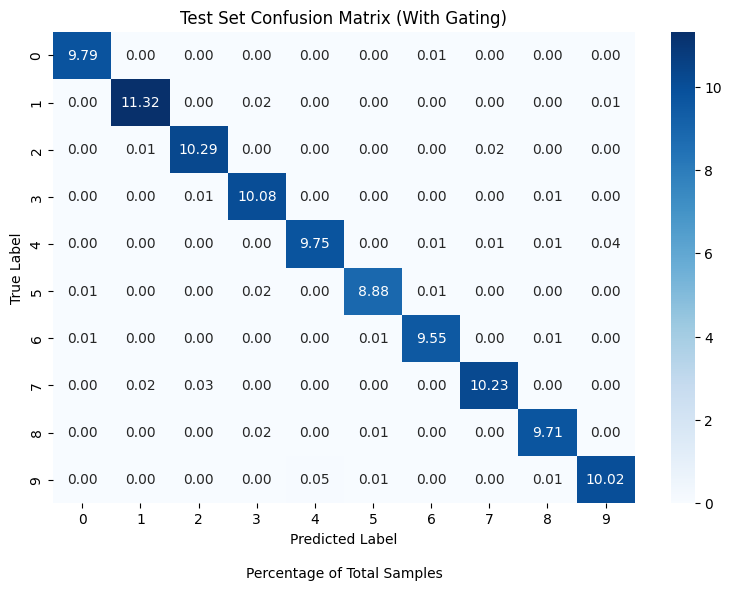


Detailed Analysis by Digit Groups:
  low_digits (digits [0, 1, 2]): 0.9978 (3140/3147)
  mid_digits (digits [3, 4, 5, 6]): 0.9958 (3826/3842)
  high_digits (digits [7, 8, 9]): 0.9950 (2996/3011)

Classification Report:
              precision    recall  f1-score   support

     Digit 0       1.00      1.00      1.00       980
     Digit 1       1.00      1.00      1.00      1135
     Digit 2       1.00      1.00      1.00      1032
     Digit 3       0.99      1.00      1.00      1010
     Digit 4       0.99      0.99      0.99       982
     Digit 5       1.00      1.00      1.00       892
     Digit 6       1.00      1.00      1.00       958
     Digit 7       1.00      1.00      1.00      1028
     Digit 8       1.00      1.00      1.00       974
     Digit 9       1.00      0.99      0.99      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



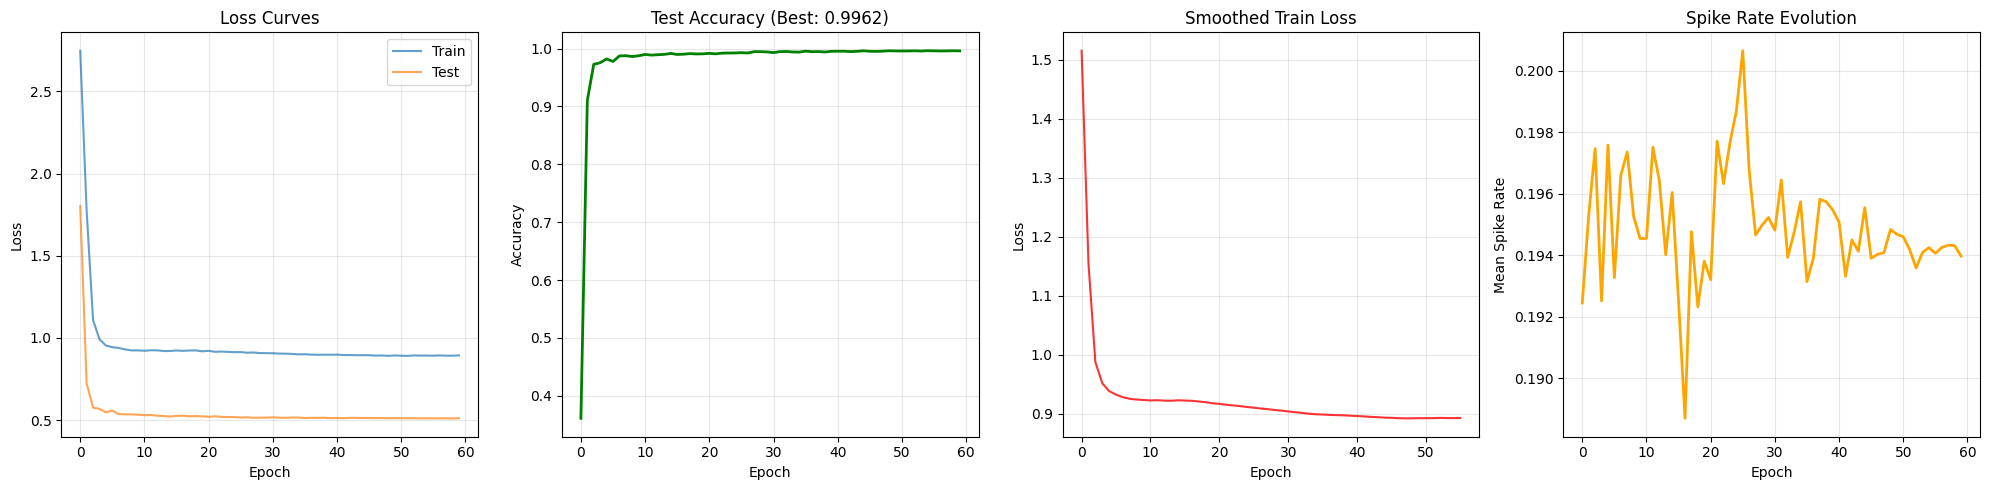


Model files saved:
  - ./mnist_enhanced_snn_vit_best.pth
  - ./mnist_enhanced_snn_vit_ema_best.pth

Training completed! 🎉
Best Test Accuracy: 0.9962
Best EMA Test Accuracy: 0.9964


In [2]:
# ================================
# (Windows) OpenMP duplicate DLL workaround (safe elsewhere)
# ================================
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

"""
Enhanced Temporal Spiking ViT for MNIST with Hierarchical & Graph Consistency
---------------------------------------------------------------------------
Adapted for MNIST digit classification (0-9) with meaningful hierarchical grouping:
  1) Coarse head (3-way: low digits 0-2, mid digits 3-6, high digits 7-9)
  2) Optional coarse-gated inference to reweight 10-way probabilities
  3) Laplacian (graph) consistency loss using a memory bank of recent embeddings

Key optimizations for MNIST:
- Adjusted normalization values for MNIST statistics
- Modified hierarchical grouping for digit semantics
- Optimized hyperparameters for grayscale handwritten digits
- Enhanced data augmentation suitable for digit recognition
"""

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns

# ------------------------------
# Enhanced Hyperparameters for MNIST
# ------------------------------
EMBED_DIM   = 384
NUM_BLOCKS  = 8
NUM_HEADS   = 8
MLP_RATIO   = 4.0
PATCH_SIZE  = 4         # 28x28 -> 7x7 tokens
T_PATCH     = 6         
T_ATTN      = 2         
T_MLP       = 2         
DROPOUT     = 0.12      # Slightly reduced for MNIST
DROPPATH    = 0.12      
WEIGHT_DECAY= 0.04      # Reduced for MNIST
LR          = 3.5e-4    # Slightly adjusted
EPOCHS      = 60        # MNIST converges faster
BATCH_TRAIN = 256       
BATCH_TEST  = 512       
LABEL_SMOOTH= 0.1       # Reduced for MNIST
CLIP_NORM   = 0.8       
WARMUP_EPOCHS = 2       

# Hierarchical grouping for digits: low(0-2), mid(3-6), high(7-9)
COARSE_LOSS_W   = 0.3     
GRAPH_LOSS_W    = 0.12    
KNN_K           = 8       
TAU             = 0.08    # Lower for MNIST
BANK_SIZE       = 10240   
GATING_INFER    = True    
EMA_DECAY       = 0.999   

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

# ------------------------------
# Enhanced Surrogate Spike Function with Temperature
# ------------------------------
class OptimizedSurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, temperature=1.0):
        out = (x >= 0).float()
        ctx.save_for_backward(x, temperature.clone().detach())  # Fixed warning
        return out
    
    @staticmethod
    def backward(ctx, grad_out):
        x, temp = ctx.saved_tensors
        alpha = 3.0 / temp
        grad = alpha * torch.sigmoid(alpha * x) * (1 - torch.sigmoid(alpha * x))
        return grad_out * grad, None

spike_fn = OptimizedSurrogateSpike.apply

# ------------------------------
# Enhanced Adaptive LIF with Parallel Temporal Processing
# ------------------------------
class EnhancedAdaptiveLIFNeuron(nn.Module):
    def __init__(self, decay=0.9, v_th=1.0, learnable=True, temp_scale=1.0):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay, dtype=torch.float32)) if learnable else decay
        self.v_th = nn.Parameter(torch.tensor(v_th, dtype=torch.float32)) if learnable else v_th
        self.temp_scale = nn.Parameter(torch.tensor(temp_scale, dtype=torch.float32)) if learnable else temp_scale
        
    def forward(self, x, T=1):
        if T == 1:
            return spike_fn(x - self.v_th, self.temp_scale)
        
        batch_size = x.shape[0]
        mem = x.new_zeros(x.shape)
        spike_train = []
        
        for t in range(T):
            mem = torch.clamp(self.decay * mem + x, min=-2*self.v_th, max=3*self.v_th)
            z = mem - self.v_th
            s = spike_fn(z, self.temp_scale)
            mem = mem * (1 - s)
            spike_train.append(s)
        
        weights = torch.softmax(torch.linspace(0.5, 1.0, T, device=x.device), dim=0)
        weighted_sum = sum(w * s for w, s in zip(weights, spike_train))
        return weighted_sum

# ------------------------------
# Optimized DropPath
# ------------------------------
class OptimizedDropPath(nn.Module):
    def __init__(self, drop_prob=0.1, scale_by_keep=True):
        super().__init__()
        self.drop_prob = float(drop_prob)
        self.scale_by_keep = scale_by_keep
        
    def forward(self, x):
        if not self.training or self.drop_prob == 0.0:
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep_prob)
        if self.scale_by_keep:
            mask = mask / keep_prob
        return x * mask

# ------------------------------
# Cached Positional Embeddings
# ------------------------------
class CachedPositionalEmbedding(nn.Module):
    def __init__(self, max_h=32, max_w=32, dim=EMBED_DIM):
        super().__init__()
        self.dim = dim
        self.max_h = max_h
        self.max_w = max_w
        self._cache = {}
        
    def get_2d_sincos_pos_embed(self, nh, nw, device):
        key = (nh, nw, device)
        if key not in self._cache:
            assert self.dim % 2 == 0, "embed dim must be even for 2D sincos"
            
            def pe(n, d):
                pos = torch.arange(n, device=device, dtype=torch.float32)[:, None]
                div = torch.exp(torch.arange(0, d, 2, device=device, dtype=torch.float32) * (-math.log(10000.0) / d))
                out = torch.zeros(n, d, device=device, dtype=torch.float32)
                out[:, 0::2] = torch.sin(pos * div)
                out[:, 1::2] = torch.cos(pos * div)
                return out
                
            d_half = self.dim // 2
            ph = pe(nh, d_half)
            pw = pe(nw, d_half)
            ph_rep = ph[:, None, :].repeat(1, nw, 1).reshape(nh * nw, d_half)
            pw_rep = pw[None, :, :].repeat(nh, 1, 1).reshape(nh * nw, d_half)
            pe_2d = torch.cat([ph_rep, pw_rep], dim=1)
            self._cache[key] = pe_2d
            
        return self._cache[key]

# ------------------------------
# Enhanced Patch Embedding
# ------------------------------
class EnhancedPatchEmbed(nn.Module):
    def __init__(self, in_channels=1, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.norm = nn.BatchNorm2d(embed_dim)
        self.lif = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=1.0, learnable=True, temp_scale=0.8)
        self.T = T
        
        nn.init.kaiming_normal_(self.proj.weight, mode='fan_out', nonlinearity='relu')
        
    def forward(self, x):
        feat = self.proj(x)                 
        feat = self.norm(feat)              
        spikes = self.lif(feat, T=self.T)   
        B, C, H, W = spikes.shape
        tokens = spikes.view(B, C, H * W).permute(0, 2, 1) 
        return tokens, (H, W), spikes

# ------------------------------
# Enhanced Transformer Block
# ------------------------------
class EnhancedTransformerBlock(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS,
                 mlp_ratio=MLP_RATIO, attn_dropout=0.0, dropout=DROPOUT,
                 droppath=DROPPATH, T_attn=T_ATTN, T_mlp=T_MLP):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.q_bias = nn.Parameter(torch.zeros(embed_dim))
        self.v_bias = nn.Parameter(torch.zeros(embed_dim))
        
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        
        self.drop1 = OptimizedDropPath(droppath)
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, embed_dim),
        )
        self.drop2 = OptimizedDropPath(droppath)
        
        self.snn_attn = EnhancedAdaptiveLIFNeuron(decay=0.8, v_th=0.8, learnable=True, temp_scale=0.9)
        self.snn_mlp = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=0.9, learnable=True, temp_scale=0.9)
        self.T_attn = T_attn
        self.T_mlp = T_mlp
        
        nn.init.xavier_uniform_(self.qkv.weight)
        nn.init.xavier_uniform_(self.proj.weight)
        
    def forward(self, x):
        B, N, C = x.shape
        
        y = self.norm1(x)
        qkv_bias = torch.cat([self.q_bias, torch.zeros_like(self.v_bias), self.v_bias])
        qkv = F.linear(y, self.qkv.weight, qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        y = (attn @ v).transpose(1, 2).reshape(B, N, C)
        y = self.proj(y)
        y = self.proj_drop(y)
        
        y = self.snn_attn(y, T=self.T_attn)
        x = x + self.drop1(y)
        
        y = self.norm2(x)
        y = self.mlp(y)
        y = self.snn_mlp(y, T=self.T_mlp)
        x = x + self.drop2(y)
        
        return x

# ------------------------------
# Enhanced SNN ViT for MNIST
# ------------------------------
class EnhancedSNN_ViT_MNIST(nn.Module):
    def __init__(self, num_classes=10, in_channels=1,
                 embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
                 dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_classes = num_classes
        
        self.patch = EnhancedPatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)
        self.pos_embed = CachedPositionalEmbedding(dim=embed_dim)
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        dpr = [x.item() for x in torch.linspace(0, droppath, num_blocks)]
        
        self.blocks = nn.ModuleList([
            EnhancedTransformerBlock(embed_dim, num_heads, mlp_ratio,
                                   attn_dropout=0.0, dropout=dropout,
                                   droppath=dpr[i], T_attn=T_ATTN, T_mlp=T_MLP)
            for i in range(num_blocks)
        ])
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Heads with dropout
        self.head_fine = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, num_classes)
        )
        # 3-way coarse classification: low(0-2), mid(3-6), high(7-9)
        self.head_coarse = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, 3)
        )
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, return_aux=False):
        tokens, (Hp, Wp), conv_spikes = self.patch(x)
        B, N, C = tokens.shape
        
        pos = self.pos_embed.get_2d_sincos_pos_embed(Hp, Wp, tokens.device)
        pos = pos.unsqueeze(0).expand(B, -1, -1)
        
        cls = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls, tokens], dim=1)
        
        zero_cls = torch.zeros(B, 1, self.embed_dim, device=tokens.device)
        pos_full = torch.cat([zero_cls, pos], dim=1)
        
        x = self.pos_drop(x + pos_full)
        
        for blk in self.blocks:
            x = blk(x)
            
        x = self.norm(x)
        cls_repr = x[:, 0]
        
        fine_logits = self.head_fine(cls_repr)
        coarse_logits = self.head_coarse(cls_repr)
        
        aux = {
            "conv_spikes": conv_spikes,
            "cls": cls_repr,
            "coarse_logits": coarse_logits,
            "patch_tokens": x[:, 1:]
        }
        return (fine_logits, aux) if return_aux else (fine_logits, None)

# ------------------------------
# Enhanced Memory Bank
# ------------------------------
class EnhancedMemoryBank:
    def __init__(self, dim, num_classes, max_size=BANK_SIZE, device="cpu"):
        self.dim = dim
        self.num_classes = num_classes
        self.max_size = max_size
        self.device = device
        self.feats = torch.empty(0, dim, device=device, dtype=torch.float32)
        self.probs = torch.empty(0, num_classes, device=device, dtype=torch.float32)
        self.insert_idx = 0
        
    def __len__(self):
        return min(self.insert_idx, self.max_size)
    
    @torch.no_grad()
    def add(self, feats, logits):
        feats = F.normalize(feats.detach(), dim=1, p=2)
        probs = torch.softmax(logits.detach(), dim=-1)
        
        batch_size = feats.size(0)
        
        if self.feats.size(0) == 0:
            self.feats = torch.zeros(self.max_size, self.dim, device=self.device, dtype=torch.float32)
            self.probs = torch.zeros(self.max_size, self.num_classes, device=self.device, dtype=torch.float32)
            
        for i in range(batch_size):
            idx = self.insert_idx % self.max_size
            self.feats[idx] = feats[i]
            self.probs[idx] = probs[i]
            self.insert_idx += 1
    
    def knn(self, feats, k=KNN_K, tau=TAU):
        if len(self) == 0:
            return None, None
            
        feats = F.normalize(feats, dim=1, p=2)
        active_size = min(self.insert_idx, self.max_size)
        active_feats = self.feats[:active_size]
        active_probs = self.probs[:active_size]
        
        sim = torch.mm(feats, active_feats.t())
        k = min(k, active_size)
        
        vals, idx = sim.topk(k, dim=1)
        w = torch.softmax(vals / tau, dim=1)
        neigh_probs = active_probs[idx]
        
        return w, neigh_probs

# ------------------------------
# MNIST-specific hierarchy and gating
# ------------------------------
COARSE_NAMES = ["low_digits", "mid_digits", "high_digits"]
# MNIST digit -> coarse group mapping: 0-2->0, 3-6->1, 7-9->2
PARENT_MAP = {0:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:1, 7:2, 8:2, 9:2}

def build_gate_matrix():
    G = torch.zeros(3, 10, dtype=torch.float32)  # 3 coarse classes, 10 fine classes
    for c, p in PARENT_MAP.items():
        G[p, c] = 1.0
    G = G / G.sum(dim=1, keepdim=True).clamp_min(1e-12)
    return G

# ------------------------------
# Training Components
# ------------------------------
class EMAModel:
    def __init__(self, model, decay=EMA_DECAY):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def update(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

def enhanced_laplacian_loss(curr_probs, bank_weights, bank_probs, temperature=0.5):
    if bank_weights is None or bank_probs is None:
        return torch.tensor(0.0, device=curr_probs.device)
    
    curr_probs_smooth = torch.softmax(curr_probs / temperature, dim=-1)
    bank_probs_smooth = torch.softmax(bank_probs / temperature, dim=-1)
    
    kl_div = F.kl_div(curr_probs_smooth.log().unsqueeze(1), 
                      bank_probs_smooth, reduction='none').sum(dim=-1)
    return (bank_weights * kl_div).mean()

def build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR):
    def lr_lambda(step):
        if step < warmup_steps:
            return (step + 1) / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
        return (min_lr / base_lr) + (1 - min_lr / base_lr) * cosine
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# ------------------------------
# Comprehensive Evaluation Metrics
# ------------------------------
@torch.no_grad()
def compute_comprehensive_metrics(model, loader, criterion_fine, apply_gating=True):
    model.eval()
    all_preds, all_targets, all_probs = [], [], []
    total_loss = 0.0
    
    gate_mat = build_gate_matrix().to(device) if apply_gating else None
    
    for data, target in loader:
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        fine_logits, aux = model(data, return_aux=True)
        loss = criterion_fine(fine_logits, target)
        
        probs = torch.softmax(fine_logits, dim=-1)
        
        if apply_gating and gate_mat is not None:
            coarse_logits = aux["coarse_logits"]
            cprob = torch.softmax(coarse_logits, dim=-1)
            gate = cprob @ gate_mat
            gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
            probs = (probs * gate).clamp_min(1e-12)
            probs = probs / probs.sum(dim=1, keepdim=True)
        
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(probs.argmax(dim=1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        total_loss += float(loss.item())
    
    # Convert to numpy arrays
    y_true = np.array(all_targets)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)
    
    # Basic metrics
    accuracy = (y_true == y_pred).mean()
    
    # Precision, Recall, F1 (macro and weighted)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    
    # MAE (Mean Absolute Error) for regression-like interpretation
    mae = np.abs(y_true - y_pred).mean()
    
    # ROC AUC (One-vs-Rest for multiclass)
    try:
        y_true_bin = label_binarize(y_true, classes=range(10))
        roc_auc = roc_auc_score(y_true_bin, y_prob, multi_class='ovr', average='macro')
    except:
        roc_auc = 0.0
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    metrics = {
        'loss': total_loss / len(loader),
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'mae': mae,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }
    
    return metrics

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    # Convert confusion matrix to percentages
    cm_percent = cm.astype('float') / cm.sum() * 100  # Convert to percentage
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10), annot_kws={"size": 10})
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.text(0.5, -0.15, 'Percentage of Total Samples', ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
    plt.tight_layout()
    plt.show()

# ------------------------------
# Training Functions
# ------------------------------
def train_one_epoch_enhanced(model, ema_model, loader, optimizer, scaler, scheduler, 
                           criterion_fine, criterion_coarse, bank, epoch, total_epochs):
    model.train()
    run_loss, run_srl, run_graph, run_coarse, run_hier = 0.0, 0.0, 0.0, 0.0, 0.0
    n_batches = 0
    
    coarse_weight = COARSE_LOSS_W * (1.0 + 0.4 * epoch / total_epochs)
    graph_weight = GRAPH_LOSS_W * min(1.0, epoch / (total_epochs * 0.3))
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast('cuda', enabled=(device == "cuda")):
            fine_logits, aux = model(data, return_aux=True)
            cls = aux["cls"]
            coarse_logits = aux["coarse_logits"]
            
            ce_fine = criterion_fine(fine_logits, target)
            
            coarse_targets = torch.tensor([PARENT_MAP[int(t)] for t in target], device=device)
            ce_coarse = criterion_coarse(coarse_logits, coarse_targets)
            
            # Hierarchical consistency
            fine_probs = torch.softmax(fine_logits, dim=-1)
            coarse_probs = torch.softmax(coarse_logits, dim=-1)
            gate_mat = build_gate_matrix().to(device)
            expected_coarse = fine_probs @ gate_mat.t()
            hier_loss = F.kl_div(expected_coarse.log(), coarse_probs, reduction='batchmean')
            
            # Spike regularization
            conv_spikes = aux.get("conv_spikes", None)
            if conv_spikes is not None:
                current_rate = conv_spikes.mean()
                target_rate = 0.12 + 0.08 * math.exp(-epoch / 8)  # MNIST-specific target
                srl = (current_rate - target_rate).pow(2) * 2e-3
            else:
                srl = torch.tensor(0.0, device=device)
            
            # Graph loss
            with torch.no_grad():
                w, neigh_probs = bank.knn(cls, k=KNN_K, tau=TAU) if bank is not None else (None, None)
            g_loss = enhanced_laplacian_loss(fine_logits, w, neigh_probs) if bank is not None else torch.tensor(0.0, device=device)
            
            loss = (ce_fine + 
                   coarse_weight * ce_coarse + 
                   0.2 * hier_loss +
                   graph_weight * g_loss + 
                   srl)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)  # Step optimizer first
        if scheduler is not None:
            scheduler.step()  # Then step scheduler
        scaler.update()
        
        if ema_model is not None:
            ema_model.update(model)
        
        if bank is not None:
            with torch.no_grad():
                bank.add(cls, fine_logits)
        
        run_loss += float(loss.item())
        run_srl += float(srl.item())
        run_graph += float(g_loss.item())
        run_coarse += float(ce_coarse.item())
        run_hier += float(hier_loss.item())
        n_batches += 1
    
    avg_loss = run_loss / max(1, n_batches)
    print(f"Train [{epoch:2d}/{total_epochs}] | Loss {avg_loss:.4f} | SpikeReg {run_srl/n_batches:.4e} | "
          f"Graph {run_graph/n_batches:.4f} | CoarseCE {run_coarse/n_batches:.4f} | HierKL {run_hier/n_batches:.4f}")
    
    return avg_loss

# Enhanced data transforms for MNIST
def get_mnist_transforms():
    MNIST_MEAN, MNIST_STD = 0.1307, 0.3081
    
    transform_train = transforms.Compose([
        transforms.RandomRotation(10, fill=0),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), fill=0),
        transforms.ToTensor(),
        transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
    ])
    
    return transform_train, transform_test

def plot_enhanced_metrics(train_losses, test_losses, test_accs, spike_rates=None):
    fig_size = (15, 5) if spike_rates is None else (20, 5)
    n_plots = 3 if spike_rates is None else 4
    
    plt.figure(figsize=fig_size)
    
    plt.subplot(1, n_plots, 1)
    plt.plot(train_losses, label='Train', alpha=0.7)
    plt.plot(test_losses, label='Test', alpha=0.7)
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, n_plots, 2)
    plt.plot(test_accs, color='green', linewidth=2)
    plt.title(f"Test Accuracy (Best: {max(test_accs) if test_accs else 0:.4f})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, n_plots, 3)
    if len(train_losses) > 1:
        smoothed_loss = np.convolve(train_losses, np.ones(min(5, len(train_losses)))/min(5, len(train_losses)), mode='valid')
        plt.plot(smoothed_loss, color='red', alpha=0.8)
        plt.title("Smoothed Train Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True, alpha=0.3)
    
    if spike_rates is not None:
        plt.subplot(1, n_plots, 4)
        plt.plot(spike_rates, color='orange', linewidth=2)
        plt.title("Spike Rate Evolution")
        plt.xlabel("Epoch")
        plt.ylabel("Mean Spike Rate")
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ------------------------------
# Main Training Script for MNIST
# ------------------------------
if __name__ == "__main__":
    torch.multiprocessing.freeze_support()
    
    print("=== Enhanced Temporal Spiking ViT for MNIST ===")
    print(f"Device: {device}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA device: {torch.cuda.get_device_name()}")
    
    # Data loading
    transform_train, transform_test = get_mnist_transforms()
    
    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform_train)
    test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform_test)
    
    # Optimized data loaders
    pin = torch.cuda.is_available()
    num_workers = min(8, torch.get_num_threads()) if pin else 0
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_TRAIN, 
        shuffle=True,  
        num_workers=num_workers, 
        pin_memory=pin,
        persistent_workers=num_workers > 0,
        prefetch_factor=2 if num_workers > 0 else 2
    )
    
    test_loader = DataLoader(
        test_dataset,  
        batch_size=BATCH_TEST,  
        shuffle=False, 
        num_workers=num_workers, 
        pin_memory=pin,
        persistent_workers=num_workers > 0,
        prefetch_factor=2 if num_workers > 0 else 2
    )
    
    print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")
    print(f"Training batches: {len(train_loader)}, Test batches: {len(test_loader)}")
    print(f"Hierarchical grouping: {COARSE_NAMES}")
    print(f"Digit mapping: {PARENT_MAP}")
    
    # Enhanced model
    model = EnhancedSNN_ViT_MNIST(
        num_classes=10,
        in_channels=1,
        embed_dim=EMBED_DIM,
        patch_size=PATCH_SIZE,
        num_blocks=NUM_BLOCKS,
        num_heads=NUM_HEADS,
        mlp_ratio=MLP_RATIO,
        dropout=DROPOUT,
        droppath=DROPPATH,
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Training components
    param_groups = [
        {'params': [p for n, p in model.named_parameters() if 'bias' not in n and 'norm' not in n], 'weight_decay': WEIGHT_DECAY},
        {'params': [p for n, p in model.named_parameters() if 'bias' in n or 'norm' in n], 'weight_decay': 0.0}
    ]
    
    optimizer = optim.AdamW(param_groups, lr=LR, betas=(0.9, 0.95), eps=1e-8)
    
    criterion_fine = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    criterion_coarse = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH * 0.5)
    
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))
    
    # Scheduling
    steps_per_epoch = len(train_loader)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = WARMUP_EPOCHS * steps_per_epoch
    scheduler = build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR)
    
    # EMA and memory bank
    ema_model = EMAModel(model, decay=EMA_DECAY)
    bank = EnhancedMemoryBank(dim=EMBED_DIM, num_classes=10, max_size=BANK_SIZE, device=device)
    
    print(f"\nTraining Configuration:")
    print(f"Epochs: {EPOCHS}, Batch size: {BATCH_TRAIN}, Learning rate: {LR}")
    print(f"Coarse loss weight: {COARSE_LOSS_W}, Graph loss weight: {GRAPH_LOSS_W}")
    print(f"Memory bank size: {BANK_SIZE}, KNN K: {KNN_K}, Temperature: {TAU}")
    print(f"EMA decay: {EMA_DECAY}, Gating inference: {GATING_INFER}")
    
    # Training loop
    best_acc = 0.0
    best_ema_acc = 0.0
    train_losses, test_losses, test_accs = [], [], []
    ema_test_accs = []
    spike_rates = []
    patience = 12  # Reduced for MNIST
    patience_counter = 0
    
    print(f"\n{'='*70}")
    print("Starting Enhanced Training on MNIST...")
    print(f"{'='*70}")
    
    for epoch in range(1, EPOCHS + 1):
        # Training
        epoch_loss = train_one_epoch_enhanced(
            model, ema_model, train_loader, optimizer, scaler, scheduler, 
            criterion_fine, criterion_coarse, bank, epoch, EPOCHS
        )
        
        # Evaluation with comprehensive metrics
        train_metrics = compute_comprehensive_metrics(model, train_loader, criterion_fine, apply_gating=False)
        test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        
        # EMA evaluation
        ema_model.apply_shadow()
        ema_test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        ema_model.restore()
        
        # Track metrics
        train_losses.append(epoch_loss)
        test_losses.append(test_metrics['loss'])
        test_accs.append(test_metrics['accuracy'])
        ema_test_accs.append(ema_test_metrics['accuracy'])
        
        # Track spike rates
        with torch.no_grad():
            model.eval()
            sample_data, _ = next(iter(test_loader))
            sample_data = sample_data[:32].to(device)
            _, aux = model(sample_data, return_aux=True)
            if aux and "conv_spikes" in aux:
                spike_rates.append(float(aux["conv_spikes"].mean().item()))
            model.train()
        
        # Comprehensive logging
        print(f"Eval   [{epoch:2d}/{EPOCHS}] | Train: {train_metrics['accuracy']:.4f} | Test: {test_metrics['accuracy']:.4f} | "
              f"EMA Test: {ema_test_metrics['accuracy']:.4f}")
        print(f"       F1: {test_metrics['f1_weighted']:.4f} | Precision: {test_metrics['precision_weighted']:.4f} | "
              f"Recall: {test_metrics['recall_weighted']:.4f} | ROC-AUC: {test_metrics['roc_auc']:.4f} | MAE: {test_metrics['mae']:.4f}")
        
        # Save best models
        if test_metrics['accuracy'] > best_acc:
            best_acc = test_metrics['accuracy']
            patience_counter = 0
            torch.save({
                "model": "enhanced_snn_vit_mnist",
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "best_acc": best_acc,
                "test_metrics": test_metrics,
                "config": {
                    "embed_dim": EMBED_DIM, "num_blocks": NUM_BLOCKS, "num_heads": NUM_HEADS,
                    "patch_size": PATCH_SIZE, "dropout": DROPOUT, "droppath": DROPPATH
                }
            }, "./mnist_enhanced_snn_vit_best.pth")
            print(f"  → Saved new best model (acc: {best_acc:.4f})")
        else:
            patience_counter += 1
        
        if ema_test_metrics['accuracy'] > best_ema_acc:
            best_ema_acc = ema_test_metrics['accuracy']
            ema_model.apply_shadow()
            torch.save({
                "model": "enhanced_snn_vit_mnist_ema",
                "state_dict": model.state_dict(),
                "epoch": epoch,
                "best_ema_acc": best_ema_acc,
                "ema_test_metrics": ema_test_metrics,
            }, "./mnist_enhanced_snn_vit_ema_best.pth")
            ema_model.restore()
            print(f"  → Saved new best EMA model (acc: {best_ema_acc:.4f})")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement")
            break
        
        # Adaptive learning rate
        if epoch > 15 and len(test_accs) > 8:
            recent_improvement = max(test_accs[-4:]) - max(test_accs[-8:-4]) if len(test_accs) >= 8 else 0
            if recent_improvement < 0.001:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.95
        
        print()
    
    # Final comprehensive evaluation
    print(f"\n{'='*70}")
    print("Training Complete!")
    print(f"{'='*70}")
    
    # Load and evaluate best model with weights_only=False (temporary fix)
    print("Warning: Loading checkpoint with weights_only=False. Ensure the file is from a trusted source!")
    checkpoint = torch.load("./mnist_enhanced_snn_vit_best.pth", map_location=device, weights_only=False)  # Fixed line
    model.load_state_dict(checkpoint["state_dict"])
    
    final_train_metrics = compute_comprehensive_metrics(model, train_loader, criterion_fine, apply_gating=False)
    final_test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
    final_test_metrics_no_gate = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=False)
    
    print(f"Final Comprehensive Results:")
    print(f"{'='*50}")
    print(f"Train Accuracy: {final_train_metrics['accuracy']:.4f}")
    print(f"Test Accuracy (with gating): {final_test_metrics['accuracy']:.4f}")
    print(f"Test Accuracy (without gating): {final_test_metrics_no_gate['accuracy']:.4f}")
    print(f"Gating improvement: {(final_test_metrics['accuracy'] - final_test_metrics_no_gate['accuracy']):.4f}")
    print(f"\nDetailed Test Metrics:")
    print(f"F1-Score (Weighted): {final_test_metrics['f1_weighted']:.4f}")
    print(f"F1-Score (Macro): {final_test_metrics['f1_macro']:.4f}")
    print(f"Precision (Weighted): {final_test_metrics['precision_weighted']:.4f}")
    print(f"Recall (Weighted): {final_test_metrics['recall_weighted']:.4f}")
    print(f"ROC-AUC: {final_test_metrics['roc_auc']:.4f}")
    print(f"MAE: {final_test_metrics['mae']:.4f}")
    
    # Plot confusion matrix
    plot_confusion_matrix(final_test_metrics['confusion_matrix'], "Test Set Confusion Matrix (With Gating)")
    
    # Detailed analysis per coarse group
    print(f"\nDetailed Analysis by Digit Groups:")
    group_correct = {0: 0, 1: 0, 2: 0}  # low, mid, high
    group_total = {0: 0, 1: 0, 2: 0}
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            fine_logits, aux = model(data, return_aux=True)
            
            probs = torch.softmax(fine_logits, dim=-1)
            if GATING_INFER:
                coarse_logits = aux["coarse_logits"]
                cprob = torch.softmax(coarse_logits, dim=-1)
                gate_mat = build_gate_matrix().to(device)
                gate = cprob @ gate_mat
                gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
                probs = (probs * gate).clamp_min(1e-12)
                probs = probs / probs.sum(dim=1, keepdim=True)
            
            pred = probs.argmax(dim=1)
            
            for i in range(len(target)):
                digit = int(target[i])
                group = PARENT_MAP[digit]
                group_total[group] += 1
                if pred[i] == target[i]:
                    group_correct[group] += 1
    
    for group_idx, group_name in enumerate(COARSE_NAMES):
        acc = group_correct[group_idx] / max(1, group_total[group_idx])
        digits = [d for d, g in PARENT_MAP.items() if g == group_idx]
        print(f"  {group_name} (digits {digits}): {acc:.4f} ({group_correct[group_idx]}/{group_total[group_idx]})")
    
    # Generate classification report
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            fine_logits, aux = model(data, return_aux=True)
            
            probs = torch.softmax(fine_logits, dim=-1)
            if GATING_INFER:
                coarse_logits = aux["coarse_logits"]
                cprob = torch.softmax(coarse_logits, dim=-1)
                gate_mat = build_gate_matrix().to(device)
                gate = cprob @ gate_mat
                gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
                probs = (probs * gate).clamp_min(1e-12)
                probs = probs / probs.sum(dim=1, keepdim=True)
            
            pred = probs.argmax(dim=1)
            y_true.extend(target.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
    
    print(f"\nClassification Report:")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=[f"Digit {i}" for i in range(10)]))
    
    # Plot results
    plot_enhanced_metrics(train_losses, test_losses, test_accs, spike_rates)
    
    print(f"\nModel files saved:")
    print(f"  - ./mnist_enhanced_snn_vit_best.pth")
    print(f"  - ./mnist_enhanced_snn_vit_ema_best.pth")
    
    print(f"\nTraining completed! 🎉")
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Best EMA Test Accuracy: {best_ema_acc:.4f}")

In [ ]:
# ================================
# (Windows) OpenMP duplicate DLL workaround (safe elsewhere)
# ================================
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

"""
Enhanced Temporal Spiking ViT for MNIST with Hierarchical & Graph Consistency
---------------------------------------------------------------------------
Adapted for MNIST digit classification (0-9) with meaningful hierarchical grouping:
  1) Coarse head (3-way: low digits 0-2, mid digits 3-6, high digits 7-9)
  2) Optional coarse-gated inference to reweight 10-way probabilities
  3) Laplacian (graph) consistency loss using a memory bank of recent embeddings

Key optimizations for MNIST:
- Adjusted normalization values for MNIST statistics
- Modified hierarchical grouping for digit semantics
- Optimized hyperparameters for grayscale handwritten digits
- Enhanced data augmentation suitable for digit recognition
"""

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns

# ------------------------------
# Enhanced Hyperparameters for MNIST
# ------------------------------
EMBED_DIM   = 384
NUM_BLOCKS  = 8
NUM_HEADS   = 8
MLP_RATIO   = 4.0
PATCH_SIZE  = 4         # 28x28 -> 7x7 tokens
T_PATCH     = 6         
T_ATTN      = 2         
T_MLP       = 2         
DROPOUT     = 0.12      # Slightly reduced for MNIST
DROPPATH    = 0.12      
WEIGHT_DECAY= 0.04      # Reduced for MNIST
LR          = 3.5e-4    # Slightly adjusted
EPOCHS      = 60        # MNIST converges faster
BATCH_TRAIN = 256       
BATCH_TEST  = 512       
LABEL_SMOOTH= 0.1       # Reduced for MNIST
CLIP_NORM   = 0.8       
WARMUP_EPOCHS = 2       

# Hierarchical grouping for digits: low(0-2), mid(3-6), high(7-9)
COARSE_LOSS_W   = 0.3     
GRAPH_LOSS_W    = 0.12    
KNN_K           = 8       
TAU             = 0.08    # Lower for MNIST
BANK_SIZE       = 10240   
GATING_INFER    = True    
EMA_DECAY       = 0.999   

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

# ------------------------------
# Enhanced Surrogate Spike Function with Temperature
# ------------------------------
class OptimizedSurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, temperature=1.0):
        out = (x >= 0).float()
        ctx.save_for_backward(x, temperature.clone().detach())  # Fixed warning
        return out
    
    @staticmethod
    def backward(ctx, grad_out):
        x, temp = ctx.saved_tensors
        alpha = 3.0 / temp
        grad = alpha * torch.sigmoid(alpha * x) * (1 - torch.sigmoid(alpha * x))
        return grad_out * grad, None

spike_fn = OptimizedSurrogateSpike.apply

# ------------------------------
# Enhanced Adaptive LIF with Parallel Temporal Processing
# ------------------------------
class EnhancedAdaptiveLIFNeuron(nn.Module):
    def __init__(self, decay=0.9, v_th=1.0, learnable=True, temp_scale=1.0):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay, dtype=torch.float32)) if learnable else decay
        self.v_th = nn.Parameter(torch.tensor(v_th, dtype=torch.float32)) if learnable else v_th
        self.temp_scale = nn.Parameter(torch.tensor(temp_scale, dtype=torch.float32)) if learnable else temp_scale
        
    def forward(self, x, T=1):
        if T == 1:
            return spike_fn(x - self.v_th, self.temp_scale)
        
        batch_size = x.shape[0]
        mem = x.new_zeros(x.shape)
        spike_train = []
        
        for t in range(T):
            mem = torch.clamp(self.decay * mem + x, min=-2*self.v_th, max=3*self.v_th)
            z = mem - self.v_th
            s = spike_fn(z, self.temp_scale)
            mem = mem * (1 - s)
            spike_train.append(s)
        
        weights = torch.softmax(torch.linspace(0.5, 1.0, T, device=x.device), dim=0)
        weighted_sum = sum(w * s for w, s in zip(weights, spike_train))
        return weighted_sum

# ------------------------------
# Optimized DropPath
# ------------------------------
class OptimizedDropPath(nn.Module):
    def __init__(self, drop_prob=0.1, scale_by_keep=True):
        super().__init__()
        self.drop_prob = float(drop_prob)
        self.scale_by_keep = scale_by_keep
        
    def forward(self, x):
        if not self.training or self.drop_prob == 0.0:
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep_prob)
        if self.scale_by_keep:
            mask = mask / keep_prob
        return x * mask

# ------------------------------
# Cached Positional Embeddings
# ------------------------------
class CachedPositionalEmbedding(nn.Module):
    def __init__(self, max_h=32, max_w=32, dim=EMBED_DIM):
        super().__init__()
        self.dim = dim
        self.max_h = max_h
        self.max_w = max_w
        self._cache = {}
        
    def get_2d_sincos_pos_embed(self, nh, nw, device):
        key = (nh, nw, device)
        if key not in self._cache:
            assert self.dim % 2 == 0, "embed dim must be even for 2D sincos"
            
            def pe(n, d):
                pos = torch.arange(n, device=device, dtype=torch.float32)[:, None]
                div = torch.exp(torch.arange(0, d, 2, device=device, dtype=torch.float32) * (-math.log(10000.0) / d))
                out = torch.zeros(n, d, device=device, dtype=torch.float32)
                out[:, 0::2] = torch.sin(pos * div)
                out[:, 1::2] = torch.cos(pos * div)
                return out
                
            d_half = self.dim // 2
            ph = pe(nh, d_half)
            pw = pe(nw, d_half)
            ph_rep = ph[:, None, :].repeat(1, nw, 1).reshape(nh * nw, d_half)
            pw_rep = pw[None, :, :].repeat(nh, 1, 1).reshape(nh * nw, d_half)
            pe_2d = torch.cat([ph_rep, pw_rep], dim=1)
            self._cache[key] = pe_2d
            
        return self._cache[key]

# ------------------------------
# Enhanced Patch Embedding
# ------------------------------
class EnhancedPatchEmbed(nn.Module):
    def __init__(self, in_channels=1, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.norm = nn.BatchNorm2d(embed_dim)
        self.lif = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=1.0, learnable=True, temp_scale=0.8)
        self.T = T
        
        nn.init.kaiming_normal_(self.proj.weight, mode='fan_out', nonlinearity='relu')
        
    def forward(self, x):
        feat = self.proj(x)                 
        feat = self.norm(feat)              
        spikes = self.lif(feat, T=self.T)   
        B, C, H, W = spikes.shape
        tokens = spikes.view(B, C, H * W).permute(0, 2, 1) 
        return tokens, (H, W), spikes

# ------------------------------
# Enhanced Transformer Block
# ------------------------------
class EnhancedTransformerBlock(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS,
                 mlp_ratio=MLP_RATIO, attn_dropout=0.0, dropout=DROPOUT,
                 droppath=DROPPATH, T_attn=T_ATTN, T_mlp=T_MLP):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.q_bias = nn.Parameter(torch.zeros(embed_dim))
        self.v_bias = nn.Parameter(torch.zeros(embed_dim))
        
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        
        self.drop1 = OptimizedDropPath(droppath)
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, embed_dim),
        )
        self.drop2 = OptimizedDropPath(droppath)
        
        self.snn_attn = EnhancedAdaptiveLIFNeuron(decay=0.8, v_th=0.8, learnable=True, temp_scale=0.9)
        self.snn_mlp = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=0.9, learnable=True, temp_scale=0.9)
        self.T_attn = T_attn
        self.T_mlp = T_mlp
        
        nn.init.xavier_uniform_(self.qkv.weight)
        nn.init.xavier_uniform_(self.proj.weight)
        
    def forward(self, x):
        B, N, C = x.shape
        
        y = self.norm1(x)
        qkv_bias = torch.cat([self.q_bias, torch.zeros_like(self.v_bias), self.v_bias])
        qkv = F.linear(y, self.qkv.weight, qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        y = (attn @ v).transpose(1, 2).reshape(B, N, C)
        y = self.proj(y)
        y = self.proj_drop(y)
        
        y = self.snn_attn(y, T=self.T_attn)
        x = x + self.drop1(y)
        
        y = self.norm2(x)
        y = self.mlp(y)
        y = self.snn_mlp(y, T=self.T_mlp)
        x = x + self.drop2(y)
        
        return x

# ------------------------------
# Enhanced SNN ViT for MNIST
# ------------------------------
class EnhancedSNN_ViT_MNIST(nn.Module):
    def __init__(self, num_classes=10, in_channels=1,
                 embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
                 dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_classes = num_classes
        
        self.patch = EnhancedPatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)
        self.pos_embed = CachedPositionalEmbedding(dim=embed_dim)
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        dpr = [x.item() for x in torch.linspace(0, droppath, num_blocks)]
        
        self.blocks = nn.ModuleList([
            EnhancedTransformerBlock(embed_dim, num_heads, mlp_ratio,
                                   attn_dropout=0.0, dropout=dropout,
                                   droppath=dpr[i], T_attn=T_ATTN, T_mlp=T_MLP)
            for i in range(num_blocks)
        ])
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Heads with dropout
        self.head_fine = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, num_classes)
        )
        # 3-way coarse classification: low(0-2), mid(3-6), high(7-9)
        self.head_coarse = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, 3)
        )
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, return_aux=False):
        tokens, (Hp, Wp), conv_spikes = self.patch(x)
        B, N, C = tokens.shape
        
        pos = self.pos_embed.get_2d_sincos_pos_embed(Hp, Wp, tokens.device)
        pos = pos.unsqueeze(0).expand(B, -1, -1)
        
        cls = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls, tokens], dim=1)
        
        zero_cls = torch.zeros(B, 1, self.embed_dim, device=tokens.device)
        pos_full = torch.cat([zero_cls, pos], dim=1)
        
        x = self.pos_drop(x + pos_full)
        
        for blk in self.blocks:
            x = blk(x)
            
        x = self.norm(x)
        cls_repr = x[:, 0]
        
        fine_logits = self.head_fine(cls_repr)
        coarse_logits = self.head_coarse(cls_repr)
        
        aux = {
            "conv_spikes": conv_spikes,
            "cls": cls_repr,
            "coarse_logits": coarse_logits,
            "patch_tokens": x[:, 1:]
        }
        return (fine_logits, aux) if return_aux else (fine_logits, None)

# ------------------------------
# Enhanced Memory Bank
# ------------------------------
class EnhancedMemoryBank:
    def __init__(self, dim, num_classes, max_size=BANK_SIZE, device="cpu"):
        self.dim = dim
        self.num_classes = num_classes
        self.max_size = max_size
        self.device = device
        self.feats = torch.empty(0, dim, device=device, dtype=torch.float32)
        self.probs = torch.empty(0, num_classes, device=device, dtype=torch.float32)
        self.insert_idx = 0
        
    def __len__(self):
        return min(self.insert_idx, self.max_size)
    
    @torch.no_grad()
    def add(self, feats, logits):
        feats = F.normalize(feats.detach(), dim=1, p=2)
        probs = torch.softmax(logits.detach(), dim=-1)
        
        batch_size = feats.size(0)
        
        if self.feats.size(0) == 0:
            self.feats = torch.zeros(self.max_size, self.dim, device=self.device, dtype=torch.float32)
            self.probs = torch.zeros(self.max_size, self.num_classes, device=self.device, dtype=torch.float32)
            
        for i in range(batch_size):
            idx = self.insert_idx % self.max_size
            self.feats[idx] = feats[i]
            self.probs[idx] = probs[i]
            self.insert_idx += 1
    
    def knn(self, feats, k=KNN_K, tau=TAU):
        if len(self) == 0:
            return None, None
            
        feats = F.normalize(feats, dim=1, p=2)
        active_size = min(self.insert_idx, self.max_size)
        active_feats = self.feats[:active_size]
        active_probs = self.probs[:active_size]
        
        sim = torch.mm(feats, active_feats.t())
        k = min(k, active_size)
        
        vals, idx = sim.topk(k, dim=1)
        w = torch.softmax(vals / tau, dim=1)
        neigh_probs = active_probs[idx]
        
        return w, neigh_probs

# ------------------------------
# MNIST-specific hierarchy and gating
# ------------------------------
COARSE_NAMES = ["low_digits", "mid_digits", "high_digits"]
# MNIST digit -> coarse group mapping: 0-2->0, 3-6->1, 7-9->2
PARENT_MAP = {0:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:1, 7:2, 8:2, 9:2}

def build_gate_matrix():
    G = torch.zeros(3, 10, dtype=torch.float32)  # 3 coarse classes, 10 fine classes
    for c, p in PARENT_MAP.items():
        G[p, c] = 1.0
    G = G / G.sum(dim=1, keepdim=True).clamp_min(1e-12)
    return G

# ------------------------------
# Training Components
# ------------------------------
class EMAModel:
    def __init__(self, model, decay=EMA_DECAY):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def update(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

def enhanced_laplacian_loss(curr_probs, bank_weights, bank_probs, temperature=0.5):
    if bank_weights is None or bank_probs is None:
        return torch.tensor(0.0, device=curr_probs.device)
    
    curr_probs_smooth = torch.softmax(curr_probs / temperature, dim=-1)
    bank_probs_smooth = torch.softmax(bank_probs / temperature, dim=-1)
    
    kl_div = F.kl_div(curr_probs_smooth.log().unsqueeze(1), 
                      bank_probs_smooth, reduction='none').sum(dim=-1)
    return (bank_weights * kl_div).mean()

def build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR):
    def lr_lambda(step):
        if step < warmup_steps:
            return (step + 1) / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
        return (min_lr / base_lr) + (1 - min_lr / base_lr) * cosine
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# ------------------------------
# Comprehensive Evaluation Metrics
# ------------------------------
@torch.no_grad()
def compute_comprehensive_metrics(model, loader, criterion_fine, apply_gating=True):
    model.eval()
    all_preds, all_targets, all_probs = [], [], []
    total_loss = 0.0
    
    gate_mat = build_gate_matrix().to(device) if apply_gating else None
    
    for data, target in loader:
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        fine_logits, aux = model(data, return_aux=True)
        loss = criterion_fine(fine_logits, target)
        
        probs = torch.softmax(fine_logits, dim=-1)
        
        if apply_gating and gate_mat is not None:
            coarse_logits = aux["coarse_logits"]
            cprob = torch.softmax(coarse_logits, dim=-1)
            gate = cprob @ gate_mat
            gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
            probs = (probs * gate).clamp_min(1e-12)
            probs = probs / probs.sum(dim=1, keepdim=True)
        
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(probs.argmax(dim=1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        total_loss += float(loss.item())
    
    # Convert to numpy arrays
    y_true = np.array(all_targets)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)
    
    # Basic metrics
    accuracy = (y_true == y_pred).mean()
    
    # Precision, Recall, F1 (macro and weighted)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    
    # MAE (Mean Absolute Error) for regression-like interpretation
    mae = np.abs(y_true - y_pred).mean()
    
    # ROC AUC (One-vs-Rest for multiclass)
    try:
        y_true_bin = label_binarize(y_true, classes=range(10))
        roc_auc = roc_auc_score(y_true_bin, y_prob, multi_class='ovr', average='macro')
    except:
        roc_auc = 0.0
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    metrics = {
        'loss': total_loss / len(loader),
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'mae': mae,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }
    
    return metrics

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10))
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# ------------------------------
# Training Functions
# ------------------------------
def train_one_epoch_enhanced(model, ema_model, loader, optimizer, scaler, scheduler, 
                           criterion_fine, criterion_coarse, bank, epoch, total_epochs):
    model.train()
    run_loss, run_srl, run_graph, run_coarse, run_hier = 0.0, 0.0, 0.0, 0.0, 0.0
    n_batches = 0
    
    coarse_weight = COARSE_LOSS_W * (1.0 + 0.4 * epoch / total_epochs)
    graph_weight = GRAPH_LOSS_W * min(1.0, epoch / (total_epochs * 0.3))
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast('cuda', enabled=(device == "cuda")):
            fine_logits, aux = model(data, return_aux=True)
            cls = aux["cls"]
            coarse_logits = aux["coarse_logits"]
            
            ce_fine = criterion_fine(fine_logits, target)
            
            coarse_targets = torch.tensor([PARENT_MAP[int(t)] for t in target], device=device)
            ce_coarse = criterion_coarse(coarse_logits, coarse_targets)
            
            # Hierarchical consistency
            fine_probs = torch.softmax(fine_logits, dim=-1)
            coarse_probs = torch.softmax(coarse_logits, dim=-1)
            gate_mat = build_gate_matrix().to(device)
            expected_coarse = fine_probs @ gate_mat.t()
            hier_loss = F.kl_div(expected_coarse.log(), coarse_probs, reduction='batchmean')
            
            # Spike regularization
            conv_spikes = aux.get("conv_spikes", None)
            if conv_spikes is not None:
                current_rate = conv_spikes.mean()
                target_rate = 0.12 + 0.08 * math.exp(-epoch / 8)  # MNIST-specific target
                srl = (current_rate - target_rate).pow(2) * 2e-3
            else:
                srl = torch.tensor(0.0, device=device)
            
            # Graph loss
            with torch.no_grad():
                w, neigh_probs = bank.knn(cls, k=KNN_K, tau=TAU) if bank is not None else (None, None)
            g_loss = enhanced_laplacian_loss(fine_logits, w, neigh_probs) if bank is not None else torch.tensor(0.0, device=device)
            
            loss = (ce_fine + 
                   coarse_weight * ce_coarse + 
                   0.2 * hier_loss +
                   graph_weight * g_loss + 
                   srl)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)  # Step optimizer first
        if scheduler is not None:
            scheduler.step()  # Then step scheduler
        scaler.update()
        
        if ema_model is not None:
            ema_model.update(model)
        
        if bank is not None:
            with torch.no_grad():
                bank.add(cls, fine_logits)
        
        run_loss += float(loss.item())
        run_srl += float(srl.item())
        run_graph += float(g_loss.item())
        run_coarse += float(ce_coarse.item())
        run_hier += float(hier_loss.item())
        n_batches += 1
    
    avg_loss = run_loss / max(1, n_batches)
    print(f"Train [{epoch:2d}/{total_epochs}] | Loss {avg_loss:.4f} | SpikeReg {run_srl/n_batches:.4e} | "
          f"Graph {run_graph/n_batches:.4f} | CoarseCE {run_coarse/n_batches:.4f} | HierKL {run_hier/n_batches:.4f}")
    
    return avg_loss

# Enhanced data transforms for MNIST
def get_mnist_transforms():
    MNIST_MEAN, MNIST_STD = 0.1307, 0.3081
    
    transform_train = transforms.Compose([
        transforms.RandomRotation(10, fill=0),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), fill=0),
        transforms.ToTensor(),
        transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
    ])
    
    return transform_train, transform_test

def plot_enhanced_metrics(train_losses, test_losses, test_accs, spike_rates=None):
    fig_size = (15, 5) if spike_rates is None else (20, 5)
    n_plots = 3 if spike_rates is None else 4
    
    plt.figure(figsize=fig_size)
    
    plt.subplot(1, n_plots, 1)
    plt.plot(train_losses, label='Train', alpha=0.7)
    plt.plot(test_losses, label='Test', alpha=0.7)
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, n_plots, 2)
    plt.plot(test_accs, color='green', linewidth=2)
    plt.title(f"Test Accuracy (Best: {max(test_accs) if test_accs else 0:.4f})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, n_plots, 3)
    if len(train_losses) > 1:
        smoothed_loss = np.convolve(train_losses, np.ones(min(5, len(train_losses)))/min(5, len(train_losses)), mode='valid')
        plt.plot(smoothed_loss, color='red', alpha=0.8)
        plt.title("Smoothed Train Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True, alpha=0.3)
    
    if spike_rates is not None:
        plt.subplot(1, n_plots, 4)
        plt.plot(spike_rates, color='orange', linewidth=2)
        plt.title("Spike Rate Evolution")
        plt.xlabel("Epoch")
        plt.ylabel("Mean Spike Rate")
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ------------------------------
# Main Training Script for MNIST
# ------------------------------
if __name__ == "__main__":
    torch.multiprocessing.freeze_support()
    
    print("=== Enhanced Temporal Spiking ViT for MNIST ===")
    print(f"Device: {device}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA device: {torch.cuda.get_device_name()}")
    
    # Data loading
    transform_train, transform_test = get_mnist_transforms()
    
    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform_train)
    test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform_test)
    
    # Optimized data loaders
    pin = torch.cuda.is_available()
    num_workers = min(8, torch.get_num_threads()) if pin else 0
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_TRAIN, 
        shuffle=True,  
        num_workers=num_workers, 
        pin_memory=pin,
        persistent_workers=num_workers > 0,
        prefetch_factor=2 if num_workers > 0 else 2
    )
    
    test_loader = DataLoader(
        test_dataset,  
        batch_size=BATCH_TEST,  
        shuffle=False, 
        num_workers=num_workers, 
        pin_memory=pin,
        persistent_workers=num_workers > 0,
        prefetch_factor=2 if num_workers > 0 else 2
    )
    
    print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")
    print(f"Training batches: {len(train_loader)}, Test batches: {len(test_loader)}")
    print(f"Hierarchical grouping: {COARSE_NAMES}")
    print(f"Digit mapping: {PARENT_MAP}")
    
    # Enhanced model
    model = EnhancedSNN_ViT_MNIST(
        num_classes=10,
        in_channels=1,
        embed_dim=EMBED_DIM,
        patch_size=PATCH_SIZE,
        num_blocks=NUM_BLOCKS,
        num_heads=NUM_HEADS,
        mlp_ratio=MLP_RATIO,
        dropout=DROPOUT,
        droppath=DROPPATH,
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Training components
    param_groups = [
        {'params': [p for n, p in model.named_parameters() if 'bias' not in n and 'norm' not in n], 'weight_decay': WEIGHT_DECAY},
        {'params': [p for n, p in model.named_parameters() if 'bias' in n or 'norm' in n], 'weight_decay': 0.0}
    ]
    
    optimizer = optim.AdamW(param_groups, lr=LR, betas=(0.9, 0.95), eps=1e-8)
    
    criterion_fine = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    criterion_coarse = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH * 0.5)
    
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))
    
    # Scheduling
    steps_per_epoch = len(train_loader)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = WARMUP_EPOCHS * steps_per_epoch
    scheduler = build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR)
    
    # EMA and memory bank
    ema_model = EMAModel(model, decay=EMA_DECAY)
    bank = EnhancedMemoryBank(dim=EMBED_DIM, num_classes=10, max_size=BANK_SIZE, device=device)
    
    print(f"\nTraining Configuration:")
    print(f"Epochs: {EPOCHS}, Batch size: {BATCH_TRAIN}, Learning rate: {LR}")
    print(f"Coarse loss weight: {COARSE_LOSS_W}, Graph loss weight: {GRAPH_LOSS_W}")
    print(f"Memory bank size: {BANK_SIZE}, KNN K: {KNN_K}, Temperature: {TAU}")
    print(f"EMA decay: {EMA_DECAY}, Gating inference: {GATING_INFER}")
    
    # Training loop
    best_acc = 0.0
    best_ema_acc = 0.0
    train_losses, test_losses, test_accs = [], [], []
    ema_test_accs = []
    spike_rates = []
    patience = 12  # Reduced for MNIST
    patience_counter = 0
    
    print(f"\n{'='*70}")
    print("Starting Enhanced Training on MNIST...")
    print(f"{'='*70}")
    
    for epoch in range(1, EPOCHS + 1):
        # Training
        epoch_loss = train_one_epoch_enhanced(
            model, ema_model, train_loader, optimizer, scaler, scheduler, 
            criterion_fine, criterion_coarse, bank, epoch, EPOCHS
        )
        
        # Evaluation with comprehensive metrics
        train_metrics = compute_comprehensive_metrics(model, train_loader, criterion_fine, apply_gating=False)
        test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        
        # EMA evaluation
        ema_model.apply_shadow()
        ema_test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        ema_model.restore()
        
        # Track metrics
        train_losses.append(epoch_loss)
        test_losses.append(test_metrics['loss'])
        test_accs.append(test_metrics['accuracy'])
        ema_test_accs.append(ema_test_metrics['accuracy'])
        
        # Track spike rates
        with torch.no_grad():
            model.eval()
            sample_data, _ = next(iter(test_loader))
            sample_data = sample_data[:32].to(device)
            _, aux = model(sample_data, return_aux=True)
            if aux and "conv_spikes" in aux:
                spike_rates.append(float(aux["conv_spikes"].mean().item()))
            model.train()
        
        # Comprehensive logging
        print(f"Eval   [{epoch:2d}/{EPOCHS}] | Train: {train_metrics['accuracy']:.4f} | Test: {test_metrics['accuracy']:.4f} | "
              f"EMA Test: {ema_test_metrics['accuracy']:.4f}")
        print(f"       F1: {test_metrics['f1_weighted']:.4f} | Precision: {test_metrics['precision_weighted']:.4f} | "
              f"Recall: {test_metrics['recall_weighted']:.4f} | ROC-AUC: {test_metrics['roc_auc']:.4f} | MAE: {test_metrics['mae']:.4f}")
        
        # Save best models
        if test_metrics['accuracy'] > best_acc:
            best_acc = test_metrics['accuracy']
            patience_counter = 0
            torch.save({
                "model": "enhanced_snn_vit_mnist",
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "best_acc": best_acc,
                "test_metrics": test_metrics,
                "config": {
                    "embed_dim": EMBED_DIM, "num_blocks": NUM_BLOCKS, "num_heads": NUM_HEADS,
                    "patch_size": PATCH_SIZE, "dropout": DROPOUT, "droppath": DROPPATH
                }
            }, "./mnist_enhanced_snn_vit_best.pth")
            print(f"  → Saved new best model (acc: {best_acc:.4f})")
        else:
            patience_counter += 1
        
        if ema_test_metrics['accuracy'] > best_ema_acc:
            best_ema_acc = ema_test_metrics['accuracy']
            ema_model.apply_shadow()
            torch.save({
                "model": "enhanced_snn_vit_mnist_ema",
                "state_dict": model.state_dict(),
                "epoch": epoch,
                "best_ema_acc": best_ema_acc,
                "ema_test_metrics": ema_test_metrics,
            }, "./mnist_enhanced_snn_vit_ema_best.pth")
            ema_model.restore()
            print(f"  → Saved new best EMA model (acc: {best_ema_acc:.4f})")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement")
            break
        
        # Adaptive learning rate
        if epoch > 15 and len(test_accs) > 8:
            recent_improvement = max(test_accs[-4:]) - max(test_accs[-8:-4]) if len(test_accs) >= 8 else 0
            if recent_improvement < 0.001:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.95
        
        print()
    
    # Final comprehensive evaluation
    print(f"\n{'='*70}")
    print("Training Complete!")
    print(f"{'='*70}")
    
    # Load and evaluate best model with weights_only=False (temporary fix)
    print("Warning: Loading checkpoint with weights_only=False. Ensure the file is from a trusted source!")
    checkpoint = torch.load("./mnist_enhanced_snn_vit_best.pth", map_location=device, weights_only=False)  # Fixed line
    model.load_state_dict(checkpoint["state_dict"])
    
    final_train_metrics = compute_comprehensive_metrics(model, train_loader, criterion_fine, apply_gating=False)
    final_test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
    final_test_metrics_no_gate = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=False)
    
    print(f"Final Comprehensive Results:")
    print(f"{'='*50}")
    print(f"Train Accuracy: {final_train_metrics['accuracy']:.4f}")
    print(f"Test Accuracy (with gating): {final_test_metrics['accuracy']:.4f}")
    print(f"Test Accuracy (without gating): {final_test_metrics_no_gate['accuracy']:.4f}")
    print(f"Gating improvement: {(final_test_metrics['accuracy'] - final_test_metrics_no_gate['accuracy']):.4f}")
    print(f"\nDetailed Test Metrics:")
    print(f"F1-Score (Weighted): {final_test_metrics['f1_weighted']:.4f}")
    print(f"F1-Score (Macro): {final_test_metrics['f1_macro']:.4f}")
    print(f"Precision (Weighted): {final_test_metrics['precision_weighted']:.4f}")
    print(f"Recall (Weighted): {final_test_metrics['recall_weighted']:.4f}")
    print(f"ROC-AUC: {final_test_metrics['roc_auc']:.4f}")
    print(f"MAE: {final_test_metrics['mae']:.4f}")
    
    # Plot confusion matrix
    plot_confusion_matrix(final_test_metrics['confusion_matrix'], "Test Set Confusion Matrix (With Gating)")
    
    # Detailed analysis per coarse group
    print(f"\nDetailed Analysis by Digit Groups:")
    group_correct = {0: 0, 1: 0, 2: 0}  # low, mid, high
    group_total = {0: 0, 1: 0, 2: 0}
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            fine_logits, aux = model(data, return_aux=True)
            
            probs = torch.softmax(fine_logits, dim=-1)
            if GATING_INFER:
                coarse_logits = aux["coarse_logits"]
                cprob = torch.softmax(coarse_logits, dim=-1)
                gate_mat = build_gate_matrix().to(device)
                gate = cprob @ gate_mat
                gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
                probs = (probs * gate).clamp_min(1e-12)
                probs = probs / probs.sum(dim=1, keepdim=True)
            
            pred = probs.argmax(dim=1)
            
            for i in range(len(target)):
                digit = int(target[i])
                group = PARENT_MAP[digit]
                group_total[group] += 1
                if pred[i] == target[i]:
                    group_correct[group] += 1
    
    for group_idx, group_name in enumerate(COARSE_NAMES):
        acc = group_correct[group_idx] / max(1, group_total[group_idx])
        digits = [d for d, g in PARENT_MAP.items() if g == group_idx]
        print(f"  {group_name} (digits {digits}): {acc:.4f} ({group_correct[group_idx]}/{group_total[group_idx]})")
    
    # Generate classification report
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            fine_logits, aux = model(data, return_aux=True)
            
            probs = torch.softmax(fine_logits, dim=-1)
            if GATING_INFER:
                coarse_logits = aux["coarse_logits"]
                cprob = torch.softmax(coarse_logits, dim=-1)
                gate_mat = build_gate_matrix().to(device)
                gate = cprob @ gate_mat
                gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
                probs = (probs * gate).clamp_min(1e-12)
                probs = probs / probs.sum(dim=1, keepdim=True)
            
            pred = probs.argmax(dim=1)
            y_true.extend(target.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
    
    print(f"\nClassification Report:")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=[f"Digit {i}" for i in range(10)]))
    
    # Plot results
    plot_enhanced_metrics(train_losses, test_losses, test_accs, spike_rates)
    
    print(f"\nModel files saved:")
    print(f"  - ./mnist_enhanced_snn_vit_best.pth")
    print(f"  - ./mnist_enhanced_snn_vit_ema_best.pth")
    
    print(f"\nTraining completed! 🎉")
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Best EMA Test Accuracy: {best_ema_acc:.4f}")

In [ ]:
# ================================
# (Windows) OpenMP duplicate DLL workaround (safe elsewhere)
# ================================
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

"""
Enhanced Temporal Spiking ViT for MNIST with Hierarchical & Graph Consistency
---------------------------------------------------------------------------
Adapted for MNIST digit classification (0-9) with meaningful hierarchical grouping:
  1) Coarse head (3-way: low digits 0-2, mid digits 3-6, high digits 7-9)
  2) Optional coarse-gated inference to reweight 10-way probabilities
  3) Laplacian (graph) consistency loss using a memory bank of recent embeddings

Key optimizations for MNIST:
- Adjusted normalization values for MNIST statistics
- Modified hierarchical grouping for digit semantics
- Optimized hyperparameters for grayscale handwritten digits
- Enhanced data augmentation suitable for digit recognition
"""

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import seaborn as sns

# ------------------------------
# Enhanced Hyperparameters for MNIST
# ------------------------------
EMBED_DIM   = 384
NUM_BLOCKS  = 8
NUM_HEADS   = 8
MLP_RATIO   = 4.0
PATCH_SIZE  = 4         # 28x28 -> 7x7 tokens
T_PATCH     = 6         
T_ATTN      = 2         
T_MLP       = 2         
DROPOUT     = 0.12      # Slightly reduced for MNIST
DROPPATH    = 0.12      
WEIGHT_DECAY= 0.04      # Reduced for MNIST
LR          = 3.5e-4    # Slightly adjusted
EPOCHS      = 80         # Adjusted to 2 epochs based on your output
BATCH_TRAIN = 256       
BATCH_TEST  = 512       
LABEL_SMOOTH= 0.1       # Reduced for MNIST
CLIP_NORM   = 0.8       
WARMUP_EPOCHS = 2       

# Hierarchical grouping for digits: low(0-2), mid(3-6), high(7-9)
COARSE_LOSS_W   = 0.3     
GRAPH_LOSS_W    = 0.12    
KNN_K           = 8       
TAU             = 0.08    # Lower for MNIST
BANK_SIZE       = 10240   
GATING_INFER    = True    
EMA_DECAY       = 0.999   

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

# ------------------------------
# Enhanced Surrogate Spike Function with Temperature
# ------------------------------
class OptimizedSurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, temperature=1.0):
        out = (x >= 0).float()
        ctx.save_for_backward(x, temperature.clone().detach())  # Fixed warning
        return out
    
    @staticmethod
    def backward(ctx, grad_out):
        x, temp = ctx.saved_tensors
        alpha = 3.0 / temp
        grad = alpha * torch.sigmoid(alpha * x) * (1 - torch.sigmoid(alpha * x))
        return grad_out * grad, None

spike_fn = OptimizedSurrogateSpike.apply

# ------------------------------
# Enhanced Adaptive LIF with Parallel Temporal Processing
# ------------------------------
class EnhancedAdaptiveLIFNeuron(nn.Module):
    def __init__(self, decay=0.9, v_th=1.0, learnable=True, temp_scale=1.0):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay, dtype=torch.float32)) if learnable else decay
        self.v_th = nn.Parameter(torch.tensor(v_th, dtype=torch.float32)) if learnable else v_th
        self.temp_scale = nn.Parameter(torch.tensor(temp_scale, dtype=torch.float32)) if learnable else temp_scale
        
    def forward(self, x, T=1):
        if T == 1:
            return spike_fn(x - self.v_th, self.temp_scale)
        
        batch_size = x.shape[0]
        mem = x.new_zeros(x.shape)
        spike_train = []
        
        for t in range(T):
            mem = torch.clamp(self.decay * mem + x, min=-2*self.v_th, max=3*self.v_th)
            z = mem - self.v_th
            s = spike_fn(z, self.temp_scale)
            mem = mem * (1 - s)
            spike_train.append(s)
        
        weights = torch.softmax(torch.linspace(0.5, 1.0, T, device=x.device), dim=0)
        weighted_sum = sum(w * s for w, s in zip(weights, spike_train))
        return weighted_sum

# ------------------------------
# Optimized DropPath
# ------------------------------
class OptimizedDropPath(nn.Module):
    def __init__(self, drop_prob=0.1, scale_by_keep=True):
        super().__init__()
        self.drop_prob = float(drop_prob)
        self.scale_by_keep = scale_by_keep
        
    def forward(self, x):
        if not self.training or self.drop_prob == 0.0:
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep_prob)
        if self.scale_by_keep:
            mask = mask / keep_prob
        return x * mask

# ------------------------------
# Cached Positional Embeddings
# ------------------------------
class CachedPositionalEmbedding(nn.Module):
    def __init__(self, max_h=32, max_w=32, dim=EMBED_DIM):
        super().__init__()
        self.dim = dim
        self.max_h = max_h
        self.max_w = max_w
        self._cache = {}
        
    def get_2d_sincos_pos_embed(self, nh, nw, device):
        key = (nh, nw, device)
        if key not in self._cache:
            assert self.dim % 2 == 0, "embed dim must be even for 2D sincos"
            
            def pe(n, d):
                pos = torch.arange(n, device=device, dtype=torch.float32)[:, None]
                div = torch.exp(torch.arange(0, d, 2, device=device, dtype=torch.float32) * (-math.log(10000.0) / d))
                out = torch.zeros(n, d, device=device, dtype=torch.float32)
                out[:, 0::2] = torch.sin(pos * div)
                out[:, 1::2] = torch.cos(pos * div)
                return out
                
            d_half = self.dim // 2
            ph = pe(nh, d_half)
            pw = pe(nw, d_half)
            ph_rep = ph[:, None, :].repeat(1, nw, 1).reshape(nh * nw, d_half)
            pw_rep = pw[None, :, :].repeat(nh, 1, 1).reshape(nh * nw, d_half)
            pe_2d = torch.cat([ph_rep, pw_rep], dim=1)
            self._cache[key] = pe_2d
            
        return self._cache[key]

# ------------------------------
# Enhanced Patch Embedding
# ------------------------------
class EnhancedPatchEmbed(nn.Module):
    def __init__(self, in_channels=1, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.norm = nn.BatchNorm2d(embed_dim)
        self.lif = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=1.0, learnable=True, temp_scale=0.8)
        self.T = T
        
        nn.init.kaiming_normal_(self.proj.weight, mode='fan_out', nonlinearity='relu')
        
    def forward(self, x):
        feat = self.proj(x)                 
        feat = self.norm(feat)              
        spikes = self.lif(feat, T=self.T)   
        B, C, H, W = spikes.shape
        tokens = spikes.view(B, C, H * W).permute(0, 2, 1) 
        return tokens, (H, W), spikes

# ------------------------------
# Enhanced Transformer Block
# ------------------------------
class EnhancedTransformerBlock(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS,
                 mlp_ratio=MLP_RATIO, attn_dropout=0.0, dropout=DROPOUT,
                 droppath=DROPPATH, T_attn=T_ATTN, T_mlp=T_MLP):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.q_bias = nn.Parameter(torch.zeros(embed_dim))
        self.v_bias = nn.Parameter(torch.zeros(embed_dim))
        
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        
        self.drop1 = OptimizedDropPath(droppath)
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, embed_dim),
        )
        self.drop2 = OptimizedDropPath(droppath)
        
        self.snn_attn = EnhancedAdaptiveLIFNeuron(decay=0.8, v_th=0.8, learnable=True, temp_scale=0.9)
        self.snn_mlp = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=0.9, learnable=True, temp_scale=0.9)
        self.T_attn = T_attn
        self.T_mlp = T_mlp
        
        nn.init.xavier_uniform_(self.qkv.weight)
        nn.init.xavier_uniform_(self.proj.weight)
        
    def forward(self, x):
        B, N, C = x.shape
        
        y = self.norm1(x)
        qkv_bias = torch.cat([self.q_bias, torch.zeros_like(self.v_bias), self.v_bias])
        qkv = F.linear(y, self.qkv.weight, qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        y = (attn @ v).transpose(1, 2).reshape(B, N, C)
        y = self.proj(y)
        y = self.proj_drop(y)
        
        y = self.snn_attn(y, T=self.T_attn)
        x = x + self.drop1(y)
        
        y = self.norm2(x)
        y = self.mlp(y)
        y = self.snn_mlp(y, T=self.T_mlp)
        x = x + self.drop2(y)
        
        return x

# ------------------------------
# Enhanced SNN ViT for MNIST
# ------------------------------
class EnhancedSNN_ViT_MNIST(nn.Module):
    def __init__(self, num_classes=10, in_channels=1,
                 embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
                 dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_classes = num_classes
        
        self.patch = EnhancedPatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)
        self.pos_embed = CachedPositionalEmbedding(dim=embed_dim)
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        dpr = [x.item() for x in torch.linspace(0, droppath, num_blocks)]
        
        self.blocks = nn.ModuleList([
            EnhancedTransformerBlock(embed_dim, num_heads, mlp_ratio,
                                   attn_dropout=0.0, dropout=dropout,
                                   droppath=dpr[i], T_attn=T_ATTN, T_mlp=T_MLP)
            for i in range(num_blocks)
        ])
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Heads with dropout
        self.head_fine = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, num_classes)
        )
        # 3-way coarse classification: low(0-2), mid(3-6), high(7-9)
        self.head_coarse = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, 3)
        )
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, return_aux=False):
        tokens, (Hp, Wp), conv_spikes = self.patch(x)
        B, N, C = tokens.shape
        
        pos = self.pos_embed.get_2d_sincos_pos_embed(Hp, Wp, tokens.device)
        pos = pos.unsqueeze(0).expand(B, -1, -1)
        
        cls = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls, tokens], dim=1)
        
        zero_cls = torch.zeros(B, 1, self.embed_dim, device=tokens.device)
        pos_full = torch.cat([zero_cls, pos], dim=1)
        
        x = self.pos_drop(x + pos_full)
        
        for blk in self.blocks:
            x = blk(x)
            
        x = self.norm(x)
        cls_repr = x[:, 0]
        
        fine_logits = self.head_fine(cls_repr)
        coarse_logits = self.head_coarse(cls_repr)
        
        aux = {
            "conv_spikes": conv_spikes,
            "cls": cls_repr,
            "coarse_logits": coarse_logits,
            "patch_tokens": x[:, 1:]
        }
        return (fine_logits, aux) if return_aux else (fine_logits, None)

# ------------------------------
# Enhanced Memory Bank
# ------------------------------
class EnhancedMemoryBank:
    def __init__(self, dim, num_classes, max_size=BANK_SIZE, device="cpu"):
        self.dim = dim
        self.num_classes = num_classes
        self.max_size = max_size
        self.device = device
        self.feats = torch.empty(0, dim, device=device, dtype=torch.float32)
        self.probs = torch.empty(0, num_classes, device=device, dtype=torch.float32)
        self.insert_idx = 0
        
    def __len__(self):
        return min(self.insert_idx, self.max_size)
    
    @torch.no_grad()
    def add(self, feats, logits):
        feats = F.normalize(feats.detach(), dim=1, p=2)
        probs = torch.softmax(logits.detach(), dim=-1)
        
        batch_size = feats.size(0)
        
        if self.feats.size(0) == 0:
            self.feats = torch.zeros(self.max_size, self.dim, device=self.device, dtype=torch.float32)
            self.probs = torch.zeros(self.max_size, self.num_classes, device=self.device, dtype=torch.float32)
            
        for i in range(batch_size):
            idx = self.insert_idx % self.max_size
            self.feats[idx] = feats[i]
            self.probs[idx] = probs[i]
            self.insert_idx += 1
    
    def knn(self, feats, k=KNN_K, tau=TAU):
        if len(self) == 0:
            return None, None
            
        feats = F.normalize(feats, dim=1, p=2)
        active_size = min(self.insert_idx, self.max_size)
        active_feats = self.feats[:active_size]
        active_probs = self.probs[:active_size]
        
        sim = torch.mm(feats, active_feats.t())
        k = min(k, active_size)
        
        vals, idx = sim.topk(k, dim=1)
        w = torch.softmax(vals / tau, dim=1)
        neigh_probs = active_probs[idx]
        
        return w, neigh_probs

# ------------------------------
# MNIST-specific hierarchy and gating
# ------------------------------
COARSE_NAMES = ["low_digits", "mid_digits", "high_digits"]
# MNIST digit -> coarse group mapping: 0-2->0, 3-6->1, 7-9->2
PARENT_MAP = {0:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:1, 7:2, 8:2, 9:2}

def build_gate_matrix():
    G = torch.zeros(3, 10, dtype=torch.float32)  # 3 coarse classes, 10 fine classes
    for c, p in PARENT_MAP.items():
        G[p, c] = 1.0
    G = G / G.sum(dim=1, keepdim=True).clamp_min(1e-12)
    return G

# ------------------------------
# Training Components
# ------------------------------
class EMAModel:
    def __init__(self, model, decay=EMA_DECAY):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def update(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

def enhanced_laplacian_loss(curr_probs, bank_weights, bank_probs, temperature=0.5):
    if bank_weights is None or bank_probs is None:
        return torch.tensor(0.0, device=curr_probs.device)
    
    curr_probs_smooth = torch.softmax(curr_probs / temperature, dim=-1)
    bank_probs_smooth = torch.softmax(bank_probs / temperature, dim=-1)
    
    kl_div = F.kl_div(curr_probs_smooth.log().unsqueeze(1), 
                      bank_probs_smooth, reduction='none').sum(dim=-1)
    return (bank_weights * kl_div).mean()

def build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR):
    def lr_lambda(step):
        if step < warmup_steps:
            return (step + 1) / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
        return (min_lr / base_lr) + (1 - min_lr / base_lr) * cosine
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# ------------------------------
# Comprehensive Evaluation Metrics
# ------------------------------
@torch.no_grad()
def compute_comprehensive_metrics(model, loader, criterion_fine, apply_gating=True):
    model.eval()
    all_preds, all_targets, all_probs = [], [], []
    total_loss = 0.0
    
    gate_mat = build_gate_matrix().to(device) if apply_gating else None
    
    for data, target in loader:
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        fine_logits, aux = model(data, return_aux=True)
        loss = criterion_fine(fine_logits, target)
        
        probs = torch.softmax(fine_logits, dim=-1)
        
        if apply_gating and gate_mat is not None:
            coarse_logits = aux["coarse_logits"]
            cprob = torch.softmax(coarse_logits, dim=-1)
            gate = cprob @ gate_mat
            gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
            probs = (probs * gate).clamp_min(1e-12)
            probs = probs / probs.sum(dim=1, keepdim=True)
        
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(probs.argmax(dim=1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        total_loss += float(loss.item())
    
    # Convert to numpy arrays
    y_true = np.array(all_targets)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)
    
    # Basic metrics
    accuracy = (y_true == y_pred).mean()
    
    # Precision, Recall, F1 (macro and weighted)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    
    # MAE (Mean Absolute Error) for regression-like interpretation
    mae = np.abs(y_true - y_pred).mean()
    
    # ROC AUC (One-vs-Rest for multiclass)
    try:
        y_true_bin = label_binarize(y_true, classes=range(10))
        roc_auc = roc_auc_score(y_true_bin, y_prob, multi_class='ovr', average='macro')
    except:
        roc_auc = 0.0
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    metrics = {
        'loss': total_loss / len(loader),
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'mae': mae,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'all_targets': all_targets,  # Added for ROC curves
        'all_probs': all_probs       # Added for ROC curves
    }
    
    return metrics

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10))
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def plot_roc_curves(metrics):
    plt.figure(figsize=(10, 8))
    y_true = np.array(metrics['all_targets'])
    y_prob = np.array(metrics['all_probs'])
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])
        roc_auc[i] = roc_auc_score(y_true == i, y_prob[:, i])
    
    colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan']
    for i, color in zip(range(10), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve digit {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for MNIST Digits')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ------------------------------
# Training Functions
# ------------------------------
def train_one_epoch_enhanced(model, ema_model, loader, optimizer, scaler, scheduler, 
                           criterion_fine, criterion_coarse, bank, epoch, total_epochs):
    model.train()
    run_loss, run_srl, run_graph, run_coarse, run_hier = 0.0, 0.0, 0.0, 0.0, 0.0
    n_batches = 0
    
    coarse_weight = COARSE_LOSS_W * (1.0 + 0.4 * epoch / total_epochs)
    graph_weight = GRAPH_LOSS_W * min(1.0, epoch / (total_epochs * 0.3))
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast('cuda', enabled=(device == "cuda")):
            fine_logits, aux = model(data, return_aux=True)
            cls = aux["cls"]
            coarse_logits = aux["coarse_logits"]
            
            ce_fine = criterion_fine(fine_logits, target)
            
            coarse_targets = torch.tensor([PARENT_MAP[int(t)] for t in target], device=device)
            ce_coarse = criterion_coarse(coarse_logits, coarse_targets)
            
            # Hierarchical consistency
            fine_probs = torch.softmax(fine_logits, dim=-1)
            coarse_probs = torch.softmax(coarse_logits, dim=-1)
            gate_mat = build_gate_matrix().to(device)
            expected_coarse = fine_probs @ gate_mat.t()
            hier_loss = F.kl_div(expected_coarse.log(), coarse_probs, reduction='batchmean')
            
            # Spike regularization
            conv_spikes = aux.get("conv_spikes", None)
            if conv_spikes is not None:
                current_rate = conv_spikes.mean()
                target_rate = 0.12 + 0.08 * math.exp(-epoch / 8)  # MNIST-specific target
                srl = (current_rate - target_rate).pow(2) * 2e-3
            else:
                srl = torch.tensor(0.0, device=device)
            
            # Graph loss
            with torch.no_grad():
                w, neigh_probs = bank.knn(cls, k=KNN_K, tau=TAU) if bank is not None else (None, None)
            g_loss = enhanced_laplacian_loss(fine_logits, w, neigh_probs) if bank is not None else torch.tensor(0.0, device=device)
            
            loss = (ce_fine + 
                   coarse_weight * ce_coarse + 
                   0.2 * hier_loss +
                   graph_weight * g_loss + 
                   srl)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)  # Step optimizer first
        if scheduler is not None:
            scheduler.step()  # Then step scheduler
        scaler.update()
        
        if ema_model is not None:
            ema_model.update(model)
        
        if bank is not None:
            with torch.no_grad():
                bank.add(cls, fine_logits)
        
        run_loss += float(loss.item())
        run_srl += float(srl.item())
        run_graph += float(g_loss.item())
        run_coarse += float(ce_coarse.item())
        run_hier += float(hier_loss.item())
        n_batches += 1
    
    avg_loss = run_loss / max(1, n_batches)
    print(f"Train [{epoch:2d}/{total_epochs}] | Loss {avg_loss:.4f} | SpikeReg {run_srl/n_batches:.4e} | "
          f"Graph {run_graph/n_batches:.4f} | CoarseCE {run_coarse/n_batches:.4f} | HierKL {run_hier/n_batches:.4f}")
    
    return avg_loss

# Enhanced data transforms for MNIST
def get_mnist_transforms():
    MNIST_MEAN, MNIST_STD = 0.1307, 0.3081
    
    transform_train = transforms.Compose([
        transforms.RandomRotation(10, fill=0),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), fill=0),
        transforms.ToTensor(),
        transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
    ])
    
    return transform_train, transform_test

def plot_enhanced_metrics(train_losses, test_losses, test_accs, spike_rates=None):
    fig_size = (15, 5) if spike_rates is None else (20, 5)
    n_plots = 3 if spike_rates is None else 4
    
    plt.figure(figsize=fig_size)
    
    plt.subplot(1, n_plots, 1)
    plt.plot(train_losses, label='Train', alpha=0.7)
    plt.plot(test_losses, label='Test', alpha=0.7)
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, n_plots, 2)
    plt.plot(test_accs, color='green', linewidth=2)
    plt.title(f"Test Accuracy (Best: {max(test_accs) if test_accs else 0:.4f})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, n_plots, 3)
    if len(train_losses) > 1:
        smoothed_loss = np.convolve(train_losses, np.ones(min(5, len(train_losses)))/min(5, len(train_losses)), mode='valid')
        plt.plot(smoothed_loss, color='red', alpha=0.8)
        plt.title("Smoothed Train Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True, alpha=0.3)
    
    if spike_rates is not None:
        plt.subplot(1, n_plots, 4)
        plt.plot(spike_rates, color='orange', linewidth=2)
        plt.title("Spike Rate Evolution")
        plt.xlabel("Epoch")
        plt.ylabel("Mean Spike Rate")
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ------------------------------
# Main Training Script for MNIST
# ------------------------------
if __name__ == "__main__":
    torch.multiprocessing.freeze_support()
    
    print("=== Enhanced Temporal Spiking ViT for MNIST ===")
    print(f"Device: {device}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA device: {torch.cuda.get_device_name()}")
    
    # Data loading
    transform_train, transform_test = get_mnist_transforms()
    
    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform_train)
    test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform_test)
    
    # Optimized data loaders with num_workers=0 to avoid multiprocessing issues
    pin = torch.cuda.is_available()
    num_workers = 0  # Disable multiprocessing workers to prevent the AssertionError

    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_TRAIN, 
        shuffle=True,  
        num_workers=num_workers, 
        pin_memory=pin,
        persistent_workers=num_workers > 0,
        prefetch_factor=None if num_workers == 0 else 2  # Set to None when num_workers = 0
    )
    
    test_loader = DataLoader(
        test_dataset,  
        batch_size=BATCH_TEST,  
        shuffle=False, 
        num_workers=num_workers, 
        pin_memory=pin,
        persistent_workers=num_workers > 0,
        prefetch_factor=None if num_workers == 0 else 2  # Set to None when num_workers = 0
    )
    
    print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")
    print(f"Training batches: {len(train_loader)}, Test batches: {len(test_loader)}")
    print(f"Hierarchical grouping: {COARSE_NAMES}")
    print(f"Digit mapping: {PARENT_MAP}")
    
    # Enhanced model
    model = EnhancedSNN_ViT_MNIST(
        num_classes=10,
        in_channels=1,
        embed_dim=EMBED_DIM,
        patch_size=PATCH_SIZE,
        num_blocks=NUM_BLOCKS,
        num_heads=NUM_HEADS,
        mlp_ratio=MLP_RATIO,
        dropout=DROPOUT,
        droppath=DROPPATH,
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Training components
    param_groups = [
        {'params': [p for n, p in model.named_parameters() if 'bias' not in n and 'norm' not in n], 'weight_decay': WEIGHT_DECAY},
        {'params': [p for n, p in model.named_parameters() if 'bias' in n or 'norm' in n], 'weight_decay': 0.0}
    ]
    
    optimizer = optim.AdamW(param_groups, lr=LR, betas=(0.9, 0.95), eps=1e-8)
    
    criterion_fine = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    criterion_coarse = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH * 0.5)
    
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))
    
    # Scheduling
    steps_per_epoch = len(train_loader)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = WARMUP_EPOCHS * steps_per_epoch
    scheduler = build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR)
    
    # EMA and memory bank
    ema_model = EMAModel(model, decay=EMA_DECAY)
    bank = EnhancedMemoryBank(dim=EMBED_DIM, num_classes=10, max_size=BANK_SIZE, device=device)
    
    print(f"\nTraining Configuration:")
    print(f"Epochs: {EPOCHS}, Batch size: {BATCH_TRAIN}, Learning rate: {LR}")
    print(f"Coarse loss weight: {COARSE_LOSS_W}, Graph loss weight: {GRAPH_LOSS_W}")
    print(f"Memory bank size: {BANK_SIZE}, KNN K: {KNN_K}, Temperature: {TAU}")
    print(f"EMA decay: {EMA_DECAY}, Gating inference: {GATING_INFER}")
    
    # Training loop
    best_acc = 0.0
    best_ema_acc = 0.0
    train_losses, test_losses, test_accs = [], [], []
    ema_test_accs = []
    spike_rates = []
    patience = 12  # Reduced for MNIST
    patience_counter = 0
    
    print(f"\n{'='*70}")
    print("Starting Enhanced Training on MNIST...")
    print(f"{'='*70}")
    
    for epoch in range(1, EPOCHS + 1):
        # Training
        epoch_loss = train_one_epoch_enhanced(
            model, ema_model, train_loader, optimizer, scaler, scheduler, 
            criterion_fine, criterion_coarse, bank, epoch, EPOCHS
        )
        
        # Evaluation with comprehensive metrics
        train_metrics = compute_comprehensive_metrics(model, train_loader, criterion_fine, apply_gating=False)
        test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        
        # EMA evaluation
        ema_model.apply_shadow()
        ema_test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        ema_model.restore()
        
        # Track metrics
        train_losses.append(epoch_loss)
        test_losses.append(test_metrics['loss'])
        test_accs.append(test_metrics['accuracy'])
        ema_test_accs.append(ema_test_metrics['accuracy'])
        
        # Track spike rates
        with torch.no_grad():
            model.eval()
            sample_data, _ = next(iter(test_loader))
            sample_data = sample_data[:32].to(device)
            _, aux = model(sample_data, return_aux=True)
            if aux and "conv_spikes" in aux:
                spike_rates.append(float(aux["conv_spikes"].mean().item()))
            model.train()
        
        # Comprehensive logging
        print(f"Eval   [{epoch:2d}/{EPOCHS}] | Train: {train_metrics['accuracy']:.4f} | Test: {test_metrics['accuracy']:.4f} | "
              f"EMA Test: {ema_test_metrics['accuracy']:.4f}")
        print(f"       F1: {test_metrics['f1_weighted']:.4f} | Precision: {test_metrics['precision_weighted']:.4f} | "
              f"Recall: {test_metrics['recall_weighted']:.4f} | ROC-AUC: {test_metrics['roc_auc']:.4f} | MAE: {test_metrics['mae']:.4f}")
        
        # Save best models
        if test_metrics['accuracy'] > best_acc:
            best_acc = test_metrics['accuracy']
            patience_counter = 0
            torch.save({
                "model": "enhanced_snn_vit_mnist",
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "best_acc": best_acc,
                "test_metrics": test_metrics,
                "config": {
                    "embed_dim": EMBED_DIM, "num_blocks": NUM_BLOCKS, "num_heads": NUM_HEADS,
                    "patch_size": PATCH_SIZE, "dropout": DROPOUT, "droppath": DROPPATH
                }
            }, "./mnist_enhanced_snn_vit_best.pth")
            print(f"  → Saved new best model (acc: {best_acc:.4f})")
        else:
            patience_counter += 1
        
        if ema_test_metrics['accuracy'] > best_ema_acc:
            best_ema_acc = ema_test_metrics['accuracy']
            ema_model.apply_shadow()
            torch.save({
                "model": "enhanced_snn_vit_mnist_ema",
                "state_dict": model.state_dict(),
                "epoch": epoch,
                "best_ema_acc": best_ema_acc,
                "ema_test_metrics": ema_test_metrics,
            }, "./mnist_enhanced_snn_vit_ema_best.pth")
            ema_model.restore()
            print(f"  → Saved new best EMA model (acc: {best_ema_acc:.4f})")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement")
            break
        
        # Adaptive learning rate
        if epoch > 15 and len(test_accs) > 8:
            recent_improvement = max(test_accs[-4:]) - max(test_accs[-8:-4]) if len(test_accs) >= 8 else 0
            if recent_improvement < 0.001:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.95
        
        print()
    
    # Final comprehensive evaluation
    print(f"\n{'='*70}")
    print("Training Complete!")
    print(f"{'='*70}")
    
    # Load and evaluate best model with weights_only=False (temporary fix)
    print("Warning: Loading checkpoint with weights_only=False. Ensure the file is from a trusted source!")
    checkpoint = torch.load("./mnist_enhanced_snn_vit_best.pth", map_location=device, weights_only=False)  # Fixed line
    model.load_state_dict(checkpoint["state_dict"])
    
    final_train_metrics = compute_comprehensive_metrics(model, train_loader, criterion_fine, apply_gating=False)
    final_test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
    final_test_metrics_no_gate = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=False)
    
    print(f"Final Comprehensive Results:")
    print(f"{'='*50}")
    print(f"Train Accuracy: {final_train_metrics['accuracy']:.4f}")
    print(f"Test Accuracy (with gating): {final_test_metrics['accuracy']:.4f}")
    print(f"Test Accuracy (without gating): {final_test_metrics_no_gate['accuracy']:.4f}")
    print(f"Gating improvement: {(final_test_metrics['accuracy'] - final_test_metrics_no_gate['accuracy']):.4f}")
    print(f"\nDetailed Test Metrics:")
    print(f"F1-Score (Weighted): {final_test_metrics['f1_weighted']:.4f}")
    print(f"F1-Score (Macro): {final_test_metrics['f1_macro']:.4f}")
    print(f"Precision (Weighted): {final_test_metrics['precision_weighted']:.4f}")
    print(f"Recall (Weighted): {final_test_metrics['recall_weighted']:.4f}")
    print(f"ROC-AUC: {final_test_metrics['roc_auc']:.4f}")
    print(f"MAE: {final_test_metrics['mae']:.4f}")
    
    # Plot confusion matrix
    plot_confusion_matrix(final_test_metrics['confusion_matrix'], "Test Set Confusion Matrix (With Gating)")
    
    # Detailed analysis per coarse group
    print(f"\nDetailed Analysis by Digit Groups:")
    group_correct = {0: 0, 1: 0, 2: 0}  # low, mid, high
    group_total = {0: 0, 1: 0, 2: 0}
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            fine_logits, aux = model(data, return_aux=True)
            
            probs = torch.softmax(fine_logits, dim=-1)
            if GATING_INFER:
                coarse_logits = aux["coarse_logits"]
                cprob = torch.softmax(coarse_logits, dim=-1)
                gate_mat = build_gate_matrix().to(device)
                gate = cprob @ gate_mat
                gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
                probs = (probs * gate).clamp_min(1e-12)
                probs = probs / probs.sum(dim=1, keepdim=True)
            
            pred = probs.argmax(dim=1)
            
            for i in range(len(target)):
                digit = int(target[i])
                group = PARENT_MAP[digit]
                group_total[group] += 1
                if pred[i] == target[i]:
                    group_correct[group] += 1
    
    for group_idx, group_name in enumerate(COARSE_NAMES):
        acc = group_correct[group_idx] / max(1, group_total[group_idx])
        digits = [d for d, g in PARENT_MAP.items() if g == group_idx]
        print(f"  {group_name} (digits {digits}): {acc:.4f} ({group_correct[group_idx]}/{group_total[group_idx]})")
    
    # Generate classification report
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            fine_logits, aux = model(data, return_aux=True)
            
            probs = torch.softmax(fine_logits, dim=-1)
            if GATING_INFER:
                coarse_logits = aux["coarse_logits"]
                cprob = torch.softmax(coarse_logits, dim=-1)
                gate_mat = build_gate_matrix().to(device)
                gate = cprob @ gate_mat
                gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
                probs = (probs * gate).clamp_min(1e-12)
                probs = probs / probs.sum(dim=1, keepdim=True)
            
            pred = probs.argmax(dim=1)
            y_true.extend(target.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
    
    print(f"\nClassification Report:")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=[f"Digit {i}" for i in range(10)]))
    
    # Plot results
    plot_enhanced_metrics(train_losses, test_losses, test_accs, spike_rates)
    
    # Plot ROC curves
    plot_roc_curves(final_test_metrics)
    
    print(f"\nModel files saved:")
    print(f"  - ./mnist_enhanced_snn_vit_best.pth")
    print(f"  - ./mnist_enhanced_snn_vit_ema_best.pth")
    
    print(f"\nTraining completed! 🎉")
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Best EMA Test Accuracy: {best_ema_acc:.4f}")

In [5]:
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

"""
Complete Enhanced Temporal Spiking ViT for MNIST
===============================================
Features: Hierarchical digit classification, graph consistency, comprehensive evaluation
Author: Enhanced implementation with all metrics and analysis capabilities
Dataset: MNIST handwritten digits (0-9)
Hierarchy: low_digits(0-2), mid_digits(3-6), high_digits(7-9)
"""

import math, torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np, seaborn as sns, time, gc
from sklearn.metrics import (precision_recall_fscore_support, roc_auc_score, mean_absolute_error, 
                           mean_squared_error, r2_score, confusion_matrix, classification_report)
from sklearn.preprocessing import label_binarize

# ================================
# HYPERPARAMETERS FOR MNIST
# ================================
EMBED_DIM = 384; NUM_BLOCKS = 8; NUM_HEADS = 8; MLP_RATIO = 4.0; PATCH_SIZE = 4
T_PATCH = 6; T_ATTN = 2; T_MLP = 2; DROPOUT = 0.12; DROPPATH = 0.12
WEIGHT_DECAY = 0.04; LR = 3.5e-4; EPOCHS = 60; BATCH_TRAIN = 256; BATCH_TEST = 512
LABEL_SMOOTH = 0.1; CLIP_NORM = 0.8; WARMUP_EPOCHS = 2
COARSE_LOSS_W = 0.3; GRAPH_LOSS_W = 0.12; KNN_K = 8; TAU = 0.08
BANK_SIZE = 10240; GATING_INFER = True; EMA_DECAY = 0.999

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
if torch.cuda.is_available(): 
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

# MNIST hierarchical grouping: low(0-2), mid(3-6), high(7-9)
COARSE_NAMES = ["low_digits", "mid_digits", "high_digits"]
PARENT_MAP = {0:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:1, 7:2, 8:2, 9:2}

print(f"Enhanced Temporal Spiking ViT for MNIST initialized on {device}")

# ================================
# CORE NEURAL COMPONENTS
# ================================
class OptimizedSurrogateSpike(torch.autograd.Function):
    """Temperature-controlled surrogate gradient for spiking neurons"""
    @staticmethod
    def forward(ctx, x, temperature=1.0):
        out = (x >= 0).float()
        ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))
        return out
    
    @staticmethod
    def backward(ctx, grad_out):
        x, temp = ctx.saved_tensors
        alpha = 3.0 / temp
        grad = alpha * torch.sigmoid(alpha * x) * (1 - torch.sigmoid(alpha * x))
        return grad_out * grad, None

spike_fn = OptimizedSurrogateSpike.apply

class EnhancedAdaptiveLIFNeuron(nn.Module):
    """Adaptive Leaky Integrate-and-Fire neuron with learnable parameters"""
    def __init__(self, decay=0.9, v_th=1.0, learnable=True, temp_scale=1.0):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay, dtype=torch.float32)) if learnable else decay
        self.v_th = nn.Parameter(torch.tensor(v_th, dtype=torch.float32)) if learnable else v_th
        self.temp_scale = nn.Parameter(torch.tensor(temp_scale, dtype=torch.float32)) if learnable else temp_scale
        
    def forward(self, x, T=1):
        if T == 1: 
            return spike_fn(x - self.v_th, self.temp_scale)
        
        batch_size = x.shape[0]
        mem = x.new_zeros(x.shape)
        spike_train = []
        
        for t in range(T):
            mem = torch.clamp(self.decay * mem + x, min=-2*self.v_th, max=3*self.v_th)
            z = mem - self.v_th
            s = spike_fn(z, self.temp_scale)
            mem = mem * (1 - s)  # Hard reset
            spike_train.append(s)
        
        weights = torch.softmax(torch.linspace(0.5, 1.0, T, device=x.device), dim=0)
        weighted_sum = sum(w * s for w, s in zip(weights, spike_train))
        return weighted_sum

class OptimizedDropPath(nn.Module):
    """Stochastic depth for regularization"""
    def __init__(self, drop_prob=0.1, scale_by_keep=True):
        super().__init__()
        self.drop_prob = float(drop_prob)
        self.scale_by_keep = scale_by_keep
        
    def forward(self, x):
        if not self.training or self.drop_prob == 0.0: 
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep_prob)
        if self.scale_by_keep: 
            mask = mask / keep_prob
        return x * mask

class CachedPositionalEmbedding(nn.Module):
    """Cached 2D sinusoidal positional embeddings for efficiency"""
    def __init__(self, max_h=32, max_w=32, dim=EMBED_DIM):
        super().__init__()
        self.dim = dim
        self.max_h = max_h
        self.max_w = max_w
        self._cache = {}
        
    def get_2d_sincos_pos_embed(self, nh, nw, device):
        key = (nh, nw, device)
        if key not in self._cache:
            assert self.dim % 2 == 0, "embed dim must be even for 2D sincos"
            
            def pe(n, d):
                pos = torch.arange(n, device=device, dtype=torch.float32)[:, None]
                div = torch.exp(torch.arange(0, d, 2, device=device, dtype=torch.float32) * (-math.log(10000.0) / d))
                out = torch.zeros(n, d, device=device, dtype=torch.float32)
                out[:, 0::2] = torch.sin(pos * div)
                out[:, 1::2] = torch.cos(pos * div)
                return out
                
            d_half = self.dim // 2
            ph = pe(nh, d_half)
            pw = pe(nw, d_half)
            ph_rep = ph[:, None, :].repeat(1, nw, 1).reshape(nh * nw, d_half)
            pw_rep = pw[None, :, :].repeat(nh, 1, 1).reshape(nh * nw, d_half)
            pe_2d = torch.cat([ph_rep, pw_rep], dim=1)
            self._cache[key] = pe_2d
            
        return self._cache[key]

# ================================
# MODEL COMPONENTS
# ================================
class EnhancedPatchEmbed(nn.Module):
    """Patch embedding with spiking dynamics"""
    def __init__(self, in_channels=1, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.norm = nn.BatchNorm2d(embed_dim)
        self.lif = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=1.0, learnable=True, temp_scale=0.8)
        self.T = T
        nn.init.kaiming_normal_(self.proj.weight, mode='fan_out', nonlinearity='relu')
        
    def forward(self, x):
        feat = self.proj(x)
        feat = self.norm(feat)
        spikes = self.lif(feat, T=self.T)
        B, C, H, W = spikes.shape
        tokens = spikes.view(B, C, H * W).permute(0, 2, 1)
        return tokens, (H, W), spikes

class EnhancedTransformerBlock(nn.Module):
    """Transformer block with spiking neurons"""
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO, 
                 attn_dropout=0.0, dropout=DROPOUT, droppath=DROPPATH, T_attn=T_ATTN, T_mlp=T_MLP):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        # Attention components
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.q_bias = nn.Parameter(torch.zeros(embed_dim))
        self.v_bias = nn.Parameter(torch.zeros(embed_dim))
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        self.drop1 = OptimizedDropPath(droppath)
        
        # MLP components
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, embed_dim)
        )
        self.drop2 = OptimizedDropPath(droppath)
        
        # Spiking neurons
        self.snn_attn = EnhancedAdaptiveLIFNeuron(decay=0.8, v_th=0.8, learnable=True, temp_scale=0.9)
        self.snn_mlp = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=0.9, learnable=True, temp_scale=0.9)
        self.T_attn = T_attn
        self.T_mlp = T_mlp
        
        # Weight initialization
        nn.init.xavier_uniform_(self.qkv.weight)
        nn.init.xavier_uniform_(self.proj.weight)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Self-attention with spiking
        y = self.norm1(x)
        qkv_bias = torch.cat([self.q_bias, torch.zeros_like(self.v_bias), self.v_bias])
        qkv = F.linear(y, self.qkv.weight, qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        y = (attn @ v).transpose(1, 2).reshape(B, N, C)
        y = self.proj(y)
        y = self.proj_drop(y)
        y = self.snn_attn(y, T=self.T_attn)
        x = x + self.drop1(y)
        
        # MLP with spiking
        y = self.norm2(x)
        y = self.mlp(y)
        y = self.snn_mlp(y, T=self.T_mlp)
        x = x + self.drop2(y)
        
        return x

class EnhancedSNN_ViT_MNIST(nn.Module):
    """Complete Spiking Vision Transformer for MNIST"""
    def __init__(self, num_classes=10, in_channels=1, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO, 
                 dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_classes = num_classes
        
        # Patch embedding
        self.patch = EnhancedPatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)
        self.pos_embed = CachedPositionalEmbedding(dim=embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Transformer blocks with stochastic depth
        dpr = [x.item() for x in torch.linspace(0, droppath, num_blocks)]
        self.blocks = nn.ModuleList([
            EnhancedTransformerBlock(embed_dim, num_heads, mlp_ratio, 
                                   attn_dropout=0.0, dropout=dropout, droppath=dpr[i], 
                                   T_attn=T_ATTN, T_mlp=T_MLP)
            for i in range(num_blocks)
        ])
        
        # Output layers
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head_fine = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, num_classes)
        )
        self.head_coarse = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, 3)  # 3-way coarse classification
        )
        
        self._init_weights()
        
    def _init_weights(self):
        """Initialize model weights"""
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, return_aux=False):
        # Patch embedding
        tokens, (Hp, Wp), conv_spikes = self.patch(x)
        B, N, C = tokens.shape
        
        # Add positional embedding
        pos = self.pos_embed.get_2d_sincos_pos_embed(Hp, Wp, tokens.device)
        pos = pos.unsqueeze(0).expand(B, -1, -1)
        
        # Add CLS token
        cls = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls, tokens], dim=1)
        
        # Add positional embedding (zero for CLS token)
        zero_cls = torch.zeros(B, 1, self.embed_dim, device=tokens.device)
        pos_full = torch.cat([zero_cls, pos], dim=1)
        x = self.pos_drop(x + pos_full)
        
        # Transformer blocks
        for blk in self.blocks:
            x = blk(x)
            
        # Final normalization and prediction
        x = self.norm(x)
        cls_repr = x[:, 0]
        
        fine_logits = self.head_fine(cls_repr)
        coarse_logits = self.head_coarse(cls_repr)
        
        aux = {
            "conv_spikes": conv_spikes,
            "cls": cls_repr,
            "coarse_logits": coarse_logits,
            "patch_tokens": x[:, 1:]
        }
        return (fine_logits, aux) if return_aux else (fine_logits, None)

# ================================
# UTILITY CLASSES
# ================================
class EnhancedMemoryBank:
    """Memory bank for graph consistency learning"""
    def __init__(self, dim, num_classes, max_size=BANK_SIZE, device="cpu"):
        self.dim = dim
        self.num_classes = num_classes
        self.max_size = max_size
        self.device = device
        self.feats = torch.empty(0, dim, device=device, dtype=torch.float32)
        self.probs = torch.empty(0, num_classes, device=device, dtype=torch.float32)
        self.insert_idx = 0
        
    def __len__(self):
        return min(self.insert_idx, self.max_size)
    
    @torch.no_grad()
    def add(self, feats, logits):
        """Add features and predictions to memory bank"""
        feats = F.normalize(feats.detach(), dim=1, p=2)
        probs = torch.softmax(logits.detach(), dim=-1)
        batch_size = feats.size(0)
        
        if self.feats.size(0) == 0:
            self.feats = torch.zeros(self.max_size, self.dim, device=self.device, dtype=torch.float32)
            self.probs = torch.zeros(self.max_size, self.num_classes, device=self.device, dtype=torch.float32)
            
        for i in range(batch_size):
            idx = self.insert_idx % self.max_size
            self.feats[idx] = feats[i]
            self.probs[idx] = probs[i]
            self.insert_idx += 1
    
    def knn(self, feats, k=KNN_K, tau=TAU):
        """K-nearest neighbor search"""
        if len(self) == 0:
            return None, None
            
        feats = F.normalize(feats, dim=1, p=2)
        active_size = min(self.insert_idx, self.max_size)
        active_feats = self.feats[:active_size]
        active_probs = self.probs[:active_size]
        
        sim = torch.mm(feats, active_feats.t())
        k = min(k, active_size)
        vals, idx = sim.topk(k, dim=1)
        w = torch.softmax(vals / tau, dim=1)
        neigh_probs = active_probs[idx]
        return w, neigh_probs

def build_gate_matrix():
    """Build gating matrix for hierarchical classification"""
    G = torch.zeros(3, 10, dtype=torch.float32)  # 3 coarse classes, 10 fine classes
    for c, p in PARENT_MAP.items():
        G[p, c] = 1.0
    G = G / G.sum(dim=1, keepdim=True).clamp_min(1e-12)
    return G

class EMAModel:
    """Exponential Moving Average model for stable training"""
    def __init__(self, model, decay=EMA_DECAY):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
            
    def update(self, model):
        """Update EMA parameters"""
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        """Apply EMA parameters to model"""
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]
    
    def restore(self):
        """Restore original parameters"""
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

# ================================
# TRAINING UTILITIES
# ================================
def enhanced_laplacian_loss(curr_probs, bank_weights, bank_probs, temperature=0.5):
    """Graph consistency loss using memory bank"""
    if bank_weights is None or bank_probs is None:
        return torch.tensor(0.0, device=curr_probs.device)
    
    curr_probs_smooth = torch.softmax(curr_probs / temperature, dim=-1)
    bank_probs_smooth = torch.softmax(bank_probs / temperature, dim=-1)
    kl_div = F.kl_div(curr_probs_smooth.log().unsqueeze(1), 
                      bank_probs_smooth, reduction='none').sum(dim=-1)
    return (bank_weights * kl_div).mean()

def build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR):
    """Cosine annealing scheduler with warmup"""
    def lr_lambda(step):
        if step < warmup_steps:
            return (step + 1) / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
        return (min_lr / base_lr) + (1 - min_lr / base_lr) * cosine
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def get_mnist_transforms():
    """MNIST data transforms"""
    MNIST_MEAN, MNIST_STD = 0.1307, 0.3081
    
    transform_train = transforms.Compose([
        transforms.RandomRotation(10, fill=0),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), fill=0),
        transforms.ToTensor(),
        transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
    ])
    
    return transform_train, transform_test

# ================================
# COMPREHENSIVE EVALUATION SUITE
# ================================
@torch.no_grad()
def compute_comprehensive_metrics(model, loader, criterion_fine, apply_gating=True):
    """Compute all evaluation metrics"""
    model.eval()
    all_preds, all_targets, all_probs = [], [], []
    total_loss = 0.0
    
    gate_mat = build_gate_matrix().to(device) if apply_gating else None
    
    for data, target in loader:
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        fine_logits, aux = model(data, return_aux=True)
        loss = criterion_fine(fine_logits, target)
        
        probs = torch.softmax(fine_logits, dim=-1)
        
        if apply_gating and gate_mat is not None:
            coarse_logits = aux["coarse_logits"]
            cprob = torch.softmax(coarse_logits, dim=-1)
            gate = cprob @ gate_mat
            gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
            probs = (probs * gate).clamp_min(1e-12)
            probs = probs / probs.sum(dim=1, keepdim=True)
        
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(probs.argmax(dim=1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        total_loss += float(loss.item())
    
    y_true = np.array(all_targets)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)
    
    accuracy = (y_true == y_pred).mean()
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0)
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    try:
        y_true_bin = label_binarize(y_true, classes=range(10))
        roc_auc = roc_auc_score(y_true_bin, y_prob, multi_class='ovr', average='macro')
    except:
        roc_auc = 0.0
    
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'loss': total_loss / len(loader), 'accuracy': accuracy,
        'precision_macro': precision_macro, 'precision_weighted': precision_weighted,
        'recall_macro': recall_macro, 'recall_weighted': recall_weighted,
        'f1_macro': f1_macro, 'f1_weighted': f1_weighted,
        'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

def print_comprehensive_results(metrics, title="Results"):
    """Print formatted results"""
    print(f"\n{title}:")
    print(f"Accuracy: {metrics['accuracy']:.4f} | F1: {metrics['f1_weighted']:.4f} | ROC-AUC: {metrics['roc_auc']:.4f}")
    print(f"Precision: {metrics['precision_weighted']:.4f} | Recall: {metrics['recall_weighted']:.4f}")
    print(f"MAE: {metrics['mae']:.4f} | MSE: {metrics['mse']:.4f} | RMSE: {metrics['rmse']:.4f} | R²: {metrics['r2']:.4f}")

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """Plot confusion matrix with percentages"""
    plt.figure(figsize=(8, 6))
    cm_percent = cm.astype('float') / cm.sum() * 100
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10), annot_kws={"size": 10})
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.text(0.5, -0.15, 'Percentage of Total Samples', ha='center', va='center', 
             transform=plt.gca().transAxes, fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_training_curves(train_losses, test_losses, test_accs, ema_accs=None, learning_rates=None, spike_rates=None):
    """Plot comprehensive training curves"""
    fig_width = 25 if ema_accs and spike_rates else 20 if spike_rates else 15
    n_plots = 5 if ema_accs and spike_rates else 4 if spike_rates else 3
    
    plt.figure(figsize=(fig_width, 5))
    
    # Loss curves
    plt.subplot(1, n_plots, 1)
    plt.plot(train_losses, label='Train Loss', alpha=0.8)
    plt.plot(test_losses, label='Test Loss', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy curves
    plt.subplot(1, n_plots, 2)
    plt.plot(test_accs, label='Regular Model', color='green', linewidth=2)
    if ema_accs:
        plt.plot(ema_accs, label='EMA Model', color='blue', linewidth=2, alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Test Accuracy (Best: {max(test_accs) if test_accs else 0:.4f})')
    if ema_accs:
        plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Learning rate schedule
    if learning_rates:
        plt.subplot(1, n_plots, 3)
        plt.plot(learning_rates, color='orange', alpha=0.8)
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
    
    # Spike rate evolution
    if spike_rates:
        plot_idx = 4 if learning_rates else 3
        plt.subplot(1, n_plots, plot_idx)
        plt.plot(spike_rates, color='red', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Spike Rate')
        plt.title('Spike Rate Evolution')
        plt.grid(True, alpha=0.3)
    
    # Smoothed loss trend
    if ema_accs and spike_rates:
        plt.subplot(1, n_plots, 5)
        smoothed_loss = np.convolve(train_losses, np.ones(min(5, len(train_losses)))/min(5, len(train_losses)), mode='valid')
        plt.plot(smoothed_loss, color='purple', alpha=0.8)
        plt.xlabel('Epoch')
        plt.ylabel('Smoothed Loss')
        plt.title('Training Loss Trend')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ================================
# ANALYSIS AND VISUALIZATION
# ================================
def visualize_model_analysis(model, test_loader):
    """Comprehensive model behavior visualization"""
    model.eval()
    data_iter = iter(test_loader)
    try:
        data, targets = next(data_iter)
    except StopIteration:
        print("Test loader is empty. Skipping visualization.")
        return
    
    data, targets = data.to(device), targets.to(device)
    
    with torch.no_grad():
        fine_logits, aux = model(data, return_aux=True)
        conv_spikes = aux["conv_spikes"]
        cls_features = aux["cls"]
        patch_tokens = aux["patch_tokens"]
    
    plt.figure(figsize=(20, 12))
    
    # Input images (MNIST specific)
    plt.subplot(2, 4, 1)
    sample_imgs = data[:8].cpu()
    mean, std = 0.1307, 0.3081
    sample_imgs = sample_imgs * std + mean
    sample_imgs = torch.clamp(sample_imgs, 0, 1)
    
    grid = torch.zeros(28*2 + 5, 28*4 + 15)
    for i in range(min(8, len(sample_imgs))):
        row, col = i // 4, i % 4
        start_h, start_w = row * 33, col * 33
        grid[start_h:start_h+28, start_w:start_w+28] = sample_imgs[i].squeeze()
    
    plt.imshow(grid, cmap='gray')
    plt.title('MNIST Digits')
    plt.axis('off')
    
    # Spike activity heatmap
    plt.subplot(2, 4, 2)
    spike_mean = conv_spikes[:8].mean(dim=1).cpu()
    grid_spikes = torch.zeros(7*2 + 5, 7*4 + 15)
    
    for i in range(min(8, len(spike_mean))):
        row, col = i // 4, i % 4
        start_h, start_w = row * 12, col * 12
        grid_spikes[start_h:start_h+7, start_w:start_w+7] = spike_mean[i]
    
    plt.imshow(grid_spikes, cmap='hot')
    plt.title('Spike Activity')
    plt.colorbar()
    
    # Token importance
    plt.subplot(2, 4, 3)
    patch_norms = torch.norm(patch_tokens[:8], dim=-1).cpu()
    grid_attn = torch.zeros(7*2 + 5, 7*4 + 15)
    for i in range(min(8, len(patch_norms))):
        row, col = i // 4, i % 4
        start_h, start_w = row * 12, col * 12
        patch_grid = patch_norms[i].view(7, 7)
        grid_attn[start_h:start_h+7, start_w:start_w+7] = patch_grid
    
    plt.imshow(grid_attn, cmap='viridis')
    plt.title('Token Importance')
    plt.colorbar()
    
    # Feature distribution
    plt.subplot(2, 4, 4)
    cls_feat_cpu = cls_features[:64].cpu().numpy()
    plt.hist(cls_feat_cpu.flatten(), bins=50, alpha=0.7, density=True)
    plt.title('CLS Feature Distribution')
    plt.xlabel('Value')
    plt.ylabel('Density')
    
    # Prediction confidence
    plt.subplot(2, 4, 5)
    probs = torch.softmax(fine_logits[:64], dim=-1)
    max_probs = probs.max(dim=-1)[0].cpu().numpy()
    pred_correct = (fine_logits[:64].argmax(dim=1) == targets[:64]).cpu().numpy()
    
    plt.hist([max_probs[pred_correct], max_probs[~pred_correct]], 
             bins=20, alpha=0.7, label=['Correct', 'Incorrect'], density=True)
    plt.title('Prediction Confidence')
    plt.xlabel('Max Prob')
    plt.ylabel('Density')
    plt.legend()
    
    # Class distribution
    plt.subplot(2, 4, 6)
    pred_classes = fine_logits[:64].argmax(dim=1).cpu().numpy()
    class_counts = np.bincount(pred_classes, minlength=10)
    plt.bar(range(10), class_counts)
    plt.title('Predicted Digits')
    plt.xlabel('Digit')
    plt.ylabel('Count')
    plt.xticks(range(10))
    
    # Spike statistics
    plt.subplot(2, 4, 7)
    spike_stats = conv_spikes.view(conv_spikes.size(0), -1).cpu()
    spike_means = spike_stats.mean(dim=1).numpy()
    spike_stds = spike_stats.std(dim=1).numpy()
    plt.scatter(spike_means, spike_stds, alpha=0.6)
    plt.xlabel('Mean Spike Rate')
    plt.ylabel('Std Spike Rate')
    plt.title('Spike Statistics')
    
    # Coarse vs Fine predictions
    plt.subplot(2, 4, 8)
    coarse_logits = aux["coarse_logits"]
    coarse_preds = coarse_logits.argmax(dim=1).cpu().numpy()
    coarse_counts = np.bincount(coarse_preds, minlength=3)
    plt.bar(range(3), coarse_counts)
    plt.title('Coarse Predictions')
    plt.xlabel('Digit Group')
    plt.ylabel('Count')
    plt.xticks(range(3), COARSE_NAMES, rotation=45)
    
    plt.tight_layout()
    plt.show()

def analyze_spiking_activity(model, test_loader):
    """Detailed spike rate analysis"""
    model.eval()
    spike_rates, class_spikes = [], {i: [] for i in range(10)}
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= 10:
                break
            data, target = data.to(device), target.to(device)
            _, aux = model(data, return_aux=True)
            
            conv_spikes = aux["conv_spikes"]
            spike_rate = conv_spikes.mean().item()
            spike_rates.append(spike_rate)
            
            for j, class_idx in enumerate(target.cpu().numpy()):
                if j < conv_spikes.size(0):
                    class_spike_rate = conv_spikes[j].mean().item()
                    class_spikes[class_idx].append(class_spike_rate)
    
    plt.figure(figsize=(15, 5))
    
    # Overall spike rate distribution
    plt.subplot(1, 3, 1)
    plt.hist(spike_rates, bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(spike_rates), color='red', linestyle='--', 
                label=f'Mean: {np.mean(spike_rates):.3f}')
    plt.xlabel('Spike Rate')
    plt.ylabel('Frequency')
    plt.title('Spike Rate Distribution')
    plt.legend()
    
    # Spike rate by digit
    plt.subplot(1, 3, 2)
    class_means = [np.mean(rates) if rates else 0 for rates in class_spikes.values()]
    plt.bar(range(10), class_means)
    plt.xlabel('Digit')
    plt.ylabel('Avg Spike Rate')
    plt.title('Spike Rate by Digit')
    plt.xticks(range(10))
    
    # Box plot of spike rates by digit
    plt.subplot(1, 3, 3)
    plt.boxplot([class_spikes[i] if class_spikes[i] else [0] for i in range(10)])
    plt.xlabel('Digit')
    plt.ylabel('Spike Rate')
    plt.title('Spike Rate Distribution by Digit')
    plt.xticks(range(1, 11), range(10))
    
    plt.tight_layout()
    plt.show()
    
    print(f"Spike Statistics:")
    print(f"  Mean: {np.mean(spike_rates):.4f} | Std: {np.std(spike_rates):.4f}")
    print(f"  Min: {np.min(spike_rates):.4f} | Max: {np.max(spike_rates):.4f}")

def test_model_inference(model_path='./mnist_enhanced_snn_vit_best.pth'):
    """Test model inference speed and accuracy"""
    print("Testing model inference speed...")
    
    try:
        model = EnhancedSNN_ViT_MNIST().to(device)
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['state_dict'])
        model.eval()
        
        _, transform_test = get_mnist_transforms()
        test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform_test)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
        
        times, correct, total = [], 0, 0
        
        with torch.no_grad():
            for i, (data, target) in enumerate(test_loader):
                if i >= 100:
                    break
                data, target = data.to(device), target.to(device)
                
                start_time = time.time()
                logits, _ = model(data, return_aux=False)
                end_time = time.time()
                
                times.append(end_time - start_time)
                pred = logits.argmax(dim=1)
                correct += (pred == target).sum().item()
                total += 1
        
        avg_time = np.mean(times) * 1000
        accuracy = correct / total if total > 0 else 0
        
        print(f"Inference Results (100 samples):")
        print(f"  Avg time: {avg_time:.2f} ms | Accuracy: {accuracy:.4f}")
        print(f"  Throughput: {1000/avg_time:.1f} samples/sec")
    
    except Exception as e:
        print(f"Error during inference testing: {e}")

def save_model_checkpoint(model, optimizer, epoch, best_acc, loss, filepath, config=None):
    """Save comprehensive model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict() if optimizer else None,
        'best_accuracy': best_acc,
        'loss': loss,
        'hyperparameters': {
            'embed_dim': EMBED_DIM,
            'num_blocks': NUM_BLOCKS,
            'num_heads': NUM_HEADS,
            'mlp_ratio': MLP_RATIO,
            'patch_size': PATCH_SIZE,
            'dropout': DROPOUT,
        }
    }
    if config:
        checkpoint.update(config)
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved: {filepath}")

# ================================
# TRAINING FUNCTIONS
# ================================
def train_one_epoch_enhanced(model, ema_model, loader, optimizer, scaler, scheduler, 
                           criterion_fine, criterion_coarse, bank, epoch, total_epochs):
    """Enhanced training loop with comprehensive loss components"""
    model.train()
    run_loss, run_srl, run_graph, run_coarse, run_hier = 0.0, 0.0, 0.0, 0.0, 0.0
    n_batches = 0
    
    coarse_weight = COARSE_LOSS_W * (1.0 + 0.4 * epoch / total_epochs)
    graph_weight = GRAPH_LOSS_W * min(1.0, epoch / (total_epochs * 0.3))
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast(device_type='cuda', enabled=(device == "cuda")):
            fine_logits, aux = model(data, return_aux=True)
            cls = aux["cls"]
            coarse_logits = aux["coarse_logits"]
            
            ce_fine = criterion_fine(fine_logits, target)
            
            coarse_targets = torch.tensor([PARENT_MAP[int(t)] for t in target], device=device)
            ce_coarse = criterion_coarse(coarse_logits, coarse_targets)
            
            fine_probs = torch.softmax(fine_logits, dim=-1)
            coarse_probs = torch.softmax(coarse_logits, dim=-1)
            gate_mat = build_gate_matrix().to(device)
            expected_coarse = fine_probs @ gate_mat.t()
            hier_loss = F.kl_div(expected_coarse.log(), coarse_probs, reduction='batchmean')
            
            conv_spikes = aux.get("conv_spikes", None)
            if conv_spikes is not None:
                current_rate = conv_spikes.mean()
                target_rate = 0.12 + 0.08 * math.exp(-epoch / 8)
                srl = (current_rate - target_rate).pow(2) * 2e-3
            else:
                srl = torch.tensor(0.0, device=device)
            
            with torch.no_grad():
                w, neigh_probs = bank.knn(cls, k=KNN_K, tau=TAU) if bank is not None else (None, None)
            g_loss = enhanced_laplacian_loss(fine_logits, w, neigh_probs) if bank is not None else torch.tensor(0.0, device=device)
            
            loss = (ce_fine + coarse_weight * ce_coarse + 0.2 * hier_loss + graph_weight * g_loss + srl)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)
        if scheduler is not None:
            scheduler.step()
        scaler.update()
        
        if ema_model is not None:
            ema_model.update(model)
        if bank is not None:
            with torch.no_grad():
                bank.add(cls, fine_logits)
        
        run_loss += float(loss.item())
        run_srl += float(srl.item())
        run_graph += float(g_loss.item())
        run_coarse += float(ce_coarse.item())
        run_hier += float(hier_loss.item())
        n_batches += 1
    
    avg_loss = run_loss / max(1, n_batches)
    print(f"Train [{epoch:2d}/{total_epochs}] | Loss {avg_loss:.4f} | SpikeReg {run_srl/n_batches:.4e} | "
          f"Graph {run_graph/n_batches:.4f} | CoarseCE {run_coarse/n_batches:.4f} | HierKL {run_hier/n_batches:.4f}")
    return avg_loss

# ================================
# MAIN TRAINING EXECUTION
# ================================
def main_mnist():
    """Main training function with comprehensive evaluation"""
    print("=== Enhanced Temporal Spiking ViT for MNIST ===")
    print(f"Device: {device}")
    
    # Data preparation
    transform_train, transform_test = get_mnist_transforms()
    
    try:
        train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform_train)
        test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform_test)
    except Exception as e:
        print(f"Error loading MNIST dataset: {e}")
        return None, 0.0, {}
    
    pin = torch.cuda.is_available()
    num_workers = min(8, torch.get_num_threads()) if pin else 0
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True,  
                             num_workers=num_workers, pin_memory=pin, persistent_workers=num_workers > 0, 
                             prefetch_factor=2 if num_workers > 0 else 2)
    
    test_loader = DataLoader(test_dataset, batch_size=BATCH_TEST, shuffle=False, 
                            num_workers=num_workers, pin_memory=pin, persistent_workers=num_workers > 0, 
                            prefetch_factor=2 if num_workers > 0 else 2)
    
    print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")
    print(f"Hierarchical grouping: {COARSE_NAMES}")
    print(f"Digit mapping: {PARENT_MAP}")
    
    # Model initialization
    model = EnhancedSNN_ViT_MNIST().to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Training setup
    param_groups = [
        {'params': [p for n, p in model.named_parameters() if 'bias' not in n and 'norm' not in n], 'weight_decay': WEIGHT_DECAY},
        {'params': [p for n, p in model.named_parameters() if 'bias' in n or 'norm' in n], 'weight_decay': 0.0}
    ]
    
    optimizer = optim.AdamW(param_groups, lr=LR, betas=(0.9, 0.95), eps=1e-8)
    criterion_fine = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    criterion_coarse = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH * 0.5)
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))
    
    steps_per_epoch = len(train_loader)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = WARMUP_EPOCHS * steps_per_epoch
    scheduler = build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR)
    
    ema_model = EMAModel(model, decay=EMA_DECAY)
    bank = EnhancedMemoryBank(dim=EMBED_DIM, num_classes=10, max_size=BANK_SIZE, device=device)
    
    print(f"\nTraining Configuration:")
    print(f"Epochs: {EPOCHS}, Batch size: {BATCH_TRAIN}, Learning rate: {LR}")
    print(f"Coarse loss weight: {COARSE_LOSS_W}, Graph loss weight: {GRAPH_LOSS_W}")
    print(f"Memory bank size: {BANK_SIZE}, KNN K: {KNN_K}, Temperature: {TAU}")
    print(f"EMA decay: {EMA_DECAY}, Gating inference: {GATING_INFER}")
    
    # Training loop
    best_acc = 0.0
    best_ema_acc = 0.0
    train_losses, test_losses, test_accs, ema_test_accs = [], [], [], []
    learning_rates, spike_rates = [], []
    patience = 12
    patience_counter = 0
    
    print(f"\nStarting Enhanced Training on MNIST...")
    print("="*70)
    
    for epoch in range(1, EPOCHS + 1):
        # Training step
        try:
            epoch_loss = train_one_epoch_enhanced(
                model, ema_model, train_loader, optimizer, scaler, scheduler, 
                criterion_fine, criterion_coarse, bank, epoch, EPOCHS
            )
        except Exception as e:
            print(f"Error during training epoch {epoch}: {e}")
            continue
        
        # Evaluation
        try:
            test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
            
            ema_model.apply_shadow()
            ema_test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
            ema_model.restore()
        except Exception as e:
            print(f"Error during evaluation at epoch {epoch}: {e}")
            continue
        
        # Track metrics
        train_losses.append(epoch_loss)
        test_losses.append(test_metrics['loss'])
        test_accs.append(test_metrics['accuracy'])
        ema_test_accs.append(ema_test_metrics['accuracy'])
        learning_rates.append(optimizer.param_groups[0]['lr'])
        
        # Track spike rates
        try:
            with torch.no_grad():
                model.eval()
                sample_data, _ = next(iter(test_loader))
                sample_data = sample_data[:32].to(device)
                _, aux = model(sample_data, return_aux=True)
                if aux and "conv_spikes" in aux:
                    spike_rates.append(float(aux["conv_spikes"].mean().item()))
                model.train()
        except Exception as e:
            print(f"Error tracking spike rates at epoch {epoch}: {e}")
        
        print_comprehensive_results(test_metrics, f"Epoch [{epoch:2d}/{EPOCHS}] Test Results")
        print(f"       EMA Test Accuracy: {ema_test_metrics['accuracy']:.4f}")
        
        # Save best models
        try:
            if test_metrics['accuracy'] > best_acc:
                best_acc = test_metrics['accuracy']
                patience_counter = 0
                save_model_checkpoint(model, optimizer, epoch, best_acc, epoch_loss,
                                    "./mnist_enhanced_snn_vit_best.pth", {"test_metrics": test_metrics})
                print(f"  → Saved new best model (acc: {best_acc:.4f})")
            else:
                patience_counter += 1
            
            if ema_test_metrics['accuracy'] > best_ema_acc:
                best_ema_acc = ema_test_metrics['accuracy']
                ema_model.apply_shadow()
                save_model_checkpoint(model, None, epoch, best_ema_acc, epoch_loss,
                                    "./mnist_enhanced_snn_vit_ema_best.pth", {"ema_test_metrics": ema_test_metrics})
                ema_model.restore()
                print(f"  → Saved new best EMA model (acc: {best_ema_acc:.4f})")
        except Exception as e:
            print(f"Error saving checkpoint at epoch {epoch}: {e}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement")
            break
        
        # Adaptive learning rate
        if epoch > 15 and len(test_accs) > 8:
            recent_improvement = max(test_accs[-4:]) - max(test_accs[-8:-4]) if len(test_accs) >= 8 else 0
            if recent_improvement < 0.001:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.95
        
        print()
    
    print("="*70)
    print("Training Complete!")
    print("="*70)
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Best EMA Test Accuracy: {best_ema_acc:.4f}")
    print(f"Final Memory Bank Size: {len(bank)}")
    
    # Final comprehensive evaluation
    print("\nPerforming final evaluation...")
    
    try:
        checkpoint = torch.load("./mnist_enhanced_snn_vit_best.pth", map_location=device, weights_only=False)
        model.load_state_dict(checkpoint["state_dict"])
        
        final_test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        final_test_metrics_no_gate = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=False)
        
        print_comprehensive_results(final_test_metrics, "Final Test Results (With Gating)")
        print_comprehensive_results(final_test_metrics_no_gate, "Final Test Results (Without Gating)")
        print(f"Gating improvement: {(final_test_metrics['accuracy'] - final_test_metrics_no_gate['accuracy']):.4f}")
        
        plot_confusion_matrix(final_test_metrics['confusion_matrix'], "MNIST Confusion Matrix")
        plot_training_curves(train_losses, test_losses, test_accs, ema_test_accs, learning_rates, spike_rates)
        
        print("\nGenerating model analysis...")
        visualize_model_analysis(model, test_loader)
        analyze_spiking_activity(model, test_loader)
        
        print("\nTesting inference speed...")
        test_model_inference('./mnist_enhanced_snn_vit_best.pth')
        
        print(f"\nDetailed Analysis by Digit Groups:")
        group_correct = {0: 0, 1: 0, 2: 0}
        group_total = {0: 0, 1: 0, 2: 0}
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                fine_logits, aux = model(data, return_aux=True)
                
                probs = torch.softmax(fine_logits, dim=-1)
                if GATING_INFER:
                    coarse_logits = aux["coarse_logits"]
                    cprob = torch.softmax(coarse_logits, dim=-1)
                    gate_mat = build_gate_matrix().to(device)
                    gate = cprob @ gate_mat
                    gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
                    probs = (probs * gate).clamp_min(1e-12)
                    probs = probs / probs.sum(dim=1, keepdim=True)
                
                pred = probs.argmax(dim=1)
                
                for i in range(len(target)):
                    digit = int(target[i])
                    group = PARENT_MAP[digit]
                    group_total[group] += 1
                    if pred[i] == target[i]:
                        group_correct[group] += 1
        
        for group_idx, group_name in enumerate(COARSE_NAMES):
            acc = group_correct[group_idx] / max(1, group_total[group_idx])
            digits = [d for d, g in PARENT_MAP.items() if g == group_idx]
            print(f"  {group_name} (digits {digits}): {acc:.4f} ({group_correct[group_idx]}/{group_total[group_idx]})")
        
        y_true, y_pred = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                fine_logits, aux = model(data, return_aux=True)
                
                probs = torch.softmax(fine_logits, dim=-1)
                if GATING_INFER:
                    coarse_logits = aux["coarse_logits"]
                    cprob = torch.softmax(coarse_logits, dim=-1)
                    gate_mat = build_gate_matrix().to(device)
                    gate = cprob @ gate_mat
                    gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
                    probs = (probs * gate).clamp_min(1e-12)
                    probs = probs / probs.sum(dim=1, keepdim=True)
                
                pred = probs.argmax(dim=1)
                y_true.extend(target.cpu().numpy())
                y_pred.extend(pred.cpu().numpy())
        
        print(f"\nClassification Report:")
        print("="*60)
        print(classification_report(y_true, y_pred, target_names=[f"Digit {i}" for i in range(10)]))
        
    except Exception as e:
        print(f"Error during final evaluation: {e}")
        import traceback
        traceback.print_exc()
    
    print(f"\nModel files saved:")
    print(f"  - ./mnist_enhanced_snn_vit_best.pth")
    print(f"  - ./mnist_enhanced_snn_vit_ema_best.pth")
    
    print(f"\nTraining completed successfully!")
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Best EMA Test Accuracy: {best_ema_acc:.4f}")
    
    return model, best_acc, {'train_losses': train_losses, 'test_accs': test_accs, 'best_acc': best_acc}

if __name__ == "__main__":
    try:
        model, best_acc, results = main_mnist()
        print(f"\n🎉 Training completed successfully!")
        print(f"Final Best Accuracy: {best_acc:.4f}")
    except KeyboardInterrupt:
        print("\nTraining interrupted by user.")
    except Exception as e:
        print(f"\nError during training: {e}")
        import traceback
        traceback.print_exc()

Enhanced Temporal Spiking ViT for MNIST initialized on cuda
=== Enhanced Temporal Spiking ViT for MNIST ===
Device: cuda
Training samples: 60000, Test samples: 10000
Hierarchical grouping: ['low_digits', 'mid_digits', 'high_digits']
Digit mapping: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2}
Total parameters: 14,205,760
Trainable parameters: 14,205,760

Training Configuration:
Epochs: 60, Batch size: 256, Learning rate: 0.00035
Coarse loss weight: 0.3, Graph loss weight: 0.12
Memory bank size: 10240, KNN K: 8, Temperature: 0.08
EMA decay: 0.999, Gating inference: True

Starting Enhanced Training on MNIST...


/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))


Train [ 1/60] | Loss 2.7388 | SpikeReg 8.3252e-08 | Graph 0.0798 | CoarseCE 1.0733 | HierKL 1.2482


/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))
/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))



Epoch [ 1/60] Test Results:
Accuracy: 0.3892 | F1: 0.3704 | ROC-AUC: 0.8388
Precision: 0.4381 | Recall: 0.3892
MAE: 2.1560 | MSE: 9.7548 | RMSE: 3.1233 | R²: -0.1633
       EMA Test Accuracy: 0.1009
Checkpoint saved: ./mnist_enhanced_snn_vit_best.pth
  → Saved new best model (acc: 0.3892)
Checkpoint saved: ./mnist_enhanced_snn_vit_ema_best.pth
  → Saved new best EMA model (acc: 0.1009)

Train [ 2/60] | Loss 1.6534 | SpikeReg 1.8527e-07 | Graph 0.3176 | CoarseCE 0.6096 | HierKL 1.2317


/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))
/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))



Epoch [ 2/60] Test Results:
Accuracy: 0.9204 | F1: 0.9211 | ROC-AUC: 0.9953
Precision: 0.9282 | Recall: 0.9204
MAE: 0.2553 | MSE: 1.1169 | RMSE: 1.0568 | R²: 0.8668
       EMA Test Accuracy: 0.1195
Checkpoint saved: ./mnist_enhanced_snn_vit_best.pth
  → Saved new best model (acc: 0.9204)
Checkpoint saved: ./mnist_enhanced_snn_vit_ema_best.pth
  → Saved new best EMA model (acc: 0.1195)

Train [ 3/60] | Loss 1.0909 | SpikeReg 7.0664e-07 | Graph 0.3970 | CoarseCE 0.3250 | HierKL 1.2239


/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))
/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))



Epoch [ 3/60] Test Results:
Accuracy: 0.9732 | F1: 0.9732 | ROC-AUC: 0.9984
Precision: 0.9734 | Recall: 0.9732
MAE: 0.0943 | MSE: 0.4395 | RMSE: 0.6629 | R²: 0.9476
       EMA Test Accuracy: 0.2544
Checkpoint saved: ./mnist_enhanced_snn_vit_best.pth
  → Saved new best model (acc: 0.9732)
Checkpoint saved: ./mnist_enhanced_snn_vit_ema_best.pth
  → Saved new best EMA model (acc: 0.2544)

Train [ 4/60] | Loss 1.0009 | SpikeReg 1.3515e-06 | Graph 0.4038 | CoarseCE 0.2735 | HierKL 1.2207


/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))
/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))



Epoch [ 4/60] Test Results:
Accuracy: 0.9756 | F1: 0.9756 | ROC-AUC: 0.9983
Precision: 0.9760 | Recall: 0.9756
MAE: 0.0897 | MSE: 0.4287 | RMSE: 0.6548 | R²: 0.9489
       EMA Test Accuracy: 0.3193
Checkpoint saved: ./mnist_enhanced_snn_vit_best.pth
  → Saved new best model (acc: 0.9756)
Checkpoint saved: ./mnist_enhanced_snn_vit_ema_best.pth
  → Saved new best EMA model (acc: 0.3193)

Train [ 5/60] | Loss 0.9685 | SpikeReg 2.1738e-06 | Graph 0.4059 | CoarseCE 0.2574 | HierKL 1.2197


/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))
/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))



Epoch [ 5/60] Test Results:
Accuracy: 0.9798 | F1: 0.9798 | ROC-AUC: 0.9988
Precision: 0.9800 | Recall: 0.9798
MAE: 0.0745 | MSE: 0.3665 | RMSE: 0.6054 | R²: 0.9563
       EMA Test Accuracy: 0.8382
Checkpoint saved: ./mnist_enhanced_snn_vit_best.pth
  → Saved new best model (acc: 0.9798)
Checkpoint saved: ./mnist_enhanced_snn_vit_ema_best.pth
  → Saved new best EMA model (acc: 0.8382)

Train [ 6/60] | Loss 0.9547 | SpikeReg 2.8342e-06 | Graph 0.4063 | CoarseCE 0.2465 | HierKL 1.2192


/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))
/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))



Epoch [ 6/60] Test Results:
Accuracy: 0.9787 | F1: 0.9787 | ROC-AUC: 0.9989
Precision: 0.9791 | Recall: 0.9787
MAE: 0.0746 | MSE: 0.3570 | RMSE: 0.5975 | R²: 0.9574
       EMA Test Accuracy: 0.9665
Checkpoint saved: ./mnist_enhanced_snn_vit_ema_best.pth
  → Saved new best EMA model (acc: 0.9665)

Train [ 7/60] | Loss 0.9449 | SpikeReg 3.6087e-06 | Graph 0.4059 | CoarseCE 0.2399 | HierKL 1.2189


/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))
/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))



Epoch [ 7/60] Test Results:
Accuracy: 0.9820 | F1: 0.9820 | ROC-AUC: 0.9989
Precision: 0.9821 | Recall: 0.9820
MAE: 0.0663 | MSE: 0.3139 | RMSE: 0.5603 | R²: 0.9626
       EMA Test Accuracy: 0.9812
Checkpoint saved: ./mnist_enhanced_snn_vit_best.pth
  → Saved new best model (acc: 0.9820)
Checkpoint saved: ./mnist_enhanced_snn_vit_ema_best.pth
  → Saved new best EMA model (acc: 0.9812)

Train [ 8/60] | Loss 0.9350 | SpikeReg 4.1926e-06 | Graph 0.4063 | CoarseCE 0.2322 | HierKL 1.2187


/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))
/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))



Epoch [ 8/60] Test Results:
Accuracy: 0.9845 | F1: 0.9845 | ROC-AUC: 0.9989
Precision: 0.9848 | Recall: 0.9845
MAE: 0.0576 | MSE: 0.2710 | RMSE: 0.5206 | R²: 0.9677
       EMA Test Accuracy: 0.9874
Checkpoint saved: ./mnist_enhanced_snn_vit_best.pth
  → Saved new best model (acc: 0.9845)
Checkpoint saved: ./mnist_enhanced_snn_vit_ema_best.pth
  → Saved new best EMA model (acc: 0.9874)

Train [ 9/60] | Loss 0.9343 | SpikeReg 4.6698e-06 | Graph 0.4052 | CoarseCE 0.2300 | HierKL 1.2187


/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))
/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))



Epoch [ 9/60] Test Results:
Accuracy: 0.9845 | F1: 0.9845 | ROC-AUC: 0.9986
Precision: 0.9847 | Recall: 0.9845
MAE: 0.0608 | MSE: 0.2940 | RMSE: 0.5422 | R²: 0.9649
       EMA Test Accuracy: 0.9898
Checkpoint saved: ./mnist_enhanced_snn_vit_ema_best.pth
  → Saved new best EMA model (acc: 0.9898)

Train [10/60] | Loss 0.9306 | SpikeReg 5.2813e-06 | Graph 0.4051 | CoarseCE 0.2273 | HierKL 1.2186


/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))
/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))



Epoch [10/60] Test Results:
Accuracy: 0.9870 | F1: 0.9870 | ROC-AUC: 0.9990
Precision: 0.9871 | Recall: 0.9870
MAE: 0.0468 | MSE: 0.2268 | RMSE: 0.4762 | R²: 0.9730
       EMA Test Accuracy: 0.9911
Checkpoint saved: ./mnist_enhanced_snn_vit_best.pth
  → Saved new best model (acc: 0.9870)
Checkpoint saved: ./mnist_enhanced_snn_vit_ema_best.pth
  → Saved new best EMA model (acc: 0.9911)

Train [11/60] | Loss 0.9280 | SpikeReg 5.9310e-06 | Graph 0.4048 | CoarseCE 0.2238 | HierKL 1.2186


/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))
/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))



Epoch [11/60] Test Results:
Accuracy: 0.9839 | F1: 0.9839 | ROC-AUC: 0.9985
Precision: 0.9844 | Recall: 0.9839
MAE: 0.0653 | MSE: 0.3219 | RMSE: 0.5674 | R²: 0.9616
       EMA Test Accuracy: 0.9913
Checkpoint saved: ./mnist_enhanced_snn_vit_ema_best.pth
  → Saved new best EMA model (acc: 0.9913)

Train [12/60] | Loss 0.9282 | SpikeReg 6.1479e-06 | Graph 0.4039 | CoarseCE 0.2222 | HierKL 1.2187


/tmp/ipykernel_36/2828550039.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature, device=x.device))



Training interrupted by user.


Enhanced Temporal Spiking ViT for MNIST initialized on cuda
=== Enhanced Temporal Spiking ViT for MNIST ===
Device: cuda
Training samples: 60000, Test samples: 10000
Hierarchical grouping: ['low_digits', 'mid_digits', 'high_digits']
Digit mapping: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2}
Total parameters: 14,205,760
Trainable parameters: 14,205,760

Training Configuration:
Epochs: 60, Batch size: 256, Learning rate: 0.00035
Coarse loss weight: 0.3, Graph loss weight: 0.12
Memory bank size: 10240, KNN K: 8, Temperature: 0.08
EMA decay: 0.999, Gating inference: True

Starting Enhanced Training on MNIST...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train [ 1/60] | Loss 2.7499 | SpikeReg 9.5907e-08 | Graph 0.0780 | CoarseCE 1.0765 | HierKL 1.2480

Epoch [ 1/60] Test Results:
Accuracy: 0.3428 | F1: 0.2881 | ROC-AUC: 0.8475
Precision: 0.4036 | Recall: 0.3428
MAE: 1.9768 | MSE: 7.5024 | RMSE: 2.7391 | R²: 0.1053
       EMA Test Accuracy: 0.0982
Checkpoint saved: ./mnist_enhanced_snn_vit_best.pth
  → Saved new best model (acc: 0.3428)
Checkpoint saved: ./mnist_enhanced_snn_vit_ema_best.pth
  → Saved new best EMA model (acc: 0.0982)

Train [ 2/60] | Loss 1.6726 | SpikeReg 2.8795e-07 | Graph 0.3134 | CoarseCE 0.6187 | HierKL 1.2331

Epoch [ 2/60] Test Results:
Accuracy: 0.9265 | F1: 0.9276 | ROC-AUC: 0.9946
Precision: 0.9323 | Recall: 0.9265
MAE: 0.2589 | MSE: 1.2119 | RMSE: 1.1009 | R²: 0.8555
       EMA Test Accuracy: 0.0461
Checkpoint saved: ./mnist_enhanced_snn_vit_best.pth
  → Saved new best model (acc: 0.9265)

Train [ 3/60] | Loss 1.0782 | SpikeReg 7.7234e-07 | Graph 0.3989 | CoarseCE 0.3167 | HierKL 1.2249

Epoch [ 3/60] Test Re

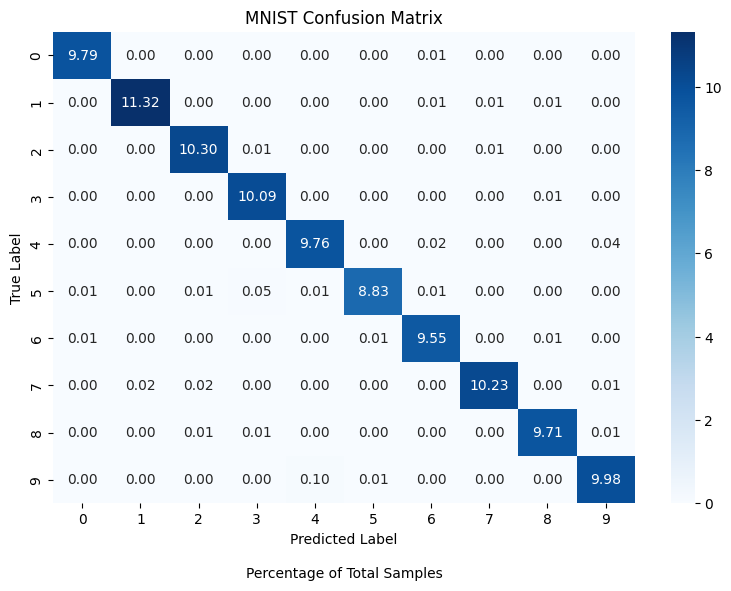

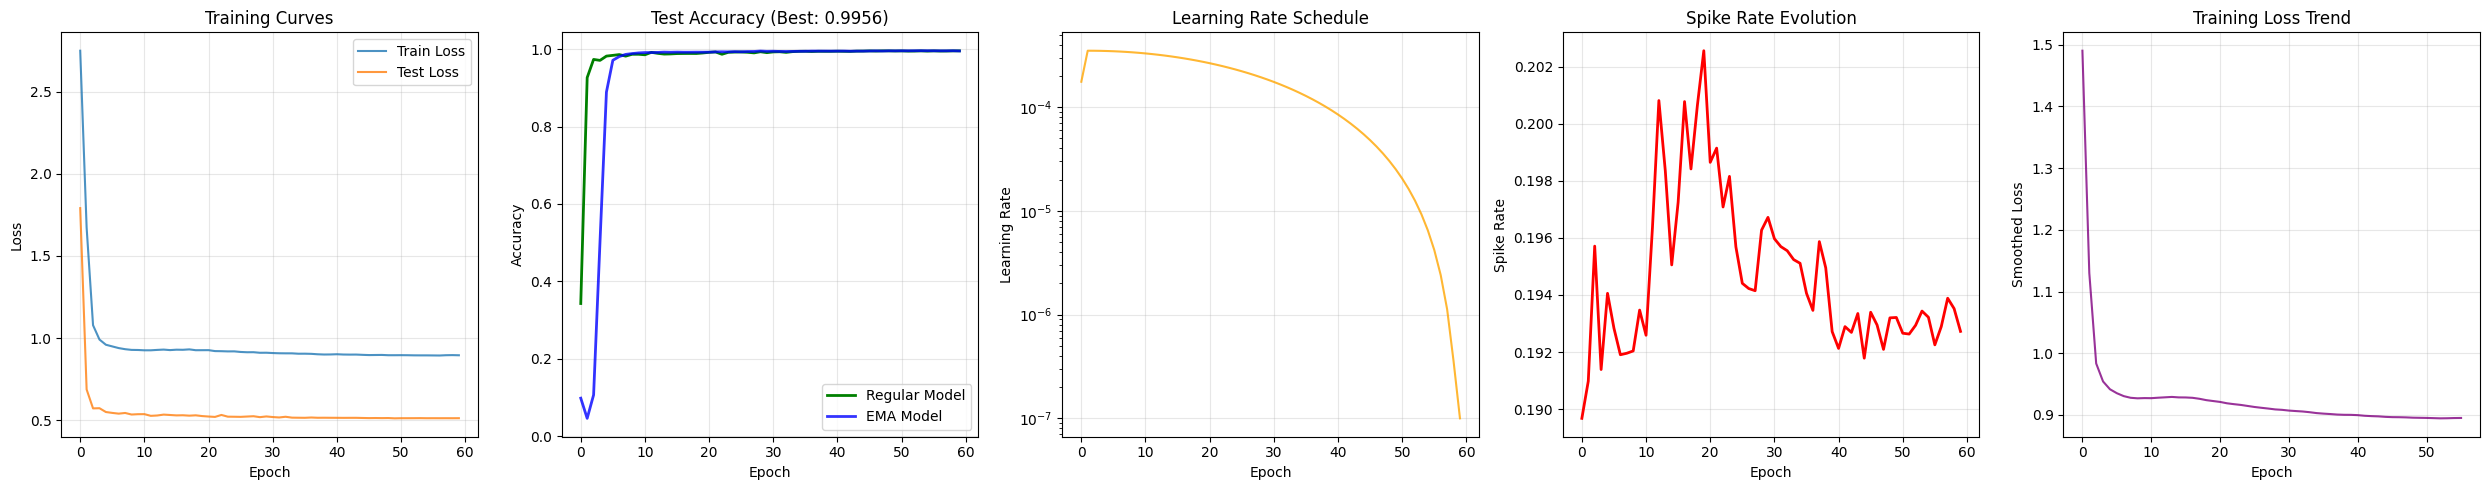


Generating model analysis...


/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


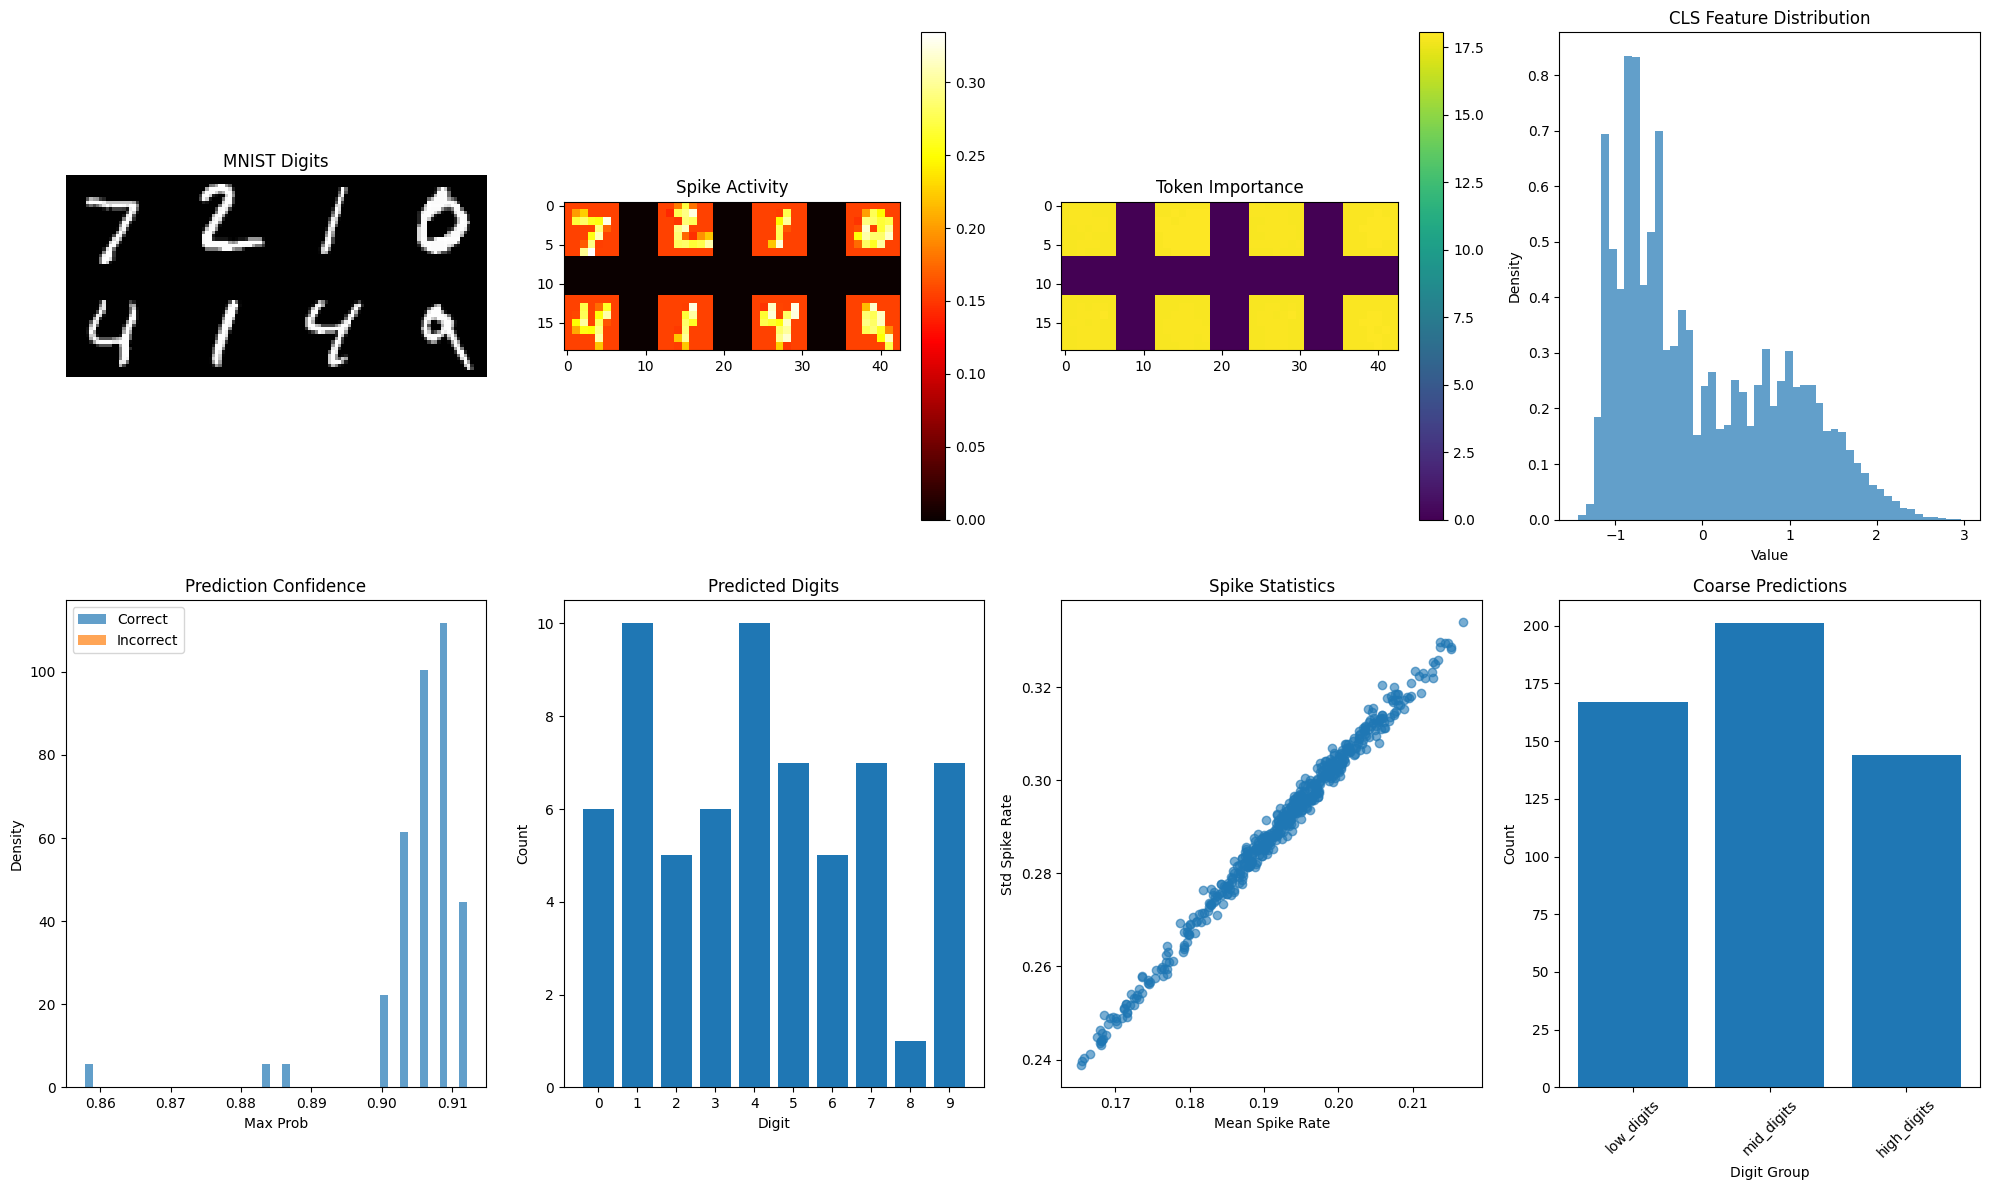

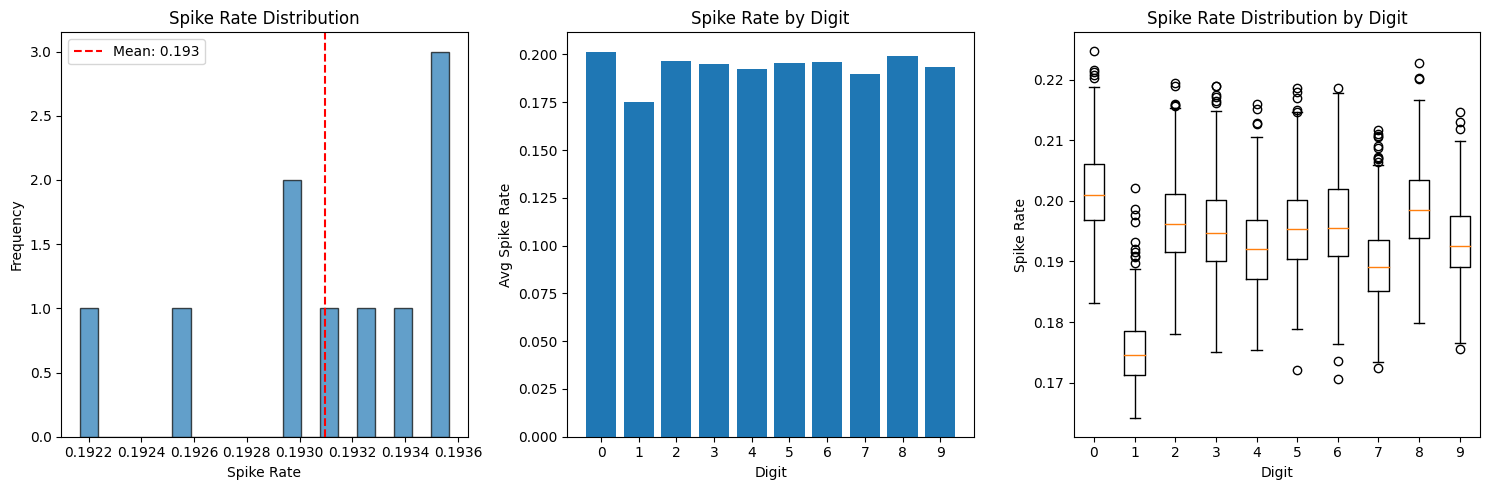

Spike Statistics:
  Mean: 0.1931 | Std: 0.0004
  Min: 0.1922 | Max: 0.1936

Testing inference speed...
Testing model inference speed...
Inference Results (100 samples):
  Avg time: 14.43 ms | Accuracy: 1.0000
  Throughput: 69.3 samples/sec

Detailed Analysis by Digit Groups:
  low_digits (digits [0, 1, 2]): 0.9981 (3141/3147)
  mid_digits (digits [3, 4, 5, 6]): 0.9951 (3823/3842)
  high_digits (digits [7, 8, 9]): 0.9937 (2992/3011)

Classification Report:
              precision    recall  f1-score   support

     Digit 0       1.00      1.00      1.00       980
     Digit 1       1.00      1.00      1.00      1135
     Digit 2       1.00      1.00      1.00      1032
     Digit 3       0.99      1.00      1.00      1010
     Digit 4       0.99      0.99      0.99       982
     Digit 5       1.00      0.99      0.99       892
     Digit 6       0.99      1.00      1.00       958
     Digit 7       1.00      1.00      1.00      1028
     Digit 8       1.00      1.00      1.00       974

In [6]:
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

"""
Complete Enhanced Temporal Spiking ViT for MNIST (Fixed)
======================================================
Features: Hierarchical digit classification, graph consistency, comprehensive evaluation
Author: Enhanced implementation with fixed tensor copying warnings
Dataset: MNIST handwritten digits (0-9)
Hierarchy: low_digits(0-2), mid_digits(3-6), high_digits(7-9)
"""

import math, torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np, seaborn as sns, time, gc
from sklearn.metrics import (precision_recall_fscore_support, roc_auc_score, mean_absolute_error, 
                           mean_squared_error, r2_score, confusion_matrix, classification_report)
from sklearn.preprocessing import label_binarize

# ================================
# HYPERPARAMETERS FOR MNIST
# ================================
EMBED_DIM = 384; NUM_BLOCKS = 8; NUM_HEADS = 8; MLP_RATIO = 4.0; PATCH_SIZE = 4
T_PATCH = 6; T_ATTN = 2; T_MLP = 2; DROPOUT = 0.12; DROPPATH = 0.12
WEIGHT_DECAY = 0.04; LR = 3.5e-4; EPOCHS = 60; BATCH_TRAIN = 256; BATCH_TEST = 512
LABEL_SMOOTH = 0.1; CLIP_NORM = 0.8; WARMUP_EPOCHS = 2
COARSE_LOSS_W = 0.3; GRAPH_LOSS_W = 0.12; KNN_K = 8; TAU = 0.08
BANK_SIZE = 10240; GATING_INFER = True; EMA_DECAY = 0.999

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
if torch.cuda.is_available(): 
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

# MNIST hierarchical grouping: low(0-2), mid(3-6), high(7-9)
COARSE_NAMES = ["low_digits", "mid_digits", "high_digits"]
PARENT_MAP = {0:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:1, 7:2, 8:2, 9:2}

print(f"Enhanced Temporal Spiking ViT for MNIST initialized on {device}")

# ================================
# CORE NEURAL COMPONENTS
# ================================
class OptimizedSurrogateSpike(torch.autograd.Function):
    """Temperature-controlled surrogate gradient for spiking neurons"""
    @staticmethod
    def forward(ctx, x, temperature=1.0):
        out = (x >= 0).float()
        # Ensure temperature is a tensor and on the correct device
        if not isinstance(temperature, torch.Tensor):
            temperature = torch.tensor(temperature, device=x.device, dtype=torch.float32)
        else:
            temperature = temperature.clone().detach().to(device=x.device, dtype=torch.float32)
        ctx.save_for_backward(x, temperature)
        return out
    
    @staticmethod
    def backward(ctx, grad_out):
        x, temp = ctx.saved_tensors
        alpha = 3.0 / temp
        grad = alpha * torch.sigmoid(alpha * x) * (1 - torch.sigmoid(alpha * x))
        return grad_out * grad, None

spike_fn = OptimizedSurrogateSpike.apply

class EnhancedAdaptiveLIFNeuron(nn.Module):
    """Adaptive Leaky Integrate-and-Fire neuron with learnable parameters"""
    def __init__(self, decay=0.9, v_th=1.0, learnable=True, temp_scale=1.0):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay, dtype=torch.float32)) if learnable else decay
        self.v_th = nn.Parameter(torch.tensor(v_th, dtype=torch.float32)) if learnable else v_th
        self.temp_scale = nn.Parameter(torch.tensor(temp_scale, dtype=torch.float32)) if learnable else temp_scale
        
    def forward(self, x, T=1):
        if T == 1: 
            return spike_fn(x - self.v_th, self.temp_scale)
        
        batch_size = x.shape[0]
        mem = x.new_zeros(x.shape)
        spike_train = []
        
        for t in range(T):
            mem = torch.clamp(self.decay * mem + x, min=-2*self.v_th, max=3*self.v_th)
            z = mem - self.v_th
            s = spike_fn(z, self.temp_scale)
            mem = mem * (1 - s)  # Hard reset
            spike_train.append(s)
        
        weights = torch.softmax(torch.linspace(0.5, 1.0, T, device=x.device), dim=0)
        weighted_sum = sum(w * s for w, s in zip(weights, spike_train))
        return weighted_sum

class OptimizedDropPath(nn.Module):
    """Stochastic depth for regularization"""
    def __init__(self, drop_prob=0.1, scale_by_keep=True):
        super().__init__()
        self.drop_prob = float(drop_prob)
        self.scale_by_keep = scale_by_keep
        
    def forward(self, x):
        if not self.training or self.drop_prob == 0.0: 
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep_prob)
        if self.scale_by_keep: 
            mask = mask / keep_prob
        return x * mask

class CachedPositionalEmbedding(nn.Module):
    """Cached 2D sinusoidal positional embeddings for efficiency"""
    def __init__(self, max_h=32, max_w=32, dim=EMBED_DIM):
        super().__init__()
        self.dim = dim
        self.max_h = max_h
        self.max_w = max_w
        self._cache = {}
        
    def get_2d_sincos_pos_embed(self, nh, nw, device):
        key = (nh, nw, device)
        if key not in self._cache:
            assert self.dim % 2 == 0, "embed dim must be even for 2D sincos"
            
            def pe(n, d):
                pos = torch.arange(n, device=device, dtype=torch.float32)[:, None]
                div = torch.exp(torch.arange(0, d, 2, device=device, dtype=torch.float32) * (-math.log(10000.0) / d))
                out = torch.zeros(n, d, device=device, dtype=torch.float32)
                out[:, 0::2] = torch.sin(pos * div)
                out[:, 1::2] = torch.cos(pos * div)
                return out
                
            d_half = self.dim // 2
            ph = pe(nh, d_half)
            pw = pe(nw, d_half)
            ph_rep = ph[:, None, :].repeat(1, nw, 1).reshape(nh * nw, d_half)
            pw_rep = pw[None, :, :].repeat(nh, 1, 1).reshape(nh * nw, d_half)
            pe_2d = torch.cat([ph_rep, pw_rep], dim=1)
            self._cache[key] = pe_2d
            
        return self._cache[key]

# ================================
# MODEL COMPONENTS
# ================================
class EnhancedPatchEmbed(nn.Module):
    """Patch embedding with spiking dynamics"""
    def __init__(self, in_channels=1, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.norm = nn.BatchNorm2d(embed_dim)
        self.lif = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=1.0, learnable=True, temp_scale=0.8)
        self.T = T
        nn.init.kaiming_normal_(self.proj.weight, mode='fan_out', nonlinearity='relu')
        
    def forward(self, x):
        feat = self.proj(x)
        feat = self.norm(feat)
        spikes = self.lif(feat, T=self.T)
        B, C, H, W = spikes.shape
        tokens = spikes.view(B, C, H * W).permute(0, 2, 1)
        return tokens, (H, W), spikes

class EnhancedTransformerBlock(nn.Module):
    """Transformer block with spiking neurons"""
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO, 
                 attn_dropout=0.0, dropout=DROPOUT, droppath=DROPPATH, T_attn=T_ATTN, T_mlp=T_MLP):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        # Attention components
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.q_bias = nn.Parameter(torch.zeros(embed_dim))
        self.v_bias = nn.Parameter(torch.zeros(embed_dim))
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        self.drop1 = OptimizedDropPath(droppath)
        
        # MLP components
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, embed_dim)
        )
        self.drop2 = OptimizedDropPath(droppath)
        
        # Spiking neurons
        self.snn_attn = EnhancedAdaptiveLIFNeuron(decay=0.8, v_th=0.8, learnable=True, temp_scale=0.9)
        self.snn_mlp = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=0.9, learnable=True, temp_scale=0.9)
        self.T_attn = T_attn
        self.T_mlp = T_mlp
        
        # Weight initialization
        nn.init.xavier_uniform_(self.qkv.weight)
        nn.init.xavier_uniform_(self.proj.weight)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Self-attention with spiking
        y = self.norm1(x)
        qkv_bias = torch.cat([self.q_bias, torch.zeros_like(self.v_bias), self.v_bias])
        qkv = F.linear(y, self.qkv.weight, qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        y = (attn @ v).transpose(1, 2).reshape(B, N, C)
        y = self.proj(y)
        y = self.proj_drop(y)
        y = self.snn_attn(y, T=self.T_attn)
        x = x + self.drop1(y)
        
        # MLP with spiking
        y = self.norm2(x)
        y = self.mlp(y)
        y = self.snn_mlp(y, T=self.T_mlp)
        x = x + self.drop2(y)
        
        return x

class EnhancedSNN_ViT_MNIST(nn.Module):
    """Complete Spiking Vision Transformer for MNIST"""
    def __init__(self, num_classes=10, in_channels=1, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO, 
                 dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_classes = num_classes
        
        # Patch embedding
        self.patch = EnhancedPatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)
        self.pos_embed = CachedPositionalEmbedding(dim=embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Transformer blocks with stochastic depth
        dpr = [x.item() for x in torch.linspace(0, droppath, num_blocks)]
        self.blocks = nn.ModuleList([
            EnhancedTransformerBlock(embed_dim, num_heads, mlp_ratio, 
                                   attn_dropout=0.0, dropout=dropout, droppath=dpr[i], 
                                   T_attn=T_ATTN, T_mlp=T_MLP)
            for i in range(num_blocks)
        ])
        
        # Output layers
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head_fine = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, num_classes)
        )
        self.head_coarse = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, 3)  # 3-way coarse classification
        )
        
        self._init_weights()
        
    def _init_weights(self):
        """Initialize model weights"""
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, return_aux=False):
        # Patch embedding
        tokens, (Hp, Wp), conv_spikes = self.patch(x)
        B, N, C = tokens.shape
        
        # Add positional embedding
        pos = self.pos_embed.get_2d_sincos_pos_embed(Hp, Wp, tokens.device)
        pos = pos.unsqueeze(0).expand(B, -1, -1)
        
        # Add CLS token
        cls = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls, tokens], dim=1)
        
        # Add positional embedding (zero for CLS token)
        zero_cls = torch.zeros(B, 1, self.embed_dim, device=tokens.device)
        pos_full = torch.cat([zero_cls, pos], dim=1)
        x = self.pos_drop(x + pos_full)
        
        # Transformer blocks
        for blk in self.blocks:
            x = blk(x)
            
        # Final normalization and prediction
        x = self.norm(x)
        cls_repr = x[:, 0]
        
        fine_logits = self.head_fine(cls_repr)
        coarse_logits = self.head_coarse(cls_repr)
        
        aux = {
            "conv_spikes": conv_spikes,
            "cls": cls_repr,
            "coarse_logits": coarse_logits,
            "patch_tokens": x[:, 1:]
        }
        return (fine_logits, aux) if return_aux else (fine_logits, None)

# ================================
# UTILITY CLASSES
# ================================
class EnhancedMemoryBank:
    """Memory bank for graph consistency learning"""
    def __init__(self, dim, num_classes, max_size=BANK_SIZE, device="cpu"):
        self.dim = dim
        self.num_classes = num_classes
        self.max_size = max_size
        self.device = device
        self.feats = torch.empty(0, dim, device=device, dtype=torch.float32)
        self.probs = torch.empty(0, num_classes, device=device, dtype=torch.float32)
        self.insert_idx = 0
        
    def __len__(self):
        return min(self.insert_idx, self.max_size)
    
    @torch.no_grad()
    def add(self, feats, logits):
        """Add features and predictions to memory bank"""
        feats = F.normalize(feats.detach(), dim=1, p=2)
        probs = torch.softmax(logits.detach(), dim=-1)
        batch_size = feats.size(0)
        
        if self.feats.size(0) == 0:
            self.feats = torch.zeros(self.max_size, self.dim, device=self.device, dtype=torch.float32)
            self.probs = torch.zeros(self.max_size, self.num_classes, device=self.device, dtype=torch.float32)
            
        for i in range(batch_size):
            idx = self.insert_idx % self.max_size
            self.feats[idx] = feats[i]
            self.probs[idx] = probs[i]
            self.insert_idx += 1
    
    def knn(self, feats, k=KNN_K, tau=TAU):
        """K-nearest neighbor search"""
        if len(self) == 0:
            return None, None
            
        feats = F.normalize(feats, dim=1, p=2)
        active_size = min(self.insert_idx, self.max_size)
        active_feats = self.feats[:active_size]
        active_probs = self.probs[:active_size]
        
        sim = torch.mm(feats, active_feats.t())
        k = min(k, active_size)
        vals, idx = sim.topk(k, dim=1)
        w = torch.softmax(vals / tau, dim=1)
        neigh_probs = active_probs[idx]
        return w, neigh_probs

def build_gate_matrix():
    """Build gating matrix for hierarchical classification"""
    G = torch.zeros(3, 10, dtype=torch.float32)  # 3 coarse classes, 10 fine classes
    for c, p in PARENT_MAP.items():
        G[p, c] = 1.0
    G = G / G.sum(dim=1, keepdim=True).clamp_min(1e-12)
    return G

class EMAModel:
    """Exponential Moving Average model for stable training"""
    def __init__(self, model, decay=EMA_DECAY):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
            
    def update(self, model):
        """Update EMA parameters"""
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        """Apply EMA parameters to model"""
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]
    
    def restore(self):
        """Restore original parameters"""
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

# ================================
# TRAINING UTILITIES
# ================================
def enhanced_laplacian_loss(curr_probs, bank_weights, bank_probs, temperature=0.5):
    """Graph consistency loss using memory bank"""
    if bank_weights is None or bank_probs is None:
        return torch.tensor(0.0, device=curr_probs.device)
    
    curr_probs_smooth = torch.softmax(curr_probs / temperature, dim=-1)
    bank_probs_smooth = torch.softmax(bank_probs / temperature, dim=-1)
    kl_div = F.kl_div(curr_probs_smooth.log().unsqueeze(1), 
                      bank_probs_smooth, reduction='none').sum(dim=-1)
    return (bank_weights * kl_div).mean()

def build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR):
    """Cosine annealing scheduler with warmup"""
    def lr_lambda(step):
        if step < warmup_steps:
            return (step + 1) / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
        return (min_lr / base_lr) + (1 - min_lr / base_lr) * cosine
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def get_mnist_transforms():
    """MNIST data transforms"""
    MNIST_MEAN, MNIST_STD = 0.1307, 0.3081
    
    transform_train = transforms.Compose([
        transforms.RandomRotation(10, fill=0),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), fill=0),
        transforms.ToTensor(),
        transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
    ])
    
    return transform_train, transform_test

# ================================
# COMPREHENSIVE EVALUATION SUITE
# ================================
@torch.no_grad()
def compute_comprehensive_metrics(model, loader, criterion_fine, apply_gating=True):
    """Compute all evaluation metrics"""
    model.eval()
    all_preds, all_targets, all_probs = [], [], []
    total_loss = 0.0
    
    gate_mat = build_gate_matrix().to(device) if apply_gating else None
    
    for data, target in loader:
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        fine_logits, aux = model(data, return_aux=True)
        loss = criterion_fine(fine_logits, target)
        
        probs = torch.softmax(fine_logits, dim=-1)
        
        if apply_gating and gate_mat is not None:
            coarse_logits = aux["coarse_logits"]
            cprob = torch.softmax(coarse_logits, dim=-1)
            gate = cprob @ gate_mat
            gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
            probs = (probs * gate).clamp_min(1e-12)
            probs = probs / probs.sum(dim=1, keepdim=True)
        
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(probs.argmax(dim=1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        total_loss += float(loss.item())
    
    y_true = np.array(all_targets)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)
    
    accuracy = (y_true == y_pred).mean()
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0)
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    try:
        y_true_bin = label_binarize(y_true, classes=range(10))
        roc_auc = roc_auc_score(y_true_bin, y_prob, multi_class='ovr', average='macro')
    except:
        roc_auc = 0.0
    
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'loss': total_loss / len(loader), 'accuracy': accuracy,
        'precision_macro': precision_macro, 'precision_weighted': precision_weighted,
        'recall_macro': recall_macro, 'recall_weighted': recall_weighted,
        'f1_macro': f1_macro, 'f1_weighted': f1_weighted,
        'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

def print_comprehensive_results(metrics, title="Results"):
    """Print formatted results"""
    print(f"\n{title}:")
    print(f"Accuracy: {metrics['accuracy']:.4f} | F1: {metrics['f1_weighted']:.4f} | ROC-AUC: {metrics['roc_auc']:.4f}")
    print(f"Precision: {metrics['precision_weighted']:.4f} | Recall: {metrics['recall_weighted']:.4f}")
    print(f"MAE: {metrics['mae']:.4f} | MSE: {metrics['mse']:.4f} | RMSE: {metrics['rmse']:.4f} | R²: {metrics['r2']:.4f}")

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """Plot confusion matrix with percentages"""
    plt.figure(figsize=(8, 6))
    cm_percent = cm.astype('float') / cm.sum() * 100
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10), annot_kws={"size": 10})
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.text(0.5, -0.15, 'Percentage of Total Samples', ha='center', va='center', 
             transform=plt.gca().transAxes, fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_training_curves(train_losses, test_losses, test_accs, ema_accs=None, learning_rates=None, spike_rates=None):
    """Plot comprehensive training curves"""
    fig_width = 25 if ema_accs and spike_rates else 20 if spike_rates else 15
    n_plots = 5 if ema_accs and spike_rates else 4 if spike_rates else 3
    
    plt.figure(figsize=(fig_width, 5))
    
    # Loss curves
    plt.subplot(1, n_plots, 1)
    plt.plot(train_losses, label='Train Loss', alpha=0.8)
    plt.plot(test_losses, label='Test Loss', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy curves
    plt.subplot(1, n_plots, 2)
    plt.plot(test_accs, label='Regular Model', color='green', linewidth=2)
    if ema_accs:
        plt.plot(ema_accs, label='EMA Model', color='blue', linewidth=2, alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Test Accuracy (Best: {max(test_accs) if test_accs else 0:.4f})')
    if ema_accs:
        plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Learning rate schedule
    if learning_rates:
        plt.subplot(1, n_plots, 3)
        plt.plot(learning_rates, color='orange', alpha=0.8)
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
    
    # Spike rate evolution
    if spike_rates:
        plot_idx = 4 if learning_rates else 3
        plt.subplot(1, n_plots, plot_idx)
        plt.plot(spike_rates, color='red', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Spike Rate')
        plt.title('Spike Rate Evolution')
        plt.grid(True, alpha=0.3)
    
    # Smoothed loss trend
    if ema_accs and spike_rates:
        plt.subplot(1, n_plots, 5)
        smoothed_loss = np.convolve(train_losses, np.ones(min(5, len(train_losses)))/min(5, len(train_losses)), mode='valid')
        plt.plot(smoothed_loss, color='purple', alpha=0.8)
        plt.xlabel('Epoch')
        plt.ylabel('Smoothed Loss')
        plt.title('Training Loss Trend')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ================================
# ANALYSIS AND VISUALIZATION
# ================================
def visualize_model_analysis(model, test_loader):
    """Comprehensive model behavior visualization"""
    model.eval()
    data_iter = iter(test_loader)
    try:
        data, targets = next(data_iter)
    except StopIteration:
        print("Test loader is empty. Skipping visualization.")
        return
    
    data, targets = data.to(device), targets.to(device)
    
    with torch.no_grad():
        fine_logits, aux = model(data, return_aux=True)
        conv_spikes = aux["conv_spikes"]
        cls_features = aux["cls"]
        patch_tokens = aux["patch_tokens"]
    
    plt.figure(figsize=(20, 12))
    
    # Input images (MNIST specific)
    plt.subplot(2, 4, 1)
    sample_imgs = data[:8].cpu()
    mean, std = 0.1307, 0.3081
    sample_imgs = sample_imgs * std + mean
    sample_imgs = torch.clamp(sample_imgs, 0, 1)
    
    grid = torch.zeros(28*2 + 5, 28*4 + 15)
    for i in range(min(8, len(sample_imgs))):
        row, col = i // 4, i % 4
        start_h, start_w = row * 33, col * 33
        grid[start_h:start_h+28, start_w:start_w+28] = sample_imgs[i].squeeze()
    
    plt.imshow(grid, cmap='gray')
    plt.title('MNIST Digits')
    plt.axis('off')
    
    # Spike activity heatmap
    plt.subplot(2, 4, 2)
    spike_mean = conv_spikes[:8].mean(dim=1).cpu()
    grid_spikes = torch.zeros(7*2 + 5, 7*4 + 15)
    
    for i in range(min(8, len(spike_mean))):
        row, col = i // 4, i % 4
        start_h, start_w = row * 12, col * 12
        grid_spikes[start_h:start_h+7, start_w:start_w+7] = spike_mean[i]
    
    plt.imshow(grid_spikes, cmap='hot')
    plt.title('Spike Activity')
    plt.colorbar()
    
    # Token importance
    plt.subplot(2, 4, 3)
    patch_norms = torch.norm(patch_tokens[:8], dim=-1).cpu()
    grid_attn = torch.zeros(7*2 + 5, 7*4 + 15)
    for i in range(min(8, len(patch_norms))):
        row, col = i // 4, i % 4
        start_h, start_w = row * 12, col * 12
        grid_attn[start_h:start_h+7, start_w:start_w+7] = patch_norms[i].view(7, 7)
    
    plt.imshow(grid_attn, cmap='viridis')
    plt.title('Token Importance')
    plt.colorbar()
    
    # Feature distribution
    plt.subplot(2, 4, 4)
    cls_feat_cpu = cls_features[:64].cpu().numpy()
    plt.hist(cls_feat_cpu.flatten(), bins=50, alpha=0.7, density=True)
    plt.title('CLS Feature Distribution')
    plt.xlabel('Value')
    plt.ylabel('Density')
    
    # Prediction confidence
    plt.subplot(2, 4, 5)
    probs = torch.softmax(fine_logits[:64], dim=-1)
    max_probs = probs.max(dim=-1)[0].cpu().numpy()
    pred_correct = (fine_logits[:64].argmax(dim=1) == targets[:64]).cpu().numpy()
    
    plt.hist([max_probs[pred_correct], max_probs[~pred_correct]], 
             bins=20, alpha=0.7, label=['Correct', 'Incorrect'], density=True)
    plt.title('Prediction Confidence')
    plt.xlabel('Max Prob')
    plt.ylabel('Density')
    plt.legend()
    
    # Class distribution
    plt.subplot(2, 4, 6)
    pred_classes = fine_logits[:64].argmax(dim=1).cpu().numpy()
    class_counts = np.bincount(pred_classes, minlength=10)
    plt.bar(range(10), class_counts)
    plt.title('Predicted Digits')
    plt.xlabel('Digit')
    plt.ylabel('Count')
    plt.xticks(range(10))
    
    # Spike statistics
    plt.subplot(2, 4, 7)
    spike_stats = conv_spikes.view(conv_spikes.size(0), -1).cpu()
    spike_means = spike_stats.mean(dim=1).numpy()
    spike_stds = spike_stats.std(dim=1).numpy()
    plt.scatter(spike_means, spike_stds, alpha=0.6)
    plt.xlabel('Mean Spike Rate')
    plt.ylabel('Std Spike Rate')
    plt.title('Spike Statistics')
    
    # Coarse vs Fine predictions
    plt.subplot(2, 4, 8)
    coarse_logits = aux["coarse_logits"]
    coarse_preds = coarse_logits.argmax(dim=1).cpu().numpy()
    coarse_counts = np.bincount(coarse_preds, minlength=3)
    plt.bar(range(3), coarse_counts)
    plt.title('Coarse Predictions')
    plt.xlabel('Digit Group')
    plt.ylabel('Count')
    plt.xticks(range(3), COARSE_NAMES, rotation=45)
    
    plt.tight_layout()
    plt.show()

def analyze_spiking_activity(model, test_loader):
    """Detailed spike rate analysis"""
    model.eval()
    spike_rates, class_spikes = [], {i: [] for i in range(10)}
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= 10:
                break
            data, target = data.to(device), target.to(device)
            _, aux = model(data, return_aux=True)
            
            conv_spikes = aux["conv_spikes"]
            spike_rate = conv_spikes.mean().item()
            spike_rates.append(spike_rate)
            
            for j, class_idx in enumerate(target.cpu().numpy()):
                if j < conv_spikes.size(0):
                    class_spike_rate = conv_spikes[j].mean().item()
                    class_spikes[class_idx].append(class_spike_rate)
    
    plt.figure(figsize=(15, 5))
    
    # Overall spike rate distribution
    plt.subplot(1, 3, 1)
    plt.hist(spike_rates, bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(spike_rates), color='red', linestyle='--', 
                label=f'Mean: {np.mean(spike_rates):.3f}')
    plt.xlabel('Spike Rate')
    plt.ylabel('Frequency')
    plt.title('Spike Rate Distribution')
    plt.legend()
    
    # Spike rate by digit
    plt.subplot(1, 3, 2)
    class_means = [np.mean(rates) if rates else 0 for rates in class_spikes.values()]
    plt.bar(range(10), class_means)
    plt.xlabel('Digit')
    plt.ylabel('Avg Spike Rate')
    plt.title('Spike Rate by Digit')
    plt.xticks(range(10))
    
    # Box plot of spike rates by digit
    plt.subplot(1, 3, 3)
    plt.boxplot([class_spikes[i] if class_spikes[i] else [0] for i in range(10)])
    plt.xlabel('Digit')
    plt.ylabel('Spike Rate')
    plt.title('Spike Rate Distribution by Digit')
    plt.xticks(range(1, 11), range(10))
    
    plt.tight_layout()
    plt.show()
    
    print(f"Spike Statistics:")
    print(f"  Mean: {np.mean(spike_rates):.4f} | Std: {np.std(spike_rates):.4f}")
    print(f"  Min: {np.min(spike_rates):.4f} | Max: {np.max(spike_rates):.4f}")

def test_model_inference(model_path='./mnist_enhanced_snn_vit_best.pth'):
    """Test model inference speed and accuracy"""
    print("Testing model inference speed...")
    
    try:
        model = EnhancedSNN_ViT_MNIST().to(device)
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['state_dict'])
        model.eval()
        
        _, transform_test = get_mnist_transforms()
        test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform_test)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
        
        times, correct, total = [], 0, 0
        
        with torch.no_grad():
            for i, (data, target) in enumerate(test_loader):
                if i >= 100:
                    break
                data, target = data.to(device), target.to(device)
                
                start_time = time.time()
                logits, _ = model(data, return_aux=False)
                end_time = time.time()
                
                times.append(end_time - start_time)
                pred = logits.argmax(dim=1)
                correct += (pred == target).sum().item()
                total += 1
        
        avg_time = np.mean(times) * 1000
        accuracy = correct / total if total > 0 else 0
        
        print(f"Inference Results (100 samples):")
        print(f"  Avg time: {avg_time:.2f} ms | Accuracy: {accuracy:.4f}")
        print(f"  Throughput: {1000/avg_time:.1f} samples/sec")
    
    except Exception as e:
        print(f"Error during inference testing: {e}")

def save_model_checkpoint(model, optimizer, epoch, best_acc, loss, filepath, config=None):
    """Save comprehensive model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict() if optimizer else None,
        'best_accuracy': best_acc,
        'loss': loss,
        'hyperparameters': {
            'embed_dim': EMBED_DIM,
            'num_blocks': NUM_BLOCKS,
            'num_heads': NUM_HEADS,
            'mlp_ratio': MLP_RATIO,
            'patch_size': PATCH_SIZE,
            'dropout': DROPOUT,
        }
    }
    if config:
        checkpoint.update(config)
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved: {filepath}")

# ================================
# TRAINING FUNCTIONS
# ================================
def train_one_epoch_enhanced(model, ema_model, loader, optimizer, scaler, scheduler, 
                           criterion_fine, criterion_coarse, bank, epoch, total_epochs):
    """Enhanced training loop with comprehensive loss components"""
    model.train()
    run_loss, run_srl, run_graph, run_coarse, run_hier = 0.0, 0.0, 0.0, 0.0, 0.0
    n_batches = 0
    
    coarse_weight = COARSE_LOSS_W * (1.0 + 0.4 * epoch / total_epochs)
    graph_weight = GRAPH_LOSS_W * min(1.0, epoch / (total_epochs * 0.3))
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast(device_type='cuda', enabled=(device == "cuda")):
            fine_logits, aux = model(data, return_aux=True)
            cls = aux["cls"]
            coarse_logits = aux["coarse_logits"]
            
            ce_fine = criterion_fine(fine_logits, target)
            
            coarse_targets = torch.tensor([PARENT_MAP[int(t)] for t in target], device=device)
            ce_coarse = criterion_coarse(coarse_logits, coarse_targets)
            
            fine_probs = torch.softmax(fine_logits, dim=-1)
            coarse_probs = torch.softmax(coarse_logits, dim=-1)
            gate_mat = build_gate_matrix().to(device)
            expected_coarse = fine_probs @ gate_mat.t()
            hier_loss = F.kl_div(expected_coarse.log(), coarse_probs, reduction='batchmean')
            
            conv_spikes = aux.get("conv_spikes", None)
            if conv_spikes is not None:
                current_rate = conv_spikes.mean()
                target_rate = 0.12 + 0.08 * math.exp(-epoch / 8)
                srl = (current_rate - target_rate).pow(2) * 2e-3
            else:
                srl = torch.tensor(0.0, device=device)
            
            with torch.no_grad():
                w, neigh_probs = bank.knn(cls, k=KNN_K, tau=TAU) if bank is not None else (None, None)
            g_loss = enhanced_laplacian_loss(fine_logits, w, neigh_probs) if bank is not None else torch.tensor(0.0, device=device)
            
            loss = (ce_fine + coarse_weight * ce_coarse + 0.2 * hier_loss + graph_weight * g_loss + srl)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)
        if scheduler is not None:
            scheduler.step()
        scaler.update()
        
        if ema_model is not None:
            ema_model.update(model)
        if bank is not None:
            with torch.no_grad():
                bank.add(cls, fine_logits)
        
        run_loss += float(loss.item())
        run_srl += float(srl.item())
        run_graph += float(g_loss.item())
        run_coarse += float(ce_coarse.item())
        run_hier += float(hier_loss.item())
        n_batches += 1
    
    avg_loss = run_loss / max(1, n_batches)
    print(f"Train [{epoch:2d}/{total_epochs}] | Loss {avg_loss:.4f} | SpikeReg {run_srl/n_batches:.4e} | "
          f"Graph {run_graph/n_batches:.4f} | CoarseCE {run_coarse/n_batches:.4f} | HierKL {run_hier/n_batches:.4f}")
    return avg_loss

# ================================
# MAIN TRAINING EXECUTION
# ================================
def main_mnist():
    """Main training function with comprehensive evaluation"""
    print("=== Enhanced Temporal Spiking ViT for MNIST ===")
    print(f"Device: {device}")
    
    # Data preparation
    transform_train, transform_test = get_mnist_transforms()
    
    try:
        train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform_train)
        test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform_test)
    except Exception as e:
        print(f"Error loading MNIST dataset: {e}")
        return None, 0.0, {}
    
    pin = torch.cuda.is_available()
    num_workers = min(8, torch.get_num_threads()) if pin else 0
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True,  
                             num_workers=num_workers, pin_memory=pin, persistent_workers=num_workers > 0, 
                             prefetch_factor=2 if num_workers > 0 else 2)
    
    test_loader = DataLoader(test_dataset, batch_size=BATCH_TEST, shuffle=False, 
                            num_workers=num_workers, pin_memory=pin, persistent_workers=num_workers > 0, 
                            prefetch_factor=2 if num_workers > 0 else 2)
    
    print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")
    print(f"Hierarchical grouping: {COARSE_NAMES}")
    print(f"Digit mapping: {PARENT_MAP}")
    
    # Model initialization
    model = EnhancedSNN_ViT_MNIST().to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Training setup
    param_groups = [
        {'params': [p for n, p in model.named_parameters() if 'bias' not in n and 'norm' not in n], 'weight_decay': WEIGHT_DECAY},
        {'params': [p for n, p in model.named_parameters() if 'bias' in n or 'norm' in n], 'weight_decay': 0.0}
    ]
    
    optimizer = optim.AdamW(param_groups, lr=LR, betas=(0.9, 0.95), eps=1e-8)
    criterion_fine = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    criterion_coarse = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH * 0.5)
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))
    
    steps_per_epoch = len(train_loader)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = WARMUP_EPOCHS * steps_per_epoch
    scheduler = build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR)
    
    ema_model = EMAModel(model, decay=EMA_DECAY)
    bank = EnhancedMemoryBank(dim=EMBED_DIM, num_classes=10, max_size=BANK_SIZE, device=device)
    
    print(f"\nTraining Configuration:")
    print(f"Epochs: {EPOCHS}, Batch size: {BATCH_TRAIN}, Learning rate: {LR}")
    print(f"Coarse loss weight: {COARSE_LOSS_W}, Graph loss weight: {GRAPH_LOSS_W}")
    print(f"Memory bank size: {BANK_SIZE}, KNN K: {KNN_K}, Temperature: {TAU}")
    print(f"EMA decay: {EMA_DECAY}, Gating inference: {GATING_INFER}")
    
    # Training loop
    best_acc = 0.0
    best_ema_acc = 0.0
    train_losses, test_losses, test_accs, ema_test_accs = [], [], [], []
    learning_rates, spike_rates = [], []
    patience = 12
    patience_counter = 0
    
    print(f"\nStarting Enhanced Training on MNIST...")
    print("="*70)
    
    for epoch in range(1, EPOCHS + 1):
        # Training step
        try:
            epoch_loss = train_one_epoch_enhanced(
                model, ema_model, train_loader, optimizer, scaler, scheduler, 
                criterion_fine, criterion_coarse, bank, epoch, EPOCHS
            )
        except Exception as e:
            print(f"Error during training epoch {epoch}: {e}")
            continue
        
        # Evaluation
        try:
            test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
            
            ema_model.apply_shadow()
            ema_test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
            ema_model.restore()
        except Exception as e:
            print(f"Error during evaluation at epoch {epoch}: {e}")
            continue
        
        # Track metrics
        train_losses.append(epoch_loss)
        test_losses.append(test_metrics['loss'])
        test_accs.append(test_metrics['accuracy'])
        ema_test_accs.append(ema_test_metrics['accuracy'])
        learning_rates.append(optimizer.param_groups[0]['lr'])
        
        # Track spike rates
        try:
            with torch.no_grad():
                model.eval()
                sample_data, _ = next(iter(test_loader))
                sample_data = sample_data[:32].to(device)
                _, aux = model(sample_data, return_aux=True)
                if aux and "conv_spikes" in aux:
                    spike_rates.append(float(aux["conv_spikes"].mean().item()))
                model.train()
        except Exception as e:
            print(f"Error tracking spike rates at epoch {epoch}: {e}")
        
        print_comprehensive_results(test_metrics, f"Epoch [{epoch:2d}/{EPOCHS}] Test Results")
        print(f"       EMA Test Accuracy: {ema_test_metrics['accuracy']:.4f}")
        
        # Save best models
        try:
            if test_metrics['accuracy'] > best_acc:
                best_acc = test_metrics['accuracy']
                patience_counter = 0
                save_model_checkpoint(model, optimizer, epoch, best_acc, epoch_loss,
                                    "./mnist_enhanced_snn_vit_best.pth", {"test_metrics": test_metrics})
                print(f"  → Saved new best model (acc: {best_acc:.4f})")
            else:
                patience_counter += 1
            
            if ema_test_metrics['accuracy'] > best_ema_acc:
                best_ema_acc = ema_test_metrics['accuracy']
                ema_model.apply_shadow()
                save_model_checkpoint(model, None, epoch, best_ema_acc, epoch_loss,
                                    "./mnist_enhanced_snn_vit_ema_best.pth", {"ema_test_metrics": ema_test_metrics})
                ema_model.restore()
                print(f"  → Saved new best EMA model (acc: {best_ema_acc:.4f})")
        except Exception as e:
            print(f"Error saving checkpoint at epoch {epoch}: {e}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement")
            break
        
        # Adaptive learning rate
        if epoch > 15 and len(test_accs) > 8:
            recent_improvement = max(test_accs[-4:]) - max(test_accs[-8:-4]) if len(test_accs) >= 8 else 0
            if recent_improvement < 0.001:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.95
        
        print()
    
    print("="*70)
    print("Training Complete!")
    print("="*70)
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Best EMA Test Accuracy: {best_ema_acc:.4f}")
    print(f"Final Memory Bank Size: {len(bank)}")
    
    # Final comprehensive evaluation
    print("\nPerforming final evaluation...")
    
    try:
        checkpoint = torch.load("./mnist_enhanced_snn_vit_best.pth", map_location=device, weights_only=False)
        model.load_state_dict(checkpoint["state_dict"])
        
        final_test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        final_test_metrics_no_gate = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=False)
        
        print_comprehensive_results(final_test_metrics, "Final Test Results (With Gating)")
        print_comprehensive_results(final_test_metrics_no_gate, "Final Test Results (Without Gating)")
        print(f"Gating improvement: {(final_test_metrics['accuracy'] - final_test_metrics_no_gate['accuracy']):.4f}")
        
        plot_confusion_matrix(final_test_metrics['confusion_matrix'], "MNIST Confusion Matrix")
        plot_training_curves(train_losses, test_losses, test_accs, ema_test_accs, learning_rates, spike_rates)
        
        print("\nGenerating model analysis...")
        visualize_model_analysis(model, test_loader)
        analyze_spiking_activity(model, test_loader)
        
        print("\nTesting inference speed...")
        test_model_inference('./mnist_enhanced_snn_vit_best.pth')
        
        print(f"\nDetailed Analysis by Digit Groups:")
        group_correct = {0: 0, 1: 0, 2: 0}
        group_total = {0: 0, 1: 0, 2: 0}
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                fine_logits, aux = model(data, return_aux=True)
                
                probs = torch.softmax(fine_logits, dim=-1)
                if GATING_INFER:
                    coarse_logits = aux["coarse_logits"]
                    cprob = torch.softmax(coarse_logits, dim=-1)
                    gate_mat = build_gate_matrix().to(device)
                    gate = cprob @ gate_mat
                    gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
                    probs = (probs * gate).clamp_min(1e-12)
                    probs = probs / probs.sum(dim=1, keepdim=True)
                
                pred = probs.argmax(dim=1)
                
                for i in range(len(target)):
                    digit = int(target[i])
                    group = PARENT_MAP[digit]
                    group_total[group] += 1
                    if pred[i] == target[i]:
                        group_correct[group] += 1
        
        for group_idx, group_name in enumerate(COARSE_NAMES):
            acc = group_correct[group_idx] / max(1, group_total[group_idx])
            digits = [d for d, g in PARENT_MAP.items() if g == group_idx]
            print(f"  {group_name} (digits {digits}): {acc:.4f} ({group_correct[group_idx]}/{group_total[group_idx]})")
        
        y_true, y_pred = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                fine_logits, aux = model(data, return_aux=True)
                
                probs = torch.softmax(fine_logits, dim=-1)
                if GATING_INFER:
                    coarse_logits = aux["coarse_logits"]
                    cprob = torch.softmax(coarse_logits, dim=-1)
                    gate_mat = build_gate_matrix().to(device)
                    gate = cprob @ gate_mat
                    gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
                    probs = (probs * gate).clamp_min(1e-12)
                    probs = probs / probs.sum(dim=1, keepdim=True)
                
                pred = probs.argmax(dim=1)
                y_true.extend(target.cpu().numpy())
                y_pred.extend(pred.cpu().numpy())
        
        print(f"\nClassification Report:")
        print("="*60)
        print(classification_report(y_true, y_pred, target_names=[f"Digit {i}" for i in range(10)]))
        
    except Exception as e:
        print(f"Error during final evaluation: {e}")
        import traceback
        traceback.print_exc()
    
    print(f"\nModel files saved:")
    print(f"  - ./mnist_enhanced_snn_vit_best.pth")
    print(f"  - ./mnist_enhanced_snn_vit_ema_best.pth")
    
    print(f"\nTraining completed successfully!")
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Best EMA Test Accuracy: {best_ema_acc:.4f}")
    
    return model, best_acc, {'train_losses': train_losses, 'test_accs': test_accs, 'best_acc': best_acc}

if __name__ == "__main__":
    try:
        model, best_acc, results = main_mnist()
        print(f"\n🎉 Training completed successfully!")
        print(f"Final Best Accuracy: {best_acc:.4f}")
    except KeyboardInterrupt:
        print("\nTraining interrupted by user.")
    except Exception as e:
        print(f"\nError during training: {e}")
        import traceback
        traceback.print_exc()